# Main Analysis

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
from pandas import DataFrame
from pandas.api.types import CategoricalDtype
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

## Variable Definitions and Constants

Here I declare all necessary variables and constants. This includes the snippet names as well as the correct answers for each snippet. I further add the possible variations.

### Constants

In [2]:
snippet_answer: dict[str, str] = {
    'arrayAverage': '4.0',
    'binarySearch': '1',
    'binaryToDecimal': '13',
    'bubbleSort': '[1,2,3,4,5]',
    'capitalizeFirstLetter': 'Hello World',
    'commonChars': '2',
    'containsSubstring': 'True',
    'countIntegerInterval': '4',
    'countLetters': '4',
    'crossSum': '16',
    'factorial': '24',
    'forwardBackward': 'pricelesssselecirp',
    'leastCommonMultiple': '30',
    'linearSearch': '1',
    'palindrome': 'True',
    'power': '8',
    'prime': 'True',
    'squareRoot': '[3.0, 5.0, 4.0, 10.0]',
    'unrolledSort': '[8, 9, 11, 12]',
    'validParentheses': 'False',
    'WarmUp': 'oefl',
}

possible_variations: dict[str, list[str]] = {
    'group_meaningful': ['MT', 'MN'],
    'group_obfuscated': ['LT', 'LN'],
}

# The following lists are used to create a dataframe for the General Information
studentQuestions: list[str] = [
    'StudyBefore',
    'Job',
    'CourseOfStudy',
    'Semester',
    'Algorithms',
    'NrFalseInputs_studentQuestions',
]
progQuestions: list[str] = [
    'YearsProgramming',
    'ProgrammingLately',
    'ProgrammingLanguages',
    'RecentProgrammingLanguages',
    'PythonProgramming',
    'OverallExperience',
    'Classmates',
    'NrFalseInputs_progQuestions',
]
generalQuestions: list[str] = [
    'Age',
    'Gender',
    'Eyesight',
    'NrFalseInputs_generalQuestions',
]
miscellaneous_general_information: list[str] = [
    'ActualScreenWidth',
    'ActualScreenHeight',
    'EyeXScreenWidth',
    'EyeXScreenHeight',
    'SubjectID',
]

# The following lists are used to create a dataframe for the Correctness and Time Data
resultsOverall: list[str] = [
    'Number',
    'Task',
    'Answer_Out',
    'Time',
    'TimeOut',
    'SubjectID',
    'CorrectAnswer',
    'Meaningful',
    'TypeAnnotation',
]

necessary_columns: list[str] = [
    'ID',
]

meta_data_columns: list[str] = [
    'GazeData',
    'GazeDataFilled',
    'PersonalInformation',
    'ResultsOverall',
    'PostQuestionnaire',
    'DifficultyRating',
    'InterviewData',
    'OverallTime',
    'Meaningful',
    'Finished',
    'NumberOfMissingSnippets',
    'TrialData',
]

likert_mapping: dict[str, int] = {
    'Very Inexperienced': 0,
    'Inexperienced': 1,
    'Neutral': 2,
    'Experienced': 3,
    'Very Experienced': 4,
}

figure_path = './figures/'

difficulty_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
experience_type = CategoricalDtype(
    categories=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'], ordered=True)

### Global Definitions

In [3]:
participants: list[str] = []  # list of participant numbers
meaningful_participants: list[str] = []  # list of participant numbers who were assigned to the meaningful group
obfuscated_participants: list[str] = []  # list of participant numbers who were assigned to the obfuscated group
df_personal_information: DataFrame = pd.DataFrame(
    columns=necessary_columns + generalQuestions + studentQuestions + progQuestions + miscellaneous_general_information)
df_meta_data: DataFrame = pd.DataFrame(columns=necessary_columns + meta_data_columns)
df_difficulty_rating: DataFrame = pd.DataFrame(columns=['ID', 'Task', 'Difficulty', 'Comment'])
df_subjective_feelings: DataFrame = pd.DataFrame()

### Generally helpful Functions

In [4]:
def define_box_properties(plot_name, color_code, label, axis=None):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend
    if axis is not None:
        axis.plot([], c=color_code, label=label)
        axis.legend()
    else:
        plt.plot([], c=color_code, label=label)
        plt.legend()


def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues


def save_trial_start_times(file_path):
    # Load with semicolon separator
    df = pd.read_csv(file_path, sep=";")

    # Remove fixation cross entries
    stimulus_df = df[~df["Snippet"].str.contains("FixationCross")]

    # Add SnippetPath column similar to Snippet but with .jpg ending
    stimulus_df["SnippetPath"] = stimulus_df["Snippet"] + ".jpg"

    # Get first entry for each trial
    first_times = (
        stimulus_df.groupby("TrialNumber")
        .first()
        .reset_index()[["TrialNumber", "Snippet", "Time", "SnippetPath"]]
    )

    # Auto-number sequence
    first_times.insert(0, "Sequence", range(len(first_times)))

    # Clean StartingTime: replace comma with dot, then convert to int
    first_times["Time"] = (
        first_times["Time"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
        .astype(int)
    )

    # Rename columns
    first_times = first_times.rename(columns={"TrialNumber": "ID", "Time": "StartingTime"})
    if len(first_times) == 0:
        print(len(first_times), "start times found in", file_path)

    # Save to CSV
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    parent_dir = os.path.dirname(file_path)
    output_path = os.path.join(parent_dir, f"{base_name}_start_times.csv")
    first_times.to_csv(output_path, index=False, sep=";")


## Read in all data

This includes:
- [x] ~~Gaze Data~~
- [x] ~~Individual Summary~~
- [x] ~~Personal Information~~
- [x] ~~Correctness and Time~~
- [x] ~~Interview Data~~

First we need to find all possible folders and files. They are located in `Participants`.

### All Participants

In [5]:
participants: list[str] = sorted(os.walk('./AllParticipants').__next__()[1])

df_meta_data['ID'] = participants

### Check for all files

Collect all files that are present and collect which are still missing.

In [6]:
#  please check if file '`ID` PostQuestionaire.pdf' exists
for participant in participants:
    # check if '`ID` Post-Questionnaire.pdf' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/{participant} Post-Questionnaire.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PostQuestionnaire'] = True

    # check if '`ID`' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/DifficultyRating_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'DifficultyRating'] = True

    # check if the folder 'Trial_`ID`' exists
    if not os.path.isdir(f'./AllParticipants/{participant}/Trial_{participant}'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'TrialData'] = True

    # check if 'GeneralInfo_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GeneralInfo_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'PersonalInformation'] = True

    # check if 'ResultsOverall_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/ResultsOverall_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'ResultsOverall'] = True

    # check if 'GazeData_`ID`.csv' exists
    if not os.path.isfile(f'./AllParticipants/{participant}/Trial_{participant}/GazeData_{participant}.csv'):
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = False
    else:
        df_meta_data.loc[df_meta_data['ID'] == participant, 'GazeData'] = True
        save_trial_start_times(f'./AllParticipants/{participant}/Trial_{participant}/GazeData_{participant}.csv')

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2246210131.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_df["SnippetPath"] = stimulus_df["Snippet"] + ".jpg"
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2246210131.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_df["SnippetPath"] = stimulus_df["Snippet"] + ".jpg"
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2246210131.py:32: SettingWithCopyWarning: 
A value is trying to be set

Print all Meta Information about Files concerning the study itself.

In [7]:
# print the count of False GazeData vs the count of True GazeData and show which ones are currently missing
gaze_data_count = df_meta_data['GazeData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('GazeDataFiles found:', gaze_data_count[True], len(df_meta_data['GazeData'])))

# print the count of False PersonalInformation vs the count of True PersonalInformation and show which ones are currently missing
personal_information_count = df_meta_data['PersonalInformation'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PersonalInformationFiles found:', personal_information_count[True], len(df_meta_data['PersonalInformation'])))

# print the count of False ResultsOverall vs the count of True ResultsOverall and show which ones are currently missing
results_overall_count = df_meta_data['ResultsOverall'].value_counts()
print('{:<32} {:2}/{:>2}'.format('ResultsOverallFiles found:', results_overall_count[True],
                                 len(df_meta_data['ResultsOverall'])))

# print the count of False PostQuestionnaire vs the count of True PostQuestionnaire and show which ones are currently missing
post_questionnaire_count = df_meta_data['PostQuestionnaire'].value_counts()
print('{:<32} {:2}/{:>2}'.format('PostQuestionnaireFiles found:', post_questionnaire_count[True], len(df_meta_data['PostQuestionnaire'])))

# print the count of False DifficultyRating vs the count of True DifficultyRating and show which ones are currently missing
difficulty_rating_count = df_meta_data['DifficultyRating'].value_counts()
print('{:<32} {:2}/{:>2}'.format('DifficultyRatingFiles found:', difficulty_rating_count[True], len(df_meta_data['DifficultyRating'])))

# print the count of False TrialData vs the count of True TrialData and show which ones are currently missing
trial_data_count = df_meta_data['TrialData'].value_counts()
print('{:<32} {:2}/{:>2}'.format('TrialDataFolders found:', trial_data_count[True], len(df_meta_data['TrialData'])))

# print which ones are missing
print('{:56} {}'.format('The following participants have no GazeData:',
                        list(df_meta_data.loc[df_meta_data['GazeData'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PersonalInformation:',
                        list(df_meta_data.loc[df_meta_data['PersonalInformation'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no ResultsOverall:',
                        list(df_meta_data.loc[df_meta_data['ResultsOverall'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no PostQuestionnaire:',
                        list(df_meta_data.loc[df_meta_data['PostQuestionnaire'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no DifficultyRating:',
                        list(df_meta_data.loc[df_meta_data['DifficultyRating'] == False, 'ID'].values)))
print('{:56} {}'.format('The following participants have no TrialData:',
                        list(df_meta_data.loc[df_meta_data['TrialData'] == False, 'ID'].values)))

GazeDataFiles found:             37/40
PersonalInformationFiles found:  40/40
ResultsOverallFiles found:       40/40
PostQuestionnaireFiles found:    40/40
DifficultyRatingFiles found:     40/40
TrialDataFolders found:          40/40
The following participants have no GazeData:             ['23559', '57736', '66723']
The following participants have no PersonalInformation:  []
The following participants have no ResultsOverall:       []
The following participants have no PostQuestionnaire:    []
The following participants have no DifficultyRating:     []
The following participants have no TrialData:            []


Clean the `df_meta_data` DataFrame of columns that are no longer needed.

In [8]:
unnecessary_columns_meta_data: list[str] = [
    'PersonalInformation',
    'ResultsOverall',
    'PostQuestionnaire',
    'DifficultyRating',
    'TrialData',
]

# remove unnecessary columns from df_meta_data
try:
    df_meta_data.drop(columns=unnecessary_columns_meta_data, inplace=True)

except:
    pass

### Personal Information

I read in all data from the files containing the personal information (`GeneralInfo_{ID}`) and add the `ID` for the participant.

In [9]:
for i in range(0, len(participants)):
    try:
        df_personal_information.loc[i] = \
            pd.read_csv(
                f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/GeneralInfo_{participants[i]}.csv',
                sep=';').iloc[0]
        df_personal_information.loc[i, 'ID'] = participants[i]
        df_meta_data.loc[i, 'PersonalInformation'] = True

    except:
        print(f'Participant {participants[i]} has no GeneralInfo.csv file')
        df_meta_data.loc[i, 'PersonalInformation'] = False

# write personal_information into a csv
df_personal_information.to_csv(f'./eyetracking/studies/Linearity/GeneralInfo_AllParticipants.csv', sep=';', index=False)

### Difficulty Rating

Read in all the difficulty rating to merge it later on into the results DataFrame

In [10]:
for i in range(0, len(participants)):
    try:
        df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/DifficultyRating_{participants[i]}.csv', sep=';')
        if not all([x in snippet_answer.keys() for x in df_to_add["Task"]]):
            print(
                f'Participant {participants[i]} has a problem in the DifficultyRating file; these names {[x for x in df_to_add["Task"] if x not in snippet_answer.keys()]} are not in the snippet_answer dictionary')

        df_to_add['ID'] = participants[i]
        df_difficulty_rating = pd.concat([df_difficulty_rating, df_to_add], ignore_index=True)
    except:
        pass

df_difficulty_rating['Difficulty'] = df_difficulty_rating['Difficulty'].astype(difficulty_type)

# df_difficulty_rating

### Subjective Feelings

Read in all subjective feelings to merge it later on into the personal information DataFrame

In [11]:
for i in range(0, len(participants)):
    try:
        df_to_add = pd.read_csv(f'./AllParticipants/{participants[i]}/{participants[i]} Post-Questionnaire.csv',
                                sep=';')
        df_to_add['ID'] = participants[i]
        df_subjective_feelings = pd.concat([df_subjective_feelings, df_to_add], ignore_index=True)
    except:
        pass

#### Data Cleaning for Personal Information

We can drop all columns that contain the number of false Inputs.

In [12]:
unnecessary_columns_gen_info: list[str] = [
    'NrFalseInputs_studentQuestions',
    'NrFalseInputs_progQuestions',
    'NrFalseInputs_generalQuestions',
]

# remove unnecessary columns
try:
    df_personal_information.drop(columns=unnecessary_columns_gen_info, inplace=True)

except:
    pass

# remove participants that are not currently in their bachelor but also mention them
#print(df_personal_information.query('Job != "Undergraduate Student (Bachelor Studies)"')['ID'])
#df_personal_information.drop(df_personal_information[df_personal_information['Job'] != 'Undergraduate Student (Bachelor Studies)'].index, inplace=True)

df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].astype(experience_type)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].astype(experience_type)
df_personal_information['Classmates'] = df_personal_information['Classmates'].astype(experience_type)

category_mapping = {'Very Inexperienced': 1, 'Inexperienced': 2, 'Average': 3, 'Experienced': 4, 'Very Experienced': 5}
df_personal_information['Classmates'] = df_personal_information['Classmates'].map(category_mapping)
df_personal_information['PythonProgramming'] = df_personal_information['PythonProgramming'].map(category_mapping)
df_personal_information['OverallExperience'] = df_personal_information['OverallExperience'].map(category_mapping)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,ProgrammingLanguages,RecentProgrammingLanguages,PythonProgramming,OverallExperience,Classmates,ActualScreenWidth,ActualScreenHeight,EyeXScreenWidth,EyeXScreenHeight,SubjectID
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),BCs. Informatik,4,No,2,...,"Java, Python, C/++, Javascript",Java,3,3,3,2560,1440,2560,1440,b167d432-eef9-4501-ad8e-f0daba01c76d
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,"Python, Java, Javascript, R, C, C++","Python, Java, Javascript, R, C, C++",4,4,4,2560,1440,2560,1440,779e5d3b-19a0-4a8a-97d2-3d9df0166780
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),DSAI,6,No,3,...,Python,"Python, C#",4,3,4,2560,1440,2560,1440,1f719d25-bbad-4d99-8ce4-84dae28cec82
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),B. Sc. Business Informatics,5,No,4,...,"Java, C, C++, C#, JS, Python, PHP","Java, C, C++, JS, Python, PHP",3,4,4,2560,1440,2560,1440,ca433995-88ff-43cc-9c55-14a075199cf7
4,12663,20,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Bachelors Plus MINT,1,No,1,...,"Python, OCaml",OCaml,2,3,1,2560,1440,2560,1440,03dc81fa-df7b-4101-aa48-6a1cabb58ce9
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,"Python, Java, C, OCaml",Python,2,2,3,2560,1440,2560,1440,1cbabb88-1cd3-40ce-a008-a109ea7eb091
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Informatik B.Sc,7,No,6,...,"Java, Python, little bit C & R","Java, R",2,3,2,2560,1440,2560,1440,c91e49ab-3eb2-470b-8a1a-e4d474d3c3ed
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),DSAI,10,No,5,...,"Python, Java, C, ...",Python,4,4,4,2560,1440,2560,1440,14cdf899-d89b-4795-8956-494330715bcd
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersicherheit,1,No,5,...,"Python, C, Java, (OCaml, MIPS, Lazarus slightly)","Python, OCaml",4,3,3,2560,1440,2560,1440,de29c929-1874-451b-9d1d-bc96e7552246
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,"R, Python, MIPS, C, Java, html, css, sql","R, Python, html, sql",2,4,3,2560,1440,0,0,f15e8ac2-fdde-4c2e-8927-59a9cbf23e7e


#### Subjective Difficulty Merging

Merging the subjective feelings into the personal information 

In [13]:
# merge personal information and the subjective feelings
df_personal_information = pd.merge(df_personal_information, df_subjective_feelings, how='left', left_on=['ID'], right_on=['ID'])


### Cleaning of the personal information

1. Correct and throw out any person that is not in CS-related courses of study
2. Throw out anyone under the age of 18

In [14]:
course_of_study_mapping: dict[str, str] = {
    'cs': 'Computer Science',
    'CS': 'Computer Science',
    'BCs. Informatik': 'Computer Science',
    'Cybersicherheit': 'Cybersecurity',
    'DSAI': 'Data Science and Artificial Intelligence',
    'B. Sc. Business Informatics': 'Business Informatics',
    'Informatik B.Sc': 'Computer Science',
    'Eingebettete Systeme': 'Embedded Systems',
    'Informatik': 'Computer Science',
    'Math and Computer Science': 'Mathematics and Computer Science',
    'Computer Science (German)': 'Computer Science',
    'Mathematik und Informatik': 'Mathematics and Computer Science',
    'Medieninformatik': 'Media Informatics',
    'medieninfo': 'Media Informatics',
    'Informatics': 'Computer Science',
    'Informatik Kernbereich': 'Computer Science',
    'Eingebettete Systeme B.Sc.': 'Embedded Systems',
    'Computerlinguistik B.Sc.': 'Computational Linguistics',
    'materialise science': 'Material Science'
}

possible_courses_of_study: list[str] = ['Computer Science',
                                        'Cybersecurity',
                                        'Business Informatics',
                                        'Data Science and Artificial Intelligence',
                                        'Mathematics and Computer Science',
                                        'Media Informatics',
                                        'Embedded Systems',
                                        'Bioinformatics',
                                        'Computational Linguistics',
                                        'Material Science',
                                        'Bachelors Plus MINT',
                                        'Systems Engineering'
                                        ]

# check the age and throw out anyone under the age of 18
print(f'Have to drop {df_personal_information.query("Age < 18")["ID"].tolist()} because they were under the age of 18')
df_personal_information.drop(df_personal_information[df_personal_information['Age'] < 18].index, inplace=True)

# normalize all the course of study values
df_personal_information['CourseOfStudy'] = df_personal_information['CourseOfStudy'].replace(course_of_study_mapping)
mask = ~df_personal_information['CourseOfStudy'].isin(possible_courses_of_study)
print(f"Have to drop {df_personal_information.loc[mask, 'CourseOfStudy'].tolist()} because they were not in the course of study mapping")
print(df_personal_information.loc[mask, 'ID'])

df_personal_information = df_personal_information.loc[~mask].reset_index(drop=True)

# check and throw out anyone that is not studying computer science related fields
non_cs_students: list[str] = df_personal_information.query("CourseOfStudy != @possible_courses_of_study")["CourseOfStudy"].tolist()
print(f'Have to drop {len(non_cs_students)} {non_cs_students} because they were not studying Computer Science')

# change columns to numeric value
df_personal_information['Age'] = pd.to_numeric(df_personal_information['Age'])
df_personal_information['Semester'] = pd.to_numeric(df_personal_information['Semester'])
df_personal_information['YearsProgramming'] = pd.to_numeric(df_personal_information['YearsProgramming'])
df_personal_information['Eyesight'] = df_personal_information['Eyesight'].astype("category")
df_personal_information['Gender'] = df_personal_information['Gender'].astype("category")

# remaining participant IDs
participants = df_personal_information['ID'].unique().tolist()
print(f'Remaining participants: {len(participants)}')

Have to drop [] because they were under the age of 18
Have to drop [] because they were not in the course of study mapping
Series([], Name: ID, dtype: object)
Have to drop 0 [] because they were not studying Computer Science
Remaining participants: 40


### Correctness and Time

I read in all data from the files containing the results (`ResultsOverall_{ID}`) and add the `ID` for the participant.

In [15]:
df_results_overall: DataFrame = pd.DataFrame(columns=necessary_columns + resultsOverall)

for i in range(0, len(participants)):

    df_to_add_general: DataFrame = DataFrame()

    # check if the participant has finished all snippets and read in the results data
    try:
        df_to_add: DataFrame = pd.read_csv(
            f'./AllParticipants/{participants[i]}/Trial_{participants[i]}/ResultsOverall_{participants[i]}.csv',
            sep=';').assign(ID=participants[i])

        if df_to_add['Answer_Out'].isnull().values.any():
            df_meta_data.loc[i, 'Finished'] = False
        else:
            df_meta_data.loc[i, 'Finished'] = True

        df_to_add['ID'] = participants[i]
        df_results_overall = pd.concat([df_results_overall, df_to_add], ignore_index=True)

        df_meta_data.loc[i, 'ResultsOverall'] = True

    except:
        print(f'Participant {participants[i]} has no ResultsOverall.csv file')
        df_meta_data.loc[i, 'ResultsOverall'] = False

# now get the values from the eyetracking and merge it into the dataframe
# TODO: this file does not yet exist, create it first
df_eye_tracking_metrics: DataFrame = pd.read_csv(f'./eyetracking/output/AOI/Metrics_Data_for_Anova.csv', sep=';')
df_results_overall['SubjectID'] = df_results_overall['SubjectID'].apply(lambda x: x[:8])
df_results_overall = pd.merge(df_results_overall, df_eye_tracking_metrics, how='left', left_on=['SubjectID', 'Task'],
                              right_on=['Participant', 'Snippet'])

# sort the dataframe by the participant `ID` and `Number`
df_results_overall.sort_values(by=['ID', 'Number'], inplace=True)

Add the meaningful tag to the personal information dataframe

#### Data Cleaning for Correctness and Time

We can drop the column `SubjectID` and turn the `Time` column into seconds.

In [16]:
unnecessary_columns_overall_results: list[str] = [
    'SubjectID',
    'Number',
    'Participant',
    'Expert',
    'ExecOrder_Naive_Score',
    'ExecOrder_Dynamic_Score',
    'ExecOrder_Dynamic_Repetitions',
    'Snippet',
]

# remove unnecessary columns
try:
    df_results_overall.drop(columns=unnecessary_columns_overall_results, inplace=True, ignore_index=True)
except:
    pass

# Show whether a participant did all snippets or if they ran into a timeout
for i in range(0, len(participants)):
    if df_results_overall.query(f'ID == "{participants[i]}"')['Answer_Out'].isnull().values.any():
        number_of_missing_snippets: int = df_results_overall.query(f'ID == "{participants[i]}"')[
            "Answer_Out"].isnull().sum()
        print(
            f'Participant {participants[i]} did not finish all snippets, they missed {number_of_missing_snippets} snippets.')
        df_meta_data.loc[i, 'NumberOfMissingSnippets'] = number_of_missing_snippets
    else:
        df_meta_data.loc[i, 'NumberOfMissingSnippets'] = 0

    if df_results_overall.query(f'ID == "{participants[i]}"')['TimeOut'].any():
        print(f'Participant {participants[i]} ran into a timeout.')

# drop any line that has a `Time` value of 0
df_results_overall: DataFrame = df_results_overall[df_results_overall['Time'] != 0]

# drop every line that has a `Task` value of `WarmUp`
df_results_overall: DataFrame = df_results_overall[df_results_overall['Task'] != 'WarmUp']

# turn the `Time` column into seconds as it is currently in milliseconds
df_results_overall['Time'] = df_results_overall['Time'].apply(lambda x: x // 1000 if x > 1000 else x)

# fill the columns `Meaningful` and `Type Annotation` with the correct values
df_results_overall['Meaningful'] = df_results_overall['Task'].apply(lambda x: True if x[-2] == 'M' else False)
df_results_overall['TypeAnnotation'] = df_results_overall['Task'].apply(lambda x: True if x[-1] == 'T' else False)

# set the column of Meaningful to True if the participant has at least one meaningful snippet
df_meta_data['Meaningful'] = df_meta_data.apply(
    lambda x: True if df_results_overall.query(f'ID == "{x["ID"]}"')['Meaningful'].any() else False, axis=1)

# save which of the participants were assigned to the respective groups
meaningful_participants = df_meta_data.query('Meaningful == True')['ID'].values
obfuscated_participants = df_meta_data.query('Meaningful == False')['ID'].values
print(f'Number of meaningful runs: {len(meaningful_participants)}')
print(f'Number of meaningful runs with eye tracking data: {df_meta_data.query("Meaningful == True & GazeData == True")["ID"].nunique()}')
print(f'Number of obfuscated runs: {len(obfuscated_participants)}')
print(f'Number of obfuscated runs with eye tracking data: {df_meta_data.query("Meaningful == False & GazeData == True")["ID"].nunique()}')
# remove the last two letters from the `Task` column
df_results_overall['Task'] = df_results_overall['Task'].apply(lambda x: x[:-2] if x[-2] == 'M' or x[-2] == 'L' else x)

# compute if the correct answer was given for each `Task` and `ID` and add it to `CorrectAnswer`
df_results_overall['CorrectAnswer'] = df_results_overall.apply(
    lambda x: True if snippet_answer[x['Task']] == x['Answer_Out'] else False, axis=1)


Participant 12663 did not finish all snippets, they missed 4 snippets.
Participant 13020 did not finish all snippets, they missed 8 snippets.
Participant 14296 did not finish all snippets, they missed 1 snippets.
Participant 23559 did not finish all snippets, they missed 3 snippets.
Participant 24280 did not finish all snippets, they missed 8 snippets.
Participant 24341 did not finish all snippets, they missed 1 snippets.
Participant 29206 did not finish all snippets, they missed 8 snippets.
Participant 31195 did not finish all snippets, they missed 12 snippets.
Participant 31195 ran into a timeout.
Participant 66723 did not finish all snippets, they missed 2 snippets.
Number of meaningful runs: 19
Number of meaningful runs with eye tracking data: 17
Number of obfuscated runs: 21
Number of obfuscated runs with eye tracking data: 20


Now merge `df_results_overall` and `df_difficulty_rating` and also merge `personal_information` and the `Meaningful` columns of `df_results_overall`.

In [17]:
df_results_overall = pd.merge(df_results_overall, df_difficulty_rating, how='left', left_on=['ID', 'Task'], right_on=['ID', 'Task'])

#### Computations for Correctness and Time

First, we create a general overview of the tables data.

We compute the time taken for each `Task` for each participant `ID`.

Add the meaningful and obfuscated values to the personal information DataFrame.

In [18]:
df_personal_information['Meaningful'] = df_personal_information['ID'].apply(
    lambda x: True if x in meaningful_participants else False)

df_personal_information

,ID,Age,Gender,Eyesight,StudyBefore,Job,CourseOfStudy,Semester,Algorithms,YearsProgramming,...,FeelingStudy,FeelingStudyComment,ProblemSolvingStrategies,ChangeComprehension,TAComprehension,TAComprehensionComment,TAComprehensionGeneral,TAComprehensionGeneralComment,LaterCodeSnippets,Meaningful
0,10066,21,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,4,No,2,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
1,10723,23,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,9,No,11,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,False
2,10920,21,Male,No,No,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,6,No,3,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
3,12480,22,Male,No,No,Undergraduate Student (Bachelor Studies),Business Informatics,5,No,4,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
4,12663,20,Male,"Yes, but with glasses/contact lenses I have 100%",No,Undergraduate Student (Bachelor Studies),Bachelors Plus MINT,1,No,1,...,3,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
5,13020,24,Male,No,No,Undergraduate Student (Bachelor Studies),Computer Science,3,No,2,...,3,NaN,NaN,NaN,False,NaN,True,NaN,NaN,True
6,14296,21,Female,No,Yes,Undergraduate Student (Bachelor Studies),Computer Science,7,No,6,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True
7,18457,26,Male,"Yes, but with glasses/contact lenses I have 100%",Yes,Undergraduate Student (Bachelor Studies),Data Science and Artificial Intelligence,10,No,5,...,2,NaN,- Immediately stopped depending on the variabl...,Yes. I mentioned them in 4 (see above).,True,- enable classifying the code as a manipulatio...,True,- know the expected type of specification (exp...,later,False
8,18868,20,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,1,No,5,...,2,wenig geschlafen,NaN,NaN,True,NaN,True,NaN,NaN,False
9,23559,21,Male,No,No,Undergraduate Student (Bachelor Studies),Cybersecurity,7,No,5,...,2,NaN,NaN,NaN,True,NaN,True,NaN,NaN,True


In [19]:
df_results_overall = pd.merge(df_results_overall, df_personal_information, how='left', left_on=['ID', 'Meaningful'],
                              right_on=['ID', 'Meaningful'])

In [20]:
df_results_overall.groupby(['ID', 'Task']).agg({'Time': 'mean'}).unstack().T.fillna('-')

ID                          10066  10723  10920  12480  12663  13020  14296  \
     Task                                                                     
Time arrayAverage            22.0  109.0   39.0   27.0   95.0      -   69.0   
     binarySearch            35.0  145.0   37.0   81.0  173.0  176.0  223.0   
     binaryToDecimal         62.0  121.0   74.0  245.0      -  121.0   94.0   
     bubbleSort              45.0  157.0   39.0   79.0  109.0  164.0      -   
     capitalizeFirstLetter   27.0  123.0   59.0   66.0      -      -  106.0   
     commonChars             33.0   53.0   34.0   45.0   92.0   82.0   37.0   
     containsSubstring       32.0  223.0   87.0   40.0    1.0  164.0  124.0   
     countIntegerInterval    70.0   64.0   62.0   34.0  175.0      -   63.0   
     countLetters            28.0   73.0   35.0   44.0  108.0      -   78.0   
     crossSum                30.0   35.0   31.0   48.0      -   64.0   28.0   
     factorial               13.0   27.0    9.0   20.0      -      -   34.0   
     forwardBackward         75.0   84.0   52.0   56.0  247.0      -  220.0   
     leastCommonMultiple     22.0   67.0   23.0   96.0   67.0   83.0   98.0   
     linearSearch            27.0   38.0   13.0   11.0   81.0   61.0   46.0   
     palindrome              71.0   57.0   20.0   41.0  139.0      -   70.0   
     power                   28.0   50.0   21.0   35.0   77.0   80.0   80.0   
     prime                   94.0   77.0   38.0   76.0  151.0      -   91.0   
     squareRoot              49.0   62.0   48.0   98.0  128.0  275.0   82.0   
     unrolledSort            53.0   88.0   46.0  120.0   43.0   83.0  157.0   
     validParentheses       128.0  157.0  116.0  113.0   95.0   79.0  143.0   

ID                          18457  18868  23559  ...  54850  57736 59585  \
     Task                                        ...                       
Time arrayAverage            63.0   90.0   79.0  ...   61.0   57.0  28.0   
     binarySearch           104.0  146.0      -  ...   61.0   74.0  84.0   
     binaryToDecimal         43.0   60.0   77.0  ...   93.0   62.0  38.0   
     bubbleSort              97.0   49.0  173.0  ...  111.0   59.0  44.0   
     capitalizeFirstLetter  102.0   92.0  136.0  ...   95.0  126.0  81.0   
     commonChars             42.0  101.0   52.0  ...   31.0   53.0  34.0   
     containsSubstring      167.0  109.0   97.0  ...   78.0  194.0  44.0   
     countIntegerInterval    90.0   84.0  104.0  ...  105.0   59.0  49.0   
     countLetters           106.0   33.0   48.0  ...   66.0   63.0  57.0   
     crossSum                52.0   52.0      -  ...   22.0   38.0   9.0   
     factorial               37.0   23.0   37.0  ...   23.0   15.0   9.0   
     forwardBackward         94.0   91.0  100.0  ...   83.0   71.0  45.0   
     leastCommonMultiple     65.0   52.0   65.0  ...   65.0   22.0  36.0   
     linearSearch            38.0   23.0   25.0  ...   24.0   49.0  16.0   
     palindrome              44.0  120.0   86.0  ...   77.0   55.0  45.0   
     power                   37.0   47.0  112.0  ...   31.0  111.0  40.0   
     prime                   47.0   35.0   49.0  ...   61.0   80.0  39.0   
     squareRoot              89.0  131.0      -  ...   34.0  101.0  57.0   
     unrolledSort           181.0   20.0   95.0  ...   41.0   78.0  47.0   
     validParentheses       104.0   64.0  131.0  ...  131.0   93.0  70.0   

ID                          60682  62039  66723  67130  74390  76211  93795  
     Task                                                                    
Time arrayAverage            30.0   36.0   96.0   72.0   43.0   95.0   74.0  
     binarySearch            74.0   72.0  251.0  188.0   70.0  142.0   89.0  
     binaryToDecimal         44.0   35.0  119.0   57.0   88.0   31.0   48.0  
     bubbleSort              35.0   86.0  180.0  126.0   67.0   90.0   89.0  
     capitalizeFirstLetter   65.0   52.0  179.0  150.0   94.0   21.0  114.0  
     commonChars             43.0  126.0  

In [21]:
import numpy as np
import pandas as pd

# --- Aggregate one row per participant (take 'first' for demographic fields) ---
df_participants = (
    df_results_overall.groupby('ID')
    .agg({
        'Meaningful': 'first',
        'Gender': 'first',
        'Age': 'first',
        'Semester': 'first',
        'YearsProgramming': 'first'
    })
    .reset_index()
)

# Compute Ns
n_total = len(df_participants)
n_meaningful = df_participants['Meaningful'].sum() if df_participants['Meaningful'].dtype == bool else df_participants[df_participants['Meaningful'] == True].shape[0]
n_not_meaningful = n_total - n_meaningful

# --- Gender crosstab & percentages (row-wise within Meaningful groups) ---
gender_counts = pd.crosstab(df_participants['Gender'], df_participants['Meaningful'])
# compute percentages within each Meaningful column
gender_percentages = gender_counts.div(gender_counts.sum(axis=0), axis=1) * 100

# --- Print gender table (clean text) ---
print("\nGender distribution (counts and % within each Meaningful group):")
header = f"{'Gender':<22} {'Meaningful=False (N='+str(n_not_meaningful)+')':<28} {'Meaningful=True (N='+str(n_meaningful)+')':<28}"
print(header)
print('-' * len(header))

for gender in gender_counts.index:
    count_false = int(gender_counts.loc[gender, False]) if False in gender_counts.columns and not pd.isna(gender_counts.loc[gender, False]) else 0
    count_true  = int(gender_counts.loc[gender, True])  if True  in gender_counts.columns and not pd.isna(gender_counts.loc[gender, True])  else 0

    pct_false = gender_percentages.loc[gender, False] if False in gender_percentages.columns else 0
    pct_true  = gender_percentages.loc[gender, True]  if True  in gender_percentages.columns else 0

    val_false = f"{count_false} ({pct_false:.0f}%)" if count_false > 0 else "---"
    val_true  = f"{count_true} ({pct_true:.0f}%)"  if count_true  > 0 else "---"

    print(f"{gender:<22} {val_false:<28} {val_true:<28}")

# --- Function to compute mean ± sd and overall ---
def mean_sd_text(series):
    s = series.dropna()
    if len(s) == 0:
        return ("---", "---")
    return (f"{s.mean():.2f}", f"{s.std(ddof=1):.2f}")

# --- Continuous variables summary with overall ---
cont_vars = [
    ('Age', 'Age (in Years)'),
    ('Semester', 'Semester'),
    ('YearsProgramming', 'Years of Programming')
]

print("\nContinuous variables (mean ± SD):")
header2 = f"{'Variable':<25} {'Meaningful=False':<20} {'Meaningful=True':<20} {'Overall':<20}"
print(header2)
print('-' * (len(header2) + 10))

for col, label in cont_vars:
    # per-group
    grp = df_participants.groupby('Meaningful')[col]
    mean_false, sd_false = ("---", "---")
    mean_true, sd_true = ("---", "---")

    if False in grp.groups:
        mean_false, sd_false = mean_sd_text(grp.get_group(False))
    if True in grp.groups:
        mean_true, sd_true = mean_sd_text(grp.get_group(True))

    # overall
    mean_overall, sd_overall = mean_sd_text(df_participants[col])

    text_false = f"{mean_false} ± {sd_false}" if mean_false != "---" else "---"
    text_true  = f"{mean_true} ± {sd_true}"   if mean_true  != "---" else "---"
    text_over  = f"{mean_overall} ± {sd_overall}" if mean_overall != "---" else "---"

    print(f"{label:<25} {text_false:<20} {text_true:<20} {text_over:<20}")

# --- Also print sample sizes explicitly for clarity ---
print(f"\nSample sizes: Total N = {n_total}, Meaningful=True N = {n_meaningful}, Meaningful=False N = {n_not_meaningful}")



Gender distribution (counts and % within each Meaningful group):
Gender                 Meaningful=False (N=21)      Meaningful=True (N=19)      
--------------------------------------------------------------------------------
Female                 4 (19%)                      2 (11%)                     
Male                   17 (81%)                     16 (84%)                    
Prefer not to say      ---                          1 (5%)                      

Continuous variables (mean ± SD):
Variable                  Meaningful=False     Meaningful=True      Overall             
--------------------------------------------------------------------------------------------------
Age (in Years)            22.95 ± 2.80         22.74 ± 4.42         22.85 ± 3.61        
Semester                  4.81 ± 3.01          5.53 ± 2.57          5.15 ± 2.80         
Years of Programming      5.33 ± 3.21          4.63 ± 2.56          5.00 ± 2.91         

Sample sizes: Total N = 40, Meaningful

Analyse Correctness and Time

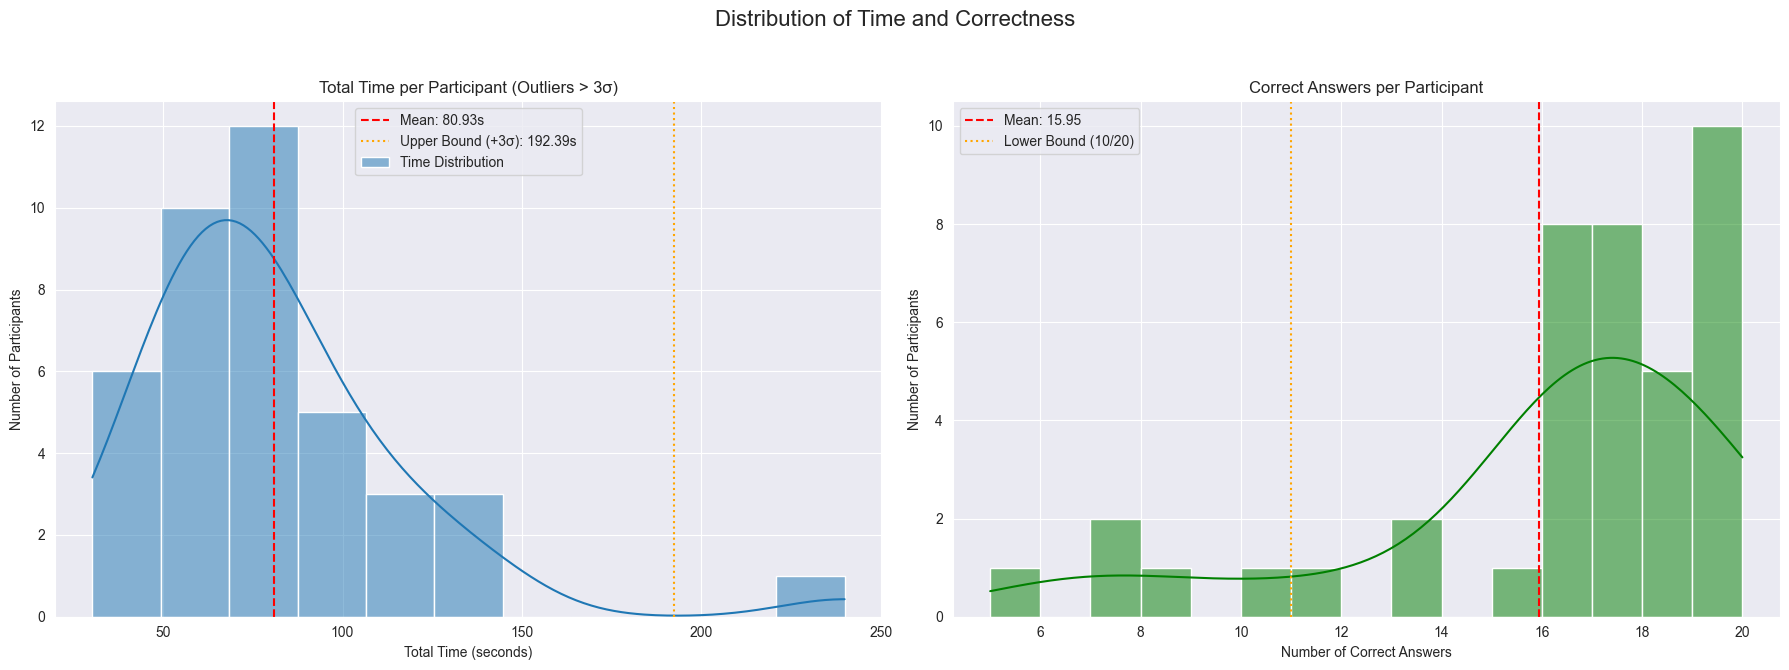

Time analysis: 1 participant(s) found as outliers outside of 3 standard deviations from the mean (80.93s).
Outlier participant(s) by ID and their total time:
       ID  (Time, mean)
16  31195       239.875

Correctness analysis: 5 participant(s) found as outliers below 11/20).
Outlier participant(s) by ID and their counts of correct answers:
       ID  (CorrectAnswer, count_nonzero)
4   12663                               7
5   13020                               7
11  24280                               5
15  29206                              10
16  31195                               8


In [22]:
aggregation_computation: dict[str, str] = {
    'CorrectAnswer': [np.count_nonzero, ],
    'TypeAnnotation': ['count', ],
    'Time': ['mean', 'median', 'min', 'max', 'sum', ],
}

overview_correctness_time: DataFrame = df_results_overall.groupby(['ID']).agg(aggregation_computation).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Distribution of Time and Correctness', fontsize=16)

# Plot 1: Time Distribution
time_std_threshold = 3
time_col = ('Time', 'mean')
mean_time = overview_correctness_time[time_col].mean()
std_time = overview_correctness_time[time_col].std()
upper_bound_time = mean_time + time_std_threshold * std_time
lower_bound_time = mean_time - time_std_threshold * std_time
outliers_time = overview_correctness_time[
    (overview_correctness_time[time_col] > upper_bound_time) | (overview_correctness_time[time_col] < lower_bound_time)]

sns.histplot(overview_correctness_time[time_col], kde=True, ax=axs[0], label='Time Distribution')
axs[0].set_title(f'Total Time per Participant (Outliers > {time_std_threshold}σ)')
axs[0].set_xlabel('Total Time (seconds)')
axs[0].set_ylabel('Number of Participants')
axs[0].axvline(mean_time, color='red', linestyle='--', label=f'Mean: {mean_time:.2f}s')
axs[0].axvline(upper_bound_time, color='orange', linestyle=':',
               label=f'Upper Bound (+{time_std_threshold}σ): {upper_bound_time:.2f}s')
if lower_bound_time > 0:
    axs[0].axvline(lower_bound_time, color='orange', linestyle=':',
                   label=f'Lower Bound (-{time_std_threshold}σ): {lower_bound_time:.2f}s')
axs[0].legend()

# Plot 2: Correct Answer Distribution
correct_col = ('CorrectAnswer', 'count_nonzero')
mean_correct = overview_correctness_time[correct_col].mean()
std_correct = overview_correctness_time[correct_col].std()
lower_bound_correct = 11

# Create a boolean Series for filtering
is_outlier_correct = (overview_correctness_time[correct_col] < lower_bound_correct)
outliers_correct = overview_correctness_time[is_outlier_correct]

sns.histplot(overview_correctness_time[correct_col], kde=True, ax=axs[1], color='green', binwidth=1)
axs[1].set_title(f'Correct Answers per Participant')
axs[1].set_xlabel('Number of Correct Answers')
axs[1].set_ylabel('Number of Participants')
axs[1].axvline(mean_correct, color='red', linestyle='--', label=f'Mean: {mean_correct:.2f}')
axs[1].axvline(lower_bound_correct, color='orange', linestyle=':', label=f'Lower Bound (10/20)')
axs[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(
    f"Time analysis: {len(outliers_time)} participant(s) found as outliers outside of {time_std_threshold} standard deviations from the mean ({mean_time:.2f}s).")
if not outliers_time.empty:
    print("Outlier participant(s) by ID and their total time:")
    print(pd.concat([outliers_time['ID'], outliers_time[time_col]], axis=1))

print(
    f"\nCorrectness analysis: {len(outliers_correct)} participant(s) found as outliers below {lower_bound_correct}/20).")
if not outliers_correct.empty:
    print("Outlier participant(s) by ID and their counts of correct answers:")
    print(pd.concat([outliers_correct['ID'], outliers_correct[correct_col]], axis=1))

Remove participants 12663, 13020, 24280, 29206, 31195 because correctness below 11

In [23]:
outlier_participants: list[str] = ['12663', '13020', '24280', '29206', '31195']
overview_correctness_time = overview_correctness_time[~overview_correctness_time['ID'].isin(outlier_participants)]

df_results_overall = df_results_overall[~df_results_overall['ID'].isin(outlier_participants)]
df_personal_information = df_personal_information[~df_personal_information['ID'].isin(outlier_participants)]

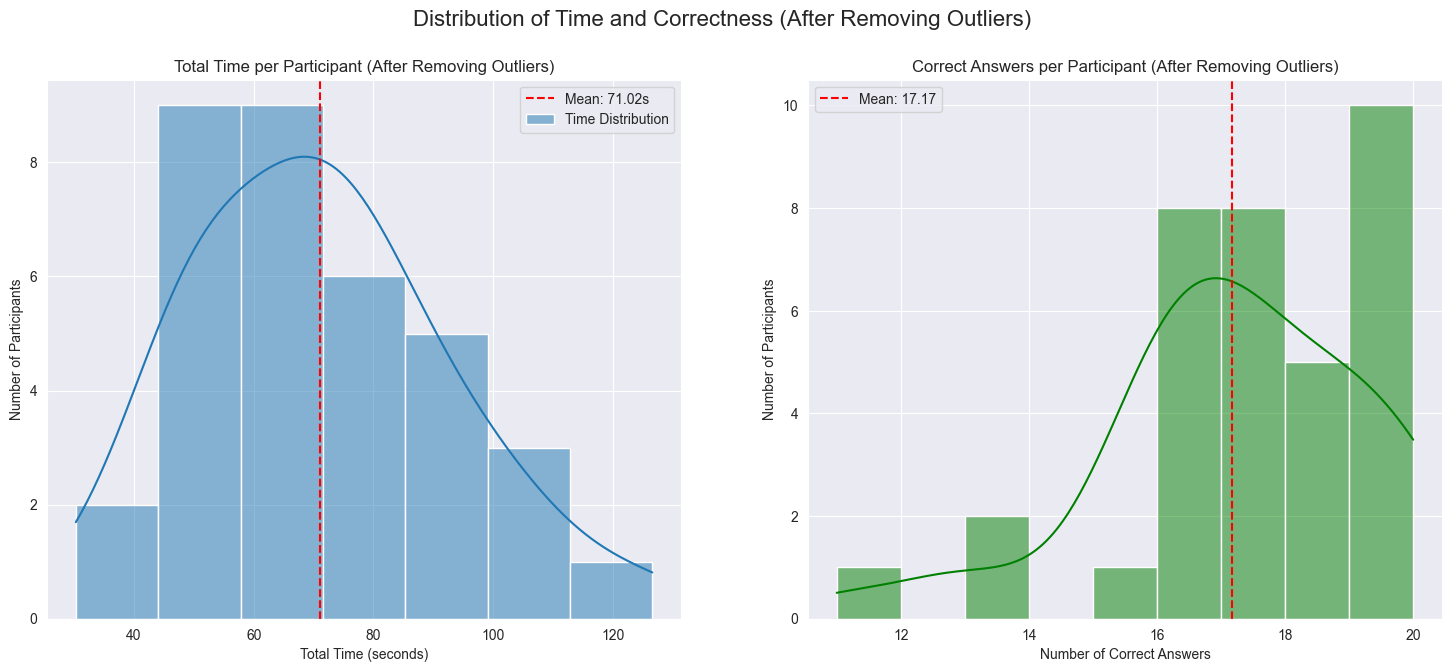

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Distribution of Time and Correctness (After Removing Outliers)', fontsize=16)
# Plot 1: Time Distribution
time_col = ('Time', 'mean')
mean_time = overview_correctness_time[time_col].mean()

sns.histplot(overview_correctness_time[time_col], kde=True, ax=axs[0], label='Time Distribution')
axs[0].set_title(f'Total Time per Participant (After Removing Outliers)')
axs[0].set_xlabel('Total Time (seconds)')
axs[0].set_ylabel('Number of Participants')
axs[0].axvline(mean_time, color='red', linestyle='--', label=f'Mean: {mean_time:.2f}s')
axs[0].legend()

# Plot 2: Correct Answer Distribution
correct_col = ('CorrectAnswer', 'count_nonzero')
mean_correct = overview_correctness_time[correct_col].mean()

sns.histplot(overview_correctness_time[correct_col], kde=True, ax=axs[1], color='green', binwidth=1)
axs[1].set_title(f'Correct Answers per Participant (After Removing Outliers)')
axs[1].set_xlabel('Number of Correct Answers')
axs[1].set_ylabel('Number of Participants')
axs[1].axvline(mean_correct, color='red', linestyle='--', label=f'Mean: {mean_correct:.2f}')
axs[1].legend()

Now remove certain data points

In [25]:
# Drop rows with any NaN in Time, NumberOfFixations
df_results_overall = df_results_overall.dropna(
    subset=["Time", "NumberOfFixations"]
).copy()

In [26]:
# Add new column for true fixations per second
df_results_overall["TrueFixationsPerSecond"] = (
        df_results_overall["NumberOfFixations"] / df_results_overall["Time"]
)

In [27]:
# Max time (in seconds)
MAX_TIME = 300

#Min and Max number of fixations
MIN_FIX = 10
MAX_FIX = 1000

# Min and Max fixations per second
MIN_FPS = 0.5
MAX_FPS = 8

# Min Percentage HitsBlock
MIN_HITS_BLOCK = 0.7

# IQR bounds
def iqr_bounds(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return lower, upper

# Compute IQR bounds
fix_lo, fix_hi = iqr_bounds(df_results_overall["NumberOfFixations"])
fps_lo, fps_hi = iqr_bounds(df_results_overall["TrueFixationsPerSecond"])

print("Fix bounds:", fix_lo, fix_hi)
print("FPS bounds:", fps_lo, fps_hi)

mask_outliers = (
    # Absolute checks
        (df_results_overall["Time"] > MAX_TIME) |

        (df_results_overall["NumberOfFixations"] < MIN_FIX) |
        (df_results_overall["NumberOfFixations"] > MAX_FIX) |

        (df_results_overall["TrueFixationsPerSecond"] < MIN_FPS) |
        (df_results_overall["TrueFixationsPerSecond"] > MAX_FPS) |

        (df_results_overall["HitsBlock"] < MIN_HITS_BLOCK) |

        # IQR checks
        (df_results_overall["NumberOfFixations"] < fix_lo) |
        (df_results_overall["NumberOfFixations"] > fix_hi) |
        (df_results_overall["TrueFixationsPerSecond"] < fps_lo) |
        (df_results_overall["TrueFixationsPerSecond"] > fps_hi)
)


Fix bounds: -196.25 641.75
FPS bounds: 0.9713709677419367 6.381048387096772


In [28]:
# Individual criterion masks
masks = {
    'Time > MAX_TIME': df_results_overall["Time"] > MAX_TIME,
    'NumFix < MIN_FIX': df_results_overall["NumberOfFixations"] < MIN_FIX,
    'NumFix > MAX_FIX': df_results_overall["NumberOfFixations"] > MAX_FIX,
    'FPS < MIN_FPS': df_results_overall["TrueFixationsPerSecond"] < MIN_FPS,
    'FPS > MAX_FPS': df_results_overall["TrueFixationsPerSecond"] > MAX_FPS,
    'HitsBlock < MIN': df_results_overall["HitsBlock"] < MIN_HITS_BLOCK,
    'NumFix < IQR_low': df_results_overall["NumberOfFixations"] < fix_lo,
    'NumFix > IQR_high': df_results_overall["NumberOfFixations"] > fix_hi,
    'FPS < IQR_low': df_results_overall["TrueFixationsPerSecond"] < fps_lo,
    'FPS > IQR_high': df_results_overall["TrueFixationsPerSecond"] > fps_hi
}

# Print individual counts
print("Individual criterion removal counts:")
for name, mask in masks.items():
    count = mask.sum()
    pct = (count / len(df_results_overall)) * 100
    print(f"{name:25s}: {count:4d} ({pct:5.2f}%)")

# Total outliers
total_outliers = mask_outliers.sum()
print("\n" + "=" * 60)
print(f"{'Total outliers':25s}: {total_outliers:4d} ({(total_outliers/len(df_results_overall))*100:5.2f}%)")
print("=" * 60)

Individual criterion removal counts:
Time > MAX_TIME          :    0 ( 0.00%)
NumFix < MIN_FIX         :    8 ( 1.37%)
NumFix > MAX_FIX         :    4 ( 0.69%)
FPS < MIN_FPS            :   18 ( 3.09%)
FPS > MAX_FPS            :    0 ( 0.00%)
HitsBlock < MIN          :   22 ( 3.77%)
NumFix < IQR_low         :    0 ( 0.00%)
NumFix > IQR_high        :   26 ( 4.46%)
FPS < IQR_low            :   30 ( 5.15%)
FPS > IQR_high           :   17 ( 2.92%)

Total outliers           :   86 (14.75%)


In [29]:
# Store in dataframe
df_results_overall["Outlier"] = mask_outliers

# Check counts
print(df_results_overall["Outlier"].value_counts())


Outlier
False    497
True      86
Name: count, dtype: int64


In [30]:
df_results_overall[
    ['ID', 'Task', 'CorrectAnswer', 'Time', 'NumberOfFixations', 'TrueFixationsPerSecond', 'HitsBlock', 'Outlier',
     'HitsType', 'HitsReturnType', 'Meaningful', 'TypeAnnotation']]

,ID,Task,CorrectAnswer,Time,NumberOfFixations,TrueFixationsPerSecond,HitsBlock,Outlier,HitsType,HitsReturnType,Meaningful,TypeAnnotation
0,10066,linearSearch,True,27,98.0,3.629630,0.540816,True,0.112245,0.000000,True,True
1,10066,crossSum,True,30,137.0,4.566667,0.846715,False,0.000000,0.007299,True,True
2,10066,forwardBackward,True,75,249.0,3.320000,0.943775,False,0.004016,0.000000,True,True
3,10066,unrolledSort,True,53,162.0,3.056604,0.932099,False,0.086420,0.000000,True,True
4,10066,validParentheses,True,128,532.0,4.156250,0.983083,False,0.000000,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
745,93795,bubbleSort,True,89,335.0,3.764045,0.973134,False,0.023881,0.020896,False,True
746,93795,commonChars,False,32,115.0,3.593750,0.991304,False,0.000000,0.000000,False,False
747,93795,factorial,True,8,18.0,2.250000,0.944444,False,0.000000,0.000000,False,False
748,93795,unrolledSort,True,32,120.0,3.750000,0.933333,False,0.000000,0.000000,False,False


In [31]:
# drop outliers
df_results_overall = df_results_overall[~df_results_overall["Outlier"]].copy()

In [32]:
# df with only id, task, correctanswer, time, number of fixations, true fixations per second
df_analysis = df_results_overall[
    ['ID', 'Task', 'CorrectAnswer', 'Time', 'NumberOfFixations', 'TrueFixationsPerSecond', 'HitsBlock', 'Difficulty',
     'HitsType', 'HitsReturnType', 'Meaningful', 'TypeAnnotation']]
df_analysis

,ID,Task,CorrectAnswer,Time,NumberOfFixations,TrueFixationsPerSecond,HitsBlock,Difficulty,HitsType,HitsReturnType,Meaningful,TypeAnnotation
1,10066,crossSum,True,30,137.0,4.566667,0.846715,1,0.000000,0.007299,True,True
2,10066,forwardBackward,True,75,249.0,3.320000,0.943775,1,0.004016,0.000000,True,True
3,10066,unrolledSort,True,53,162.0,3.056604,0.932099,1,0.086420,0.000000,True,True
4,10066,validParentheses,True,128,532.0,4.156250,0.983083,1,0.000000,0.000000,True,False
5,10066,squareRoot,True,49,209.0,4.265306,0.966507,1,0.000000,0.000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
744,93795,arrayAverage,True,74,294.0,3.972973,0.976190,2,0.000000,0.000000,False,False
745,93795,bubbleSort,True,89,335.0,3.764045,0.973134,3,0.023881,0.020896,False,True
746,93795,commonChars,False,32,115.0,3.593750,0.991304,3,0.000000,0.000000,False,False
747,93795,factorial,True,8,18.0,2.250000,0.944444,1,0.000000,0.000000,False,False


In [33]:
print(len(df_analysis['ID'].value_counts()))
# print number of particpants in meaningful and obfuscated group
print("Number of participants in meaningful group:", df_analysis.loc[df_analysis["Meaningful"] == True, "ID"].nunique())
print("Unique participants in obfuscated group:", df_analysis.loc[df_analysis["Meaningful"] == False, "ID"].nunique())

# print number of tasks for meaningful and obfuscated group
print(f'Number of tasks in meaningful group: {len(df_analysis[df_analysis["Meaningful"] == True])}')
print(f'Number of tasks in obfuscated group: {len(df_analysis[df_analysis["Meaningful"] == False])}')

# print number of tasks in TA and NoTA group
print(f'Number of tasks in TA group: {len(df_analysis[df_analysis["TypeAnnotation"] == True])}')
print(f'Number of tasks in NoTA group: {len(df_analysis[df_analysis["TypeAnnotation"] == False])}')

31
Number of participants in meaningful group: 14
Unique participants in obfuscated group: 17
Number of tasks in meaningful group: 238
Number of tasks in obfuscated group: 259
Number of tasks in TA group: 255
Number of tasks in NoTA group: 242


Describe Data

In [34]:
# mean time and sd
mean_time = df_analysis['Time'].mean()
std_time = df_analysis['Time'].std()
print(f'Mean Time: {mean_time:.1f} seconds, SD: {std_time:.1f} seconds')

# mean time meaningful
mean_time_meaningful = df_analysis[df_analysis['Meaningful'] == True]['Time'].mean()
std_time_meaningful = df_analysis[df_analysis['Meaningful'] == True]['Time'].std()
print(f'Mean Time Meaningful: {mean_time_meaningful:.1f} seconds, SD: {std_time_meaningful:.1f} seconds')

# mean time obfuscated
mean_time_obfuscated = df_analysis[df_analysis['Meaningful'] == False]['Time'].mean()
std_time_obfuscated = df_analysis[df_analysis['Meaningful'] == False]['Time'].std()
print(f'Mean Time Obfuscated: {mean_time_obfuscated:.1f} seconds, SD: {std_time_obfuscated:.1f} seconds')

# number of meaningful tasks correct
num_meaningful_tasks = len(df_analysis[df_analysis['Meaningful'] == True])
num_correct_meaningful = len(df_analysis[(df_analysis['Meaningful'] == True) & (df_analysis['CorrectAnswer'] == True)])
print(f'Number of Correct Meaningful Tasks: {num_correct_meaningful} out of {num_meaningful_tasks} ({(num_correct_meaningful/num_meaningful_tasks)*100:.1f}%)')

# number of obfuscated tasks correct
num_obfuscated_tasks = len(df_analysis[df_analysis['Meaningful'] == False])
num_correct_obfuscated = len(df_analysis[(df_analysis['Meaningful'] == False) & (df_analysis['CorrectAnswer'] == True)])
print(f'Number of Correct Obfuscated Tasks: {num_correct_obfuscated} out of {num_obfuscated_tasks} ({(num_correct_obfuscated/num_obfuscated_tasks)*100:.1f}%)')

Mean Time: 64.2 seconds, SD: 36.7 seconds
Mean Time Meaningful: 63.0 seconds, SD: 36.6 seconds
Mean Time Obfuscated: 65.3 seconds, SD: 36.8 seconds
Number of Correct Meaningful Tasks: 207 out of 238 (87.0%)
Number of Correct Obfuscated Tasks: 222 out of 259 (85.7%)


AOI Analysis

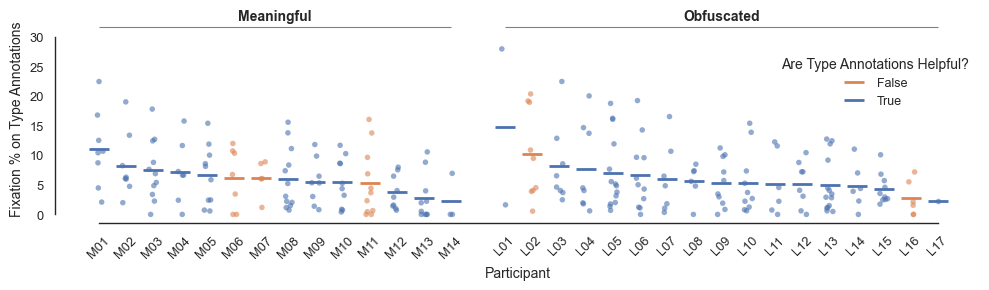

In [35]:
df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].dropna().astype(float)
df_results_overall['DifficultyNumeric'] = df_results_overall['DifficultyNumeric'].apply(lambda x: x / 5)
df_results_overall['OverallExperienceNumeric'] = df_results_overall['OverallExperience'].dropna().astype(float)
df_results_overall['OverallExperienceNumeric'] = df_results_overall['OverallExperienceNumeric'].apply(lambda x: x / 5)
df_results_overall['HitsTypePct'] = df_results_overall['HitsType'] * 100
df_results_overall['HitsReturnTypePct'] = df_results_overall['HitsReturnType'] * 100
df_results_overall['HitsTypeCombinedPct'] = df_results_overall['HitsTypePct'] + df_results_overall['HitsReturnTypePct']

# Aggregate only snippets with TA
df_type = df_results_overall[df_results_overall['TypeAnnotation'] == True]

# Sort tasks by HitsTypeCombinedPct
df_type = df_type.sort_values('HitsTypeCombinedPct', ascending=False)

# Compute mean per participant
mean_order = (
    df_type.groupby('ID')['HitsTypeCombinedPct']
    .mean()
    .sort_values(ascending=False)
    .index
)

# map each participant in meaningful_participants to another id for the plot starting with M like M01 M02 etc. and for obfuscated use L03 L04 etc.
# create a plot-only ID mapping (Mxx if any Meaningful==True for that ID, otherwise Lxx)
df_plot = df_type.copy()
unique_ids = mean_order.tolist()

label_map = {}
m_count = 1
l_count = 1
for uid in unique_ids:
    is_meaningful = df_plot.loc[df_plot['ID'] == uid, 'Meaningful'].fillna(False).any()
    if is_meaningful:
        label_map[uid] = f"M{m_count:02d}"
        m_count += 1
    else:
        label_map[uid] = f"L{l_count:02d}"
        l_count += 1

# add PlotID column and build order for plotting
df_plot['ID'] = df_plot['ID'].map(label_map)

# prepare order with a separator between M and L
m_labels = [label_map[uid] for uid in unique_ids if label_map[uid].startswith('M')]
l_labels = [label_map[uid] for uid in unique_ids if label_map[uid].startswith('L')]
sep_label = ''  # empty string used as separator (will produce a tick but no data)
plot_order = m_labels + [sep_label] + l_labels

# add one dummy row per hue with the separator label and NaN y so a gap appears
dummy_rows = []
for hue_val in df_plot['TAComprehension'].dropna().unique():
    dummy_rows.append({
        'PlotID': sep_label,
        'HitsTypeCombinedPct': np.nan,
        'TAComprehension': hue_val
    })
df_plot_with_sep = pd.concat([df_plot, pd.DataFrame(dummy_rows)], ignore_index=True)

# --- Describe data before filtering participants ---

# Count number of datapoints per participant
df_counts = df_plot_with_sep.copy()

# Plot using the sorted order
# Publication styling
sns.set_style('white')
sns.set_context('paper', font_scale=1.05)

palette = {1.0: '#4C72B0', 0.0: '#DD8452'}

fig, ax = plt.subplots(figsize=(10, 3))

# point estimates
sns.pointplot(
    data=df_plot,
    x='ID',
    y='HitsTypeCombinedPct',
    hue='TAComprehension',
    order=plot_order,
    dodge=0,
    linestyle='none',
    errorbar=None,
    palette=palette,
    markers='_',
    markersize=15,
    markeredgewidth=2,
    ax=ax
)

# overlay raw observations (small, semi-transparent)
sns.stripplot(
    data=df_plot,
    x='ID',
    y='HitsTypeCombinedPct',
    hue='TAComprehension',
    order=plot_order,
    dodge=False,
    jitter=0.15,
    size=4,
    alpha=0.6,
    palette=palette,
    linewidth=0,
    ax=ax
)

# remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
# keep only the first pair of legend entries (one per hue)
unique = {}
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
ax.legend(unique.values(), unique.keys(), title='Are Type Annotations Helpful?', frameon=False, loc='upper right', fontsize=9, bbox_to_anchor=(1, 0.85))

# Add group labels above each participant group (aligned)
# Current y-axis limits
ymin, ymax = ax.get_ylim()

# Vertical placement for labels and lines
label_y = ymax * 1.1
line_y = ymax * 1.08

# Compute exact start/end indices for groups
m_start = 0
m_end = len(m_labels) - 1
l_start = len(m_labels) + 1  # skip separator tick
l_end = l_start + len(l_labels) - 1

# Compute group centers for label placement
m_center = (m_start + m_end) / 2
l_center = (l_start + l_end) / 2

# Add text labels
ax.text(m_center, label_y, 'Meaningful',
        ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.text(l_center, label_y, 'Obfuscated',
        ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal lines
ax.hlines(line_y, m_start, m_end, color='gray', lw=0.8)
ax.hlines(line_y, l_start, l_end, color='gray', lw=0.8)

ax.set_ylim(ymin, ymax * 1.15)

# aesthetics for publication
ax.set_xlabel('Participant')
ax.set_ylabel('Fixation % on Type Annotations')
plt.xticks(rotation=45)
sns.despine(trim=True)
plt.tight_layout()

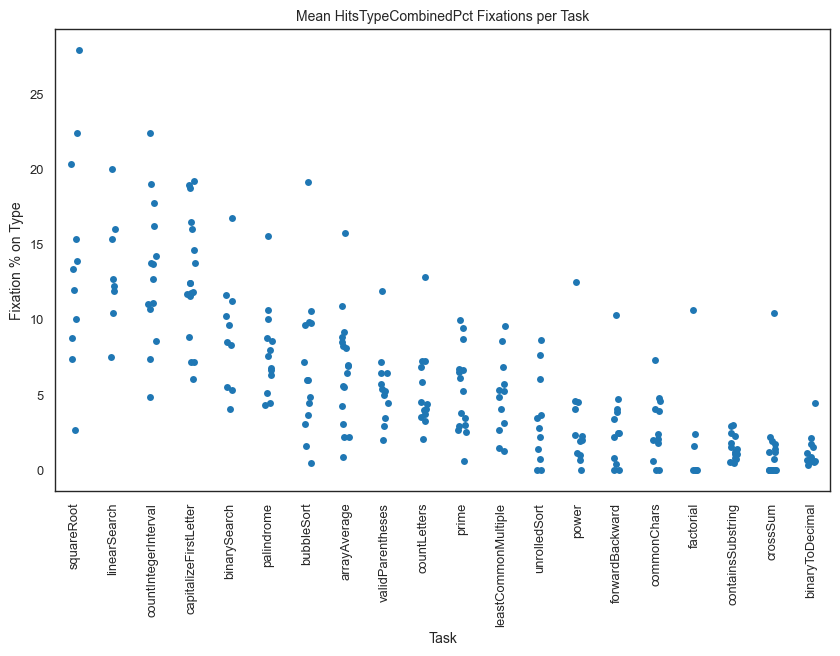

In [36]:
task_order = (
    df_type.groupby('Task')['HitsTypeCombinedPct']
    .mean()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_type, x='Task', y='HitsTypeCombinedPct', order=task_order)
plt.title('Mean HitsTypeCombinedPct Fixations per Task')
plt.ylabel('Fixation % on Type')
plt.xlabel('Task')
plt.xticks(rotation=90)
plt.show()


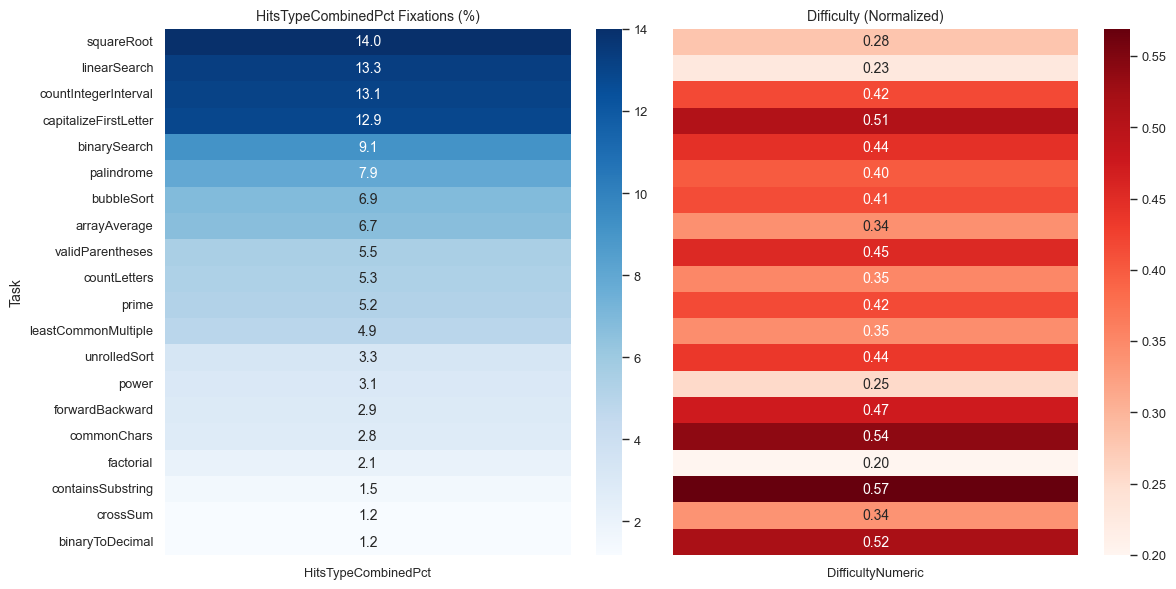

In [37]:
# Aggregate per task
df_task = df_type.groupby('Task')[['HitsTypeCombinedPct', 'DifficultyNumeric', 'TAComprehension', 'YearsProgramming',
                                   'OverallExperienceNumeric']].mean().reset_index()

df_task_sorted = df_task.sort_values('HitsTypeCombinedPct', ascending=False)

# HitsType + Difficulty side by side
df_task_heat = df_task_sorted.set_index('Task')[['HitsTypeCombinedPct', 'DifficultyNumeric']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

# HitsType heatmap (Blue)
sns.heatmap(df_task_heat[['HitsTypeCombinedPct']], annot=True, fmt=".1f", cmap='Blues', cbar=True, ax=axes[0])
axes[0].set_title('HitsTypeCombinedPct Fixations (%)')
axes[0].set_ylabel('Task')
axes[0].set_xlabel('')

# Difficulty heatmap (Red)
sns.heatmap(df_task_heat[['DifficultyNumeric']], annot=True, fmt=".2f", cmap='Reds', cbar=True, ax=axes[1])
axes[1].set_title('Difficulty (Normalized)')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


Spearman correlation: ρ = -0.223, p = 0.2443


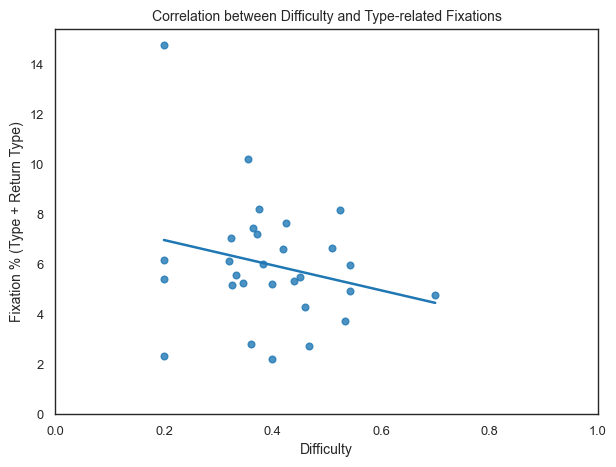

In [38]:
# Aggregate per participant
df_participant = df_type.groupby('ID')[
    ['HitsTypeCombinedPct', 'DifficultyNumeric', 'TAComprehension', 'YearsProgramming',
     'OverallExperienceNumeric']].mean().reset_index()

# HitsType vs Difficulty
df_corr = df_participant[['HitsTypeCombinedPct', 'DifficultyNumeric']].dropna()

# Spearman correlation
spearman_r, spearman_p = spearmanr(df_corr['HitsTypeCombinedPct'], df_corr['DifficultyNumeric'])
print(f"Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.4f}")

plt.figure(figsize=(7, 5))
sns.regplot(
    data=df_corr,
    x='DifficultyNumeric',
    y='HitsTypeCombinedPct',
    ci=None,
)
# Force axes to start from 0
plt.xlim(left=0, right=1.0)
plt.ylim(bottom=0)
plt.title('Correlation between Difficulty and Type-related Fixations')
plt.xlabel('Difficulty')
plt.ylabel('Fixation % (Type + Return Type)')
plt.show()


Spearman correlation: ρ = -0.327, p = 0.0131


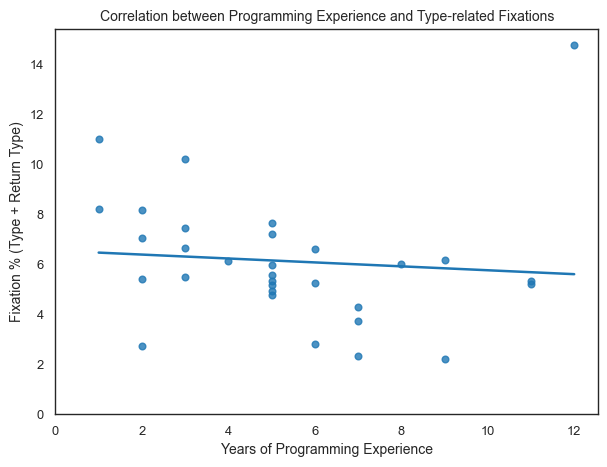

In [39]:
from scipy.stats import kendalltau

df_corr = df_participant[['HitsTypeCombinedPct', 'YearsProgramming']].dropna()

# Spearman correlation
spearman_r, spearman_p = kendalltau(df_corr['HitsTypeCombinedPct'], df_corr['YearsProgramming'])
print(f"Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.4f}")

plt.figure(figsize=(7, 5))
sns.regplot(
    data=df_corr,
    x='YearsProgramming',
    y='HitsTypeCombinedPct',
    ci=None,
)
# Force axes to start from 0
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Correlation between Programming Experience and Type-related Fixations')
plt.xlabel('Years of Programming Experience')
plt.ylabel('Fixation % (Type + Return Type)')
plt.show()


In [40]:
print(df_personal_information.CourseOfStudy.value_counts(normalize=True))

CourseOfStudy
Computer Science                            0.400000
Cybersecurity                               0.257143
Data Science and Artificial Intelligence    0.085714
Media Informatics                           0.085714
Embedded Systems                            0.057143
Mathematics and Computer Science            0.057143
Business Informatics                        0.028571
Computational Linguistics                   0.028571
Name: proportion, dtype: float64


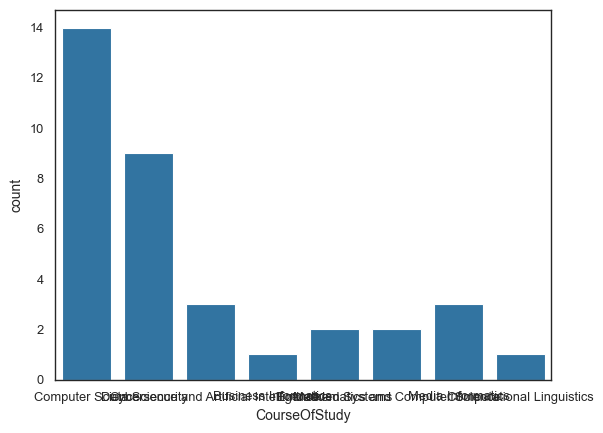

In [41]:
sns.countplot(df_personal_information, x='CourseOfStudy')
plt.show()


### People Distributions and Data

1. The age
2. Their experience
3. Their Course of Study

Mean Age: 23.0, SD: 3.8


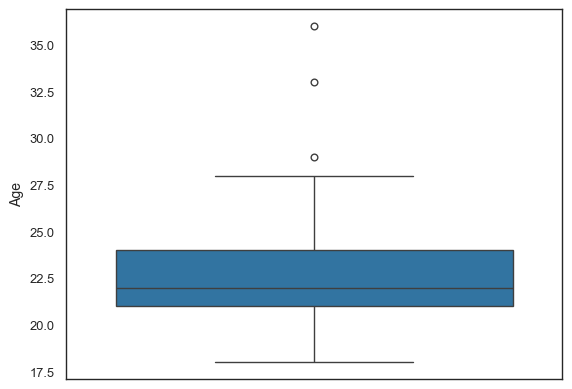

In [42]:
# average age and standard deviation
mean_age = df_personal_information['Age'].mean()
std_age = df_personal_information['Age'].std()
print(f'Mean Age: {mean_age:.1f}, SD: {std_age:.1f}')
sns.boxplot(data=df_personal_information, y='Age', )
plt.show()

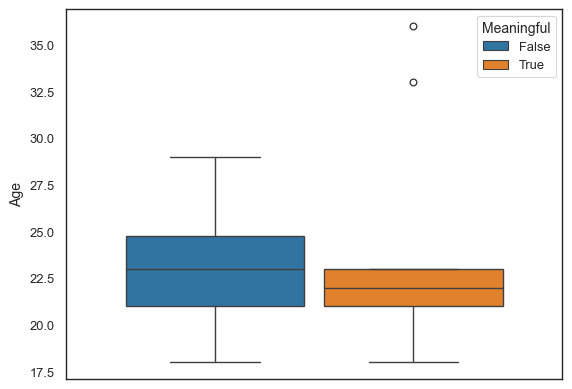

False -> Mean: 23.17, SD: 2.96
True -> Mean: 22.82, SD: 4.63


In [43]:
sns.boxplot(data=df_personal_information, y='Age', hue='Meaningful', gap=.1)
plt.show()

# Calculate mean and standard deviation
group_stats_age = df_personal_information.groupby('Meaningful')['Age'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats_age.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")




The courses of study

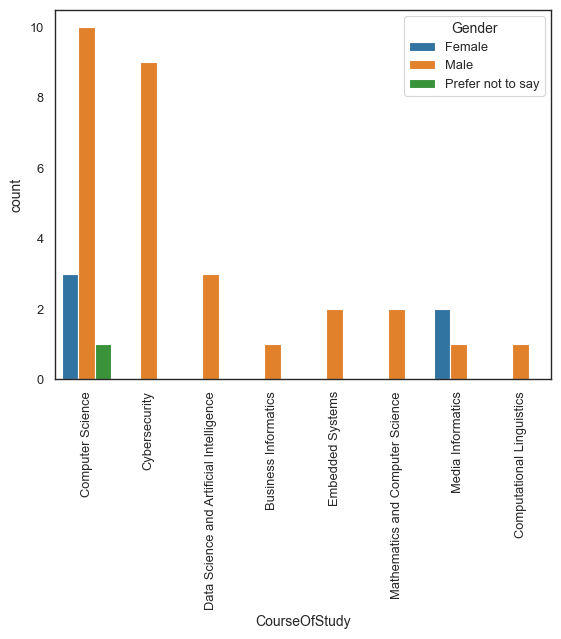

In [44]:
sns.countplot(data=df_personal_information, x='CourseOfStudy', hue='Gender')
plt.xticks(rotation=90)
plt.show()

The number of semesters

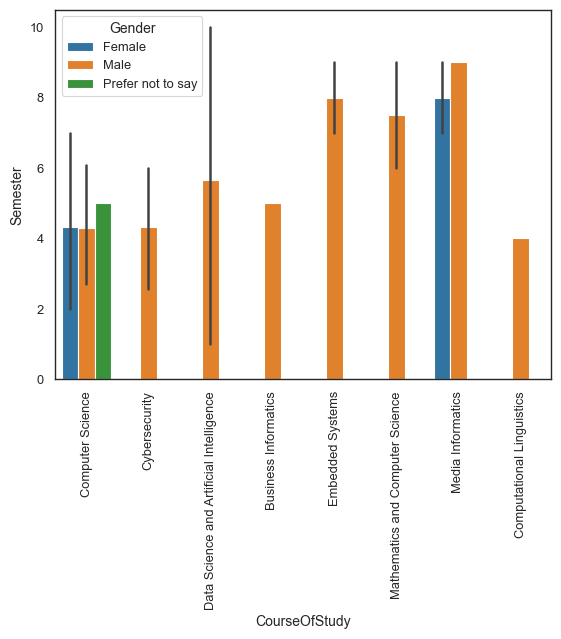

In [45]:
sns.barplot(data=df_personal_information, x='CourseOfStudy', hue='Gender', y='Semester')
plt.xticks(rotation=90)
plt.show()

The number of semesters in general

In [46]:
# mean semester and standard deviation
mean_semester = df_personal_information['Semester'].mean()
std_semester = df_personal_information['Semester'].std()
print(f'Mean Semester: {mean_semester:.2f}, SD: {std_semester:.2f}')

Mean Semester: 5.20, SD: 2.83


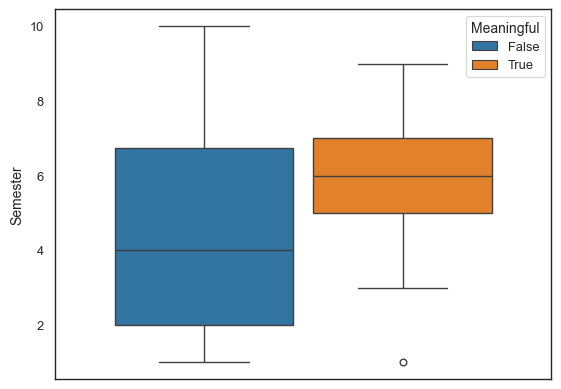

False -> Mean: 4.50, SD: 3.11
True -> Mean: 5.94, SD: 2.36


In [47]:
sns.boxplot(data=df_personal_information, y='Semester', hue='Meaningful', gap=.1, )
plt.show()

# Calculate mean and standard deviation
group_stats = df_personal_information.groupby('Meaningful')['Semester'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")

Classmates and overall experience

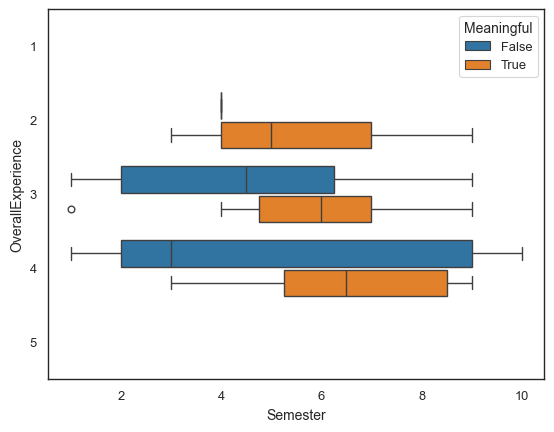

In [48]:
sns.boxplot(data=df_personal_information, y='OverallExperience', x='Semester', hue='Meaningful', gap=.1,
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced']
            )
plt.show()

Classmates

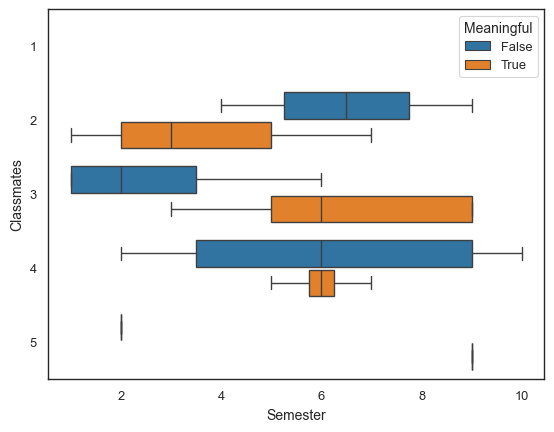

In [49]:
sns.boxplot(data=df_personal_information,
            y='Classmates',
            x='Semester',
            hue='Meaningful',
            gap=.1,
            # order=['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'],
            )
plt.show()

OverallExperience by ProgrammingLately

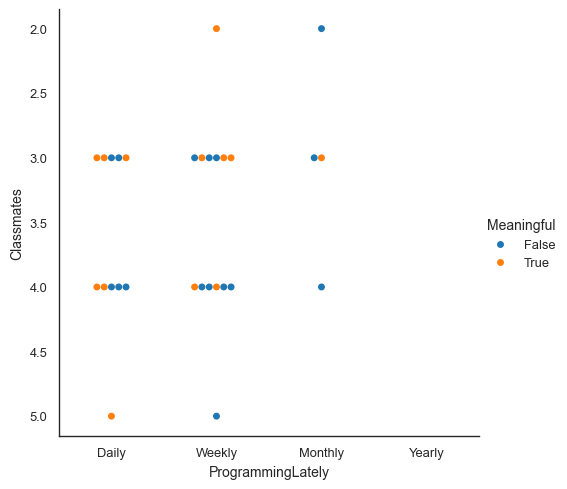

In [50]:
sns.catplot(data=df_personal_information,
            x='ProgrammingLately',
            y='Classmates',
            hue='Meaningful',
            # gap=.1,
            order=['Daily', 'Weekly', 'Monthly', 'Yearly'],
            kind='swarm'
            )
plt.show()

#### Standard Data for the personal information

In [51]:
print(f'Age:\n{df_personal_information["Age"].describe()}\n')
print(f'Semester:\n{df_personal_information["Semester"].describe()}\n')
print(f'YearsProgramming:\n{df_personal_information["YearsProgramming"].describe()}\n')
print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')

Age:
count    35.000000
mean     23.000000
std       3.804023
min      18.000000
25%      21.000000
50%      22.000000
75%      24.000000
max      36.000000
Name: Age, dtype: float64

Semester:
count    35.000000
mean      5.200000
std       2.826347
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      10.000000
Name: Semester, dtype: float64

YearsProgramming:
count    35.000000
mean      5.228571
std       2.901173
min       1.000000
25%       3.000000
50%       5.000000
75%       7.000000
max      12.000000
Name: YearsProgramming, dtype: float64

Gender:
                   Gender
Gender                   
Female                  5
Male                   29
Prefer not to say       1

Classmates:
            Classmates
Classmates            
1                    0
2                    5
3                   16
4                   12
5                    2



/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1011207774.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby("Gender").agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1011207774.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Classmates:\n{df_personal_information.groupby("Classmates").agg({"Classmates": "count"})}\n')


Standard Data for personal information divided by Meaningful Data

In [52]:
print(f'Age:\n{df_personal_information.groupby("Meaningful").agg({"Age": ["mean", "std"]})}')
print(f'Semester:\n{df_personal_information.groupby("Meaningful").agg({"Semester": ["mean", "std"]})}\n')
print(
    f'YearsProgramming:\n{df_personal_information.groupby("Meaningful").agg({"YearsProgramming": ["mean", "std"]})}\n')
print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')
print(f'StudyBefore:\n{df_personal_information.groupby(["Meaningful", "StudyBefore"]).agg({"StudyBefore": "count"})}\n')

Age:
                  Age          
                 mean       std
Meaningful                     
False       23.166667  2.955553
True        22.823529  4.626490
Semester:
            Semester          
                mean       std
Meaningful                    
False       4.500000  3.110703
True        5.941176  2.357716

YearsProgramming:
           YearsProgramming          
                       mean       std
Meaningful                           
False              5.444444  3.329409
True               5.000000  2.449490

Gender:
                              Gender
Meaningful Gender                   
False      Female                  3
           Male                   15
           Prefer not to say       0
True       Female                  2
           Male                   14
           Prefer not to say       1

EyeSight:
                                                             Eyesight
Meaningful Eyesight                                                  
False

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2921099811.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'Gender:\n{df_personal_information.groupby(["Meaningful", "Gender"]).agg({"Gender": "count"})}\n')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2921099811.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(f'EyeSight:\n{df_personal_information.groupby(["Meaningful", "Eyesight"]).agg({"Eyesight": "count"})}\n')


Efficacy for every participant:


Efficacy of Participant ('10066', False): 1.1739130434782608
Efficacy of Participant ('10066', True): 1.3129102844638951
Efficacy of Participant ('10723', False): 0.6837606837606838
Efficacy of Participant ('10723', True): 0.683111954459203
Efficacy of Participant ('10920', False): 1.3399503722084367
Efficacy of Participant ('10920', True): 1.375
Efficacy of Participant ('14296', False): 0.8130081300813008
Efficacy of Participant ('14296', True): 0.6629834254143646
Efficacy of Participant ('18457', False): 0.7733619763694951
Efficacy of Participant ('18457', True): 0.7877461706783371
Efficacy of Participant ('18868', False): 0.8888888888888888
Efficacy of Participant ('18868', True): 0.8032128514056225
Efficacy of Participant ('23993', False): 1.0183875530410185
Efficacy of Participant ('23993', True): 0.675422138836773
Efficacy of Participant ('24341', False): 0.4851752021563342
Efficacy of Participant ('24341', True): 0.7317073170731707
Efficacy of Participant ('25574', False): 0.812

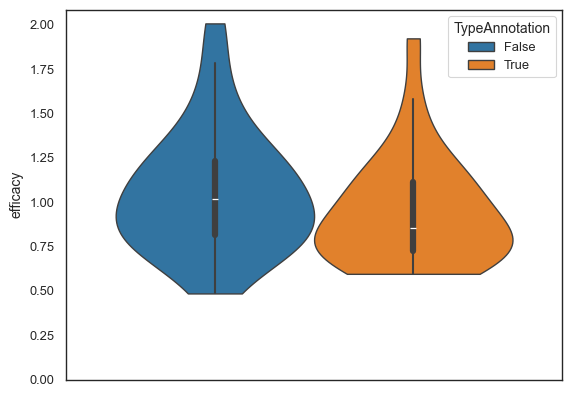

In [53]:
df = df_results_overall.groupby(['ID', 'TypeAnnotation']).agg({'Time': 'sum', 'CorrectAnswer': 'count'})
df['efficacy'] = df.CorrectAnswer / (df.Time / 60)
# df.columns.droplevel(0)
# print(df)
for index, row in df.iterrows():
    print(f'Efficacy of Participant {index}: {row.CorrectAnswer / (row.Time / 60)}')

sns.violinplot(df, y='efficacy', hue='TypeAnnotation', cut=0)
plt.ylim(bottom=0)
plt.show()

Statistical Methods one after the other

In [54]:



def compute_statistics(data: DataFrame, with_TA, without_TA, input_type: str = 'continuous',
                       output_type: str = 'contiuous', population: str = 'within', p_value: float = 0.05):
    # input_dependence: str = 'independent',

    # check for normality
    with_TA_normality = stats.shapiro(with_TA)
    without_TA_normality = stats.shapiro(without_TA)

    # print(with_TA)
    # print(without_TA)

    # check for homogeneity of variance
    homogeneity_of_variance = stats.levene(with_TA, without_TA)
    # print(homogeneity_of_variance)

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value:
        print(
            f'Both groups are normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')
    else:
        print(
            f'At least one group is not normally distributed with pvalues {with_TA_normality.pvalue} and {without_TA_normality.pvalue}')

    if homogeneity_of_variance.pvalue > p_value:
        print(f'Both groups have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')
    else:
        print(f'Both groups do not have homogeneity of variance with pvalue {homogeneity_of_variance.pvalue}')

    if with_TA_normality.pvalue > p_value and without_TA_normality.pvalue > p_value and homogeneity_of_variance.pvalue > p_value:
        if population == 'within':
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_REL: {stats.ttest_rel(without_TA, with_TA)}')
            elif input_type == 'categorical' and output_type == 'categorical':
                print(f'CHISQUARE: {stats.chisquare(without_TA, with_TA)}')
            elif len(with_TA) == len(without_TA):
                print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
                print(f'WILCOXON ONE-SIDED Greater: {stats.wilcoxon(without_TA, with_TA, alternative="greater")}')
                print(f'WILCOXON ONE-SIDED Less: {stats.wilcoxon(without_TA, with_TA, alternative="less")}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

        else:
            if input_type == 'categorical' and output_type == 'continuous':
                print(f'TTEST_IND: {stats.ttest_ind(without_TA, with_TA)}')
            else:
                print(f'MANNWHITNEYU: {stats.mannwhitneyu(without_TA, with_TA)}')

    else:
        if population == 'within' and len(with_TA) == len(without_TA):
            print(f'WILCOXON TWO-SIDED: {stats.wilcoxon(without_TA, with_TA)}')
        elif input_type == 'categorical' and output_type == 'categorical':
            print(f'CHISQUARE: {stats.chi2_contingency(without_TA, with_TA)}')
        else:
            u_statistic, p_value = stats.mannwhitneyu(without_TA, with_TA)
            print(f'The U-statistic is {u_statistic} and the p-value is {p_value}')

    return data

#### Table for Type Annotations and Correctness RQ 1.1

Do everything correctly for time

1. Check for normality
2. Check for the variances
3. then check for wilcoxon two-sided
4. then check for wilcoxon one-sided


In [55]:
table_data: dict[str, list[str] | str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task']).agg(table_data)

TA_mean = df_results_overall.query('TypeAnnotation == True')['Time']
NoTA_mean = df_results_overall.query('TypeAnnotation == False')['Time']

# qq = stats.probplot(TA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

data = compute_statistics(table, TA_mean, NoTA_mean, input_type='categorical', output_type='continuous',
                          population='within')

# print(f'{TA_mean.describe()} and {NoTA_mean.describe()}')

# qq = stats.probplot(NoTA_mean, dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

print(f'Normality of TA:\n{stats.shapiro(TA_mean)}')
print(f'Normality of NoTA:\n{stats.shapiro(NoTA_mean)}')

print(f'Levene Test:\n{stats.levene(TA_mean, NoTA_mean)}')

# print(f'WILCOXON:\n{stats.wilcoxon(NoTA_mean, TA_mean)}')
# print(f'WILCOXON Longer with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="greater")}')
# print(f'WILCOXON Shorter with TA:\n{stats.wilcoxon(NoTA_mean, TA_mean, alternative="less")}')
for task_tuple, x in table.iterrows():
    print(
        f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"] / x.CorrectAnswer["count"]) * 100)}\%) & {round(x.Time["mean"], 2)} $\pm$ {round(x.Time["std"], 2)}\\\\')

print(
    f'{df_results_overall.Time.mean()} + {df_results_overall.Time.std()} | {df_results_overall.CorrectAnswer.sum()}/{df_results_overall.CorrectAnswer.count()} ({df_results_overall.CorrectAnswer.sum() / df_results_overall.CorrectAnswer.count()})')

At least one group is not normally distributed with pvalues 2.7118302246931447e-08 and 3.445881886137675e-10
Both groups have homogeneity of variance with pvalue 0.9271815163742849
The U-statistic is 27255.0 and the p-value is 0.024484588670748264
Normality of TA:
ShapiroResult(statistic=np.float64(0.9440557327354525), pvalue=np.float64(2.7118302246931447e-08))
Normality of NoTA:
ShapiroResult(statistic=np.float64(0.9192459720604419), pvalue=np.float64(3.445881886137675e-10))
Levene Test:
LeveneResult(statistic=np.float64(0.00836091770061534), pvalue=np.float64(0.9271815163742849))
arrayAverage & 27.0/27.0 (100\%) & 52.85 $\pm$ 21.79\\
binarySearch & 22.0/24.0 (92\%) & 88.04 $\pm$ 36.27\\
binaryToDecimal & 22.0/27.0 (81\%) & 72.48 $\pm$ 27.1\\
bubbleSort & 22.0/25.0 (88\%) & 74.0 $\pm$ 31.13\\
capitalizeFirstLetter & 27.0/27.0 (100\%) & 90.0 $\pm$ 33.11\\
commonChars & 16.0/26.0 (62\%) & 48.31 $\pm$ 22.7\\
containsSubstring & 19.0/26.0 (73\%) & 99.38 $\pm$ 45.52\\
countIntegerInterval 

<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:34: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2212381204.py:34: SyntaxWarning: invalid escape sequence '\%'
  f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"] / x.CorrectAnswer["count"]) * 100)}\%) & {round(x.Time["mean"], 2)} $\pm$ {round(x.Time["std"], 2)}\\\\')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2212381204.py:34: SyntaxWarning: invalid escape sequence '\p'
  f'{task_tuple} & {x.CorrectAnswer["sum"]}/{x.CorrectAnswer["count"]} ({round((x.CorrectAnswer["sum"] / x.CorrectAnswer["count"]) * 100)}\%) & {round(x.Time["mean"], 2)} $\pm$ {round(x.Time["std"], 2)}\\\\')


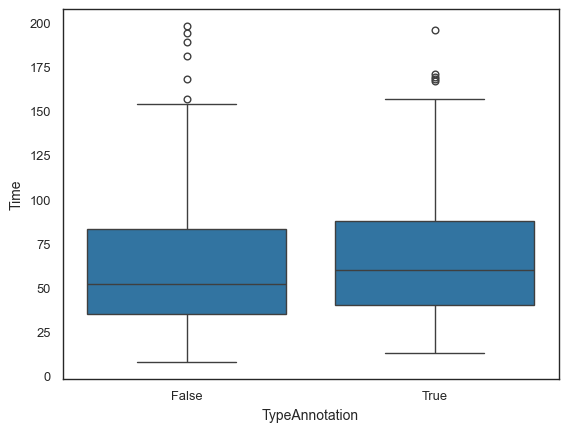

False -> Mean: 60.98, SD: 37.21
True -> Mean: 67.23, SD: 36.01


In [56]:
sns.boxplot(data=df_results_overall, y='Time', x='TypeAnnotation')
plt.show()

# Calculate mean and standard deviation
group_stats = df_results_overall.groupby('TypeAnnotation')['Time'].agg(['mean', 'std'])

# Print values
for group, group_data in group_stats.iterrows():
    print(f"{group} -> Mean: {group_data['mean']:.2f}, SD: {group_data['std']:.2f}")

Do the same as above for the correctness

In [57]:
# percentage_TA = table.query("TypeAnnotation == True")["Correctness"]
# percentage_NoTA = table.query("TypeAnnotation == False")["Correctness"]

# please create a contingency table for CorrectAnswer on TypeAnnotation

contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['CorrectAnswer'])
print(stats.chi2_contingency(contingency_table))
print(contingency_table)

try:
    data = compute_statistics(DataFrame(), df_results_overall.query("TypeAnnotation == True")["CorrectAnswer"],
                              df_results_overall.query("TypeAnnotation == False")["CorrectAnswer"],
                              input_type='categorical', output_type='categorical', population='within')
except:
    pass

print(df_results_overall.groupby('TypeAnnotation')['CorrectAnswer'].agg(['sum', 'count']))

Chi2ContingencyResult(statistic=np.float64(1.4496873878113328), pvalue=np.float64(0.2285781203971361), dof=1, expected_freq=array([[ 33.11066398, 208.88933602],
       [ 34.88933602, 220.11066398]]))
CorrectAnswer   False  True 
TypeAnnotation              
False              28    214
True               40    215
At least one group is not normally distributed with pvalues 1.405433048007455e-27 and 3.878396322446417e-28
Both groups have homogeneity of variance with pvalue 0.18271746504011108
                sum  count
TypeAnnotation            
False           214    242
True            215    255


In [58]:
# Calculate correctness values for TA and NoTA
ta_correct = df_results_overall[df_results_overall['TypeAnnotation'] == True]['CorrectAnswer'].sum()
ta_total = len(df_results_overall[df_results_overall['TypeAnnotation'] == True])
ta_percent = round((ta_correct / ta_total) * 100)

nota_correct = df_results_overall[df_results_overall['TypeAnnotation'] == False]['CorrectAnswer'].sum()
nota_total = len(df_results_overall[df_results_overall['TypeAnnotation'] == False])
nota_percent = round((nota_correct / nota_total) * 100)

all_correct = df_results_overall['CorrectAnswer'].sum()
all_total = len(df_results_overall)
all_percent = round((all_correct / all_total) * 100)

# Print LaTeX commands
print("% The general correctness values for TA and without")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllTATotal}}{{{ta_total}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllTACorrect}}{{{ta_correct}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessTAPercent}}{{{ta_percent}\\%}}")
print()
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllNoTATotal}}{{{nota_total}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllNoTACorrect}}{{{nota_correct}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessNoTAPercent}}{{{nota_percent}\\%}}")
print()
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllTotal}}{{{all_total}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessAllCorrect}}{{{all_correct}}}")
print(f"\\newcommand{{\\rqOneOneGeneralCorrectnessPercent}}{{{all_percent}\\%}}")

% The general correctness values for TA and without
\newcommand{\rqOneOneGeneralCorrectnessAllTATotal}{255}
\newcommand{\rqOneOneGeneralCorrectnessAllTACorrect}{215}
\newcommand{\rqOneOneGeneralCorrectnessTAPercent}{84\%}

\newcommand{\rqOneOneGeneralCorrectnessAllNoTATotal}{242}
\newcommand{\rqOneOneGeneralCorrectnessAllNoTACorrect}{214}
\newcommand{\rqOneOneGeneralCorrectnessNoTAPercent}{88\%}

\newcommand{\rqOneOneGeneralCorrectnessAllTotal}{497}
\newcommand{\rqOneOneGeneralCorrectnessAllCorrect}{429}
\newcommand{\rqOneOneGeneralCorrectnessPercent}{86\%}


#### Measures for RQ 1.2

First we should check for VerticalNext, VerticalLater, Regression, HorizontalLater, and LineRegression

But first let's create the table to analyze

In [59]:
list_measure: list[str] = ['VerticalNext', 'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression',
                           'StoryOrder_Naive_Score', 'StoryOrder_Dynamic_Score', 'StoryOrder_Dynamic_Repetitions',
                           'SaccadeLength']

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg(table_data)
table.dropna(inplace=True)

In [60]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    data = compute_statistics(table, df_results_overall.query("TypeAnnotation == True")[measure].dropna(),
                              df_results_overall.query("TypeAnnotation == False")[measure].dropna(),
                              input_type='categorical', output_type='continuous', population='within')


Measure: VerticalNext
At least one group is not normally distributed with pvalues 0.00017583826313765974 and 1.0440634859267652e-13
Both groups have homogeneity of variance with pvalue 0.514900715562572
The U-statistic is 31756.5 and the p-value is 0.5734182706074844

Measure: VerticalLater
At least one group is not normally distributed with pvalues 9.61869528344382e-05 and 1.8743495103338833e-10
Both groups have homogeneity of variance with pvalue 0.41336725981543976
The U-statistic is 33291.5 and the p-value is 0.12794976125223398

Measure: Regression
At least one group is not normally distributed with pvalues 4.912039249520172e-05 and 0.04966518135286383
Both groups have homogeneity of variance with pvalue 0.6109265193845275
The U-statistic is 31859.0 and the p-value is 0.530610510143566

Measure: HorizontalLater
At least one group is not normally distributed with pvalues 0.0180122543576625 and 0.0004184873378084467
Both groups have homogeneity of variance with pvalue 0.18925497572

#### Measures for RQ 1.3

This should include:

1. The difficulty for each of the snippets as giving by the people.
2. Did the Type Annotations help with the snippets?
3. Do Type Annotations help in general?

Do a likert scale analysis of the difficulty 

<Figure size 1000x600 with 0 Axes>

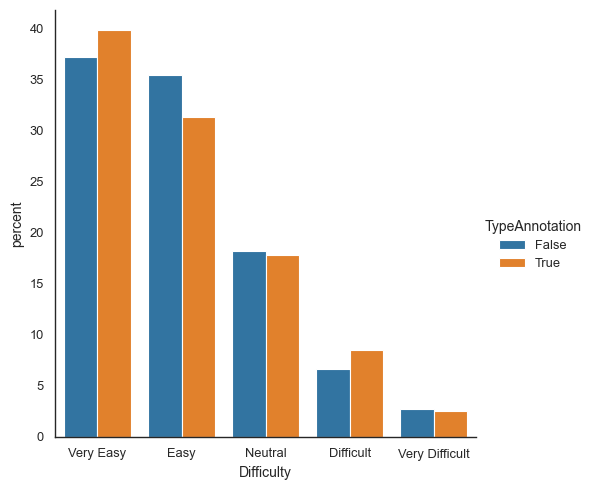

In [61]:
df1 = df_results_overall.groupby('TypeAnnotation')['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty',
            hue='TypeAnnotation',
            data=df1,
            kind='bar',
            y='percent',
            #legend=False,
            )

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Type Annotation')
# plt.legend(title='Type Annotation', loc='upper right', labels=['Non-Annotated', 'Annotated'])
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/rq13difficultyLikertCatPlot.pdf', bbox_inches='tight')
plt.show()

And now with meaningful

    Meaningful  TypeAnnotation Difficulty    percent
10        True           False          2  37.500000
11        True           False          1  35.714286
12        True           False          3  16.964286
13        True           False          4   8.928571
14        True           False          5   0.892857
15        True            True          1  48.648649
16        True            True          2  30.630631
17        True            True          3  13.513514
18        True            True          4   7.207207
19        True            True          5   0.000000


<Figure size 1000x600 with 0 Axes>

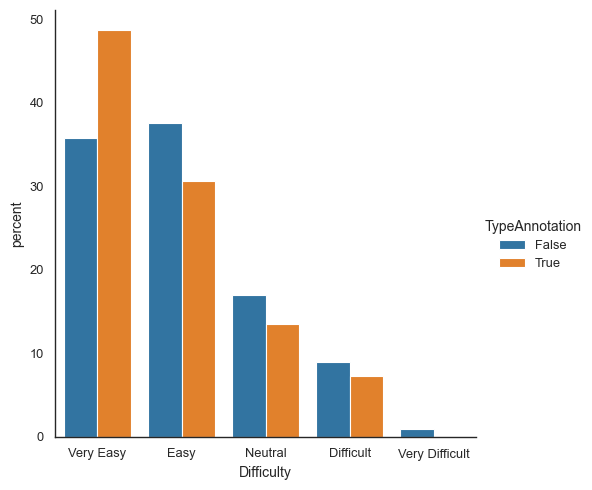

In [62]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1[df1['Meaningful'] == True])

plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty',
            hue='TypeAnnotation',
            data=df1[df1['Meaningful'] == True],
            kind='bar',
            y='percent',
            )

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight', dpi=1200)
plt.show()

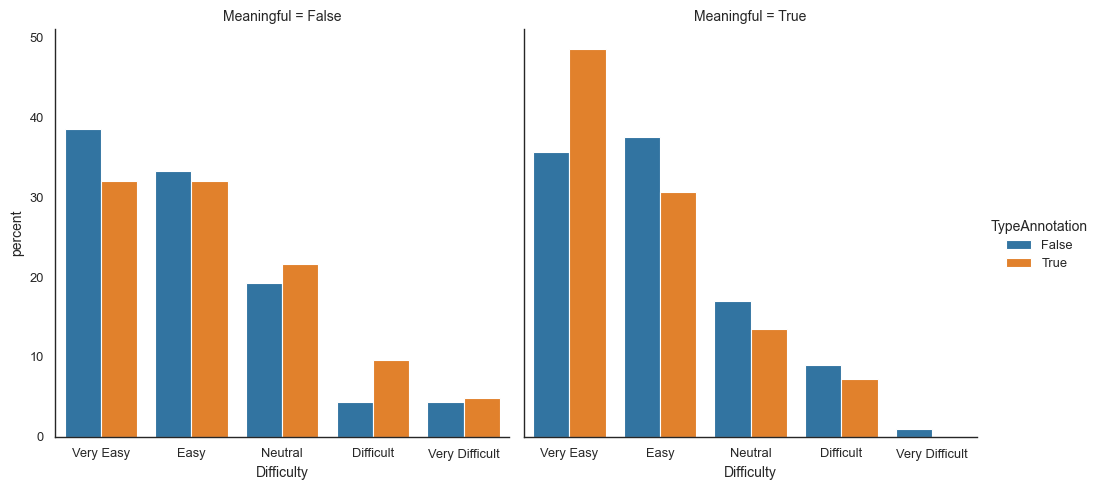

In [63]:
df1 = df_results_overall.groupby(['Meaningful', 'TypeAnnotation'])['Difficulty'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

# plt.figure(figsize=(10, 6))
# g = sns.FacetGrid(df1, col='Meaningful', hue='TypeAnnotation')
# g.map(sns.stripplot, 'Difficulty', 'percent', kind='bar')
sns.catplot(x='Difficulty',
            hue='TypeAnnotation',
            data=df1,
            kind='bar',
            y='percent',
            col='Meaningful',
            )

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
# plt.title('Difficulty grouped by Meaningful')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotCombined.pdf', bbox_inches='tight', dpi=1200)
plt.show()

And now both?

<Figure size 1000x600 with 0 Axes>

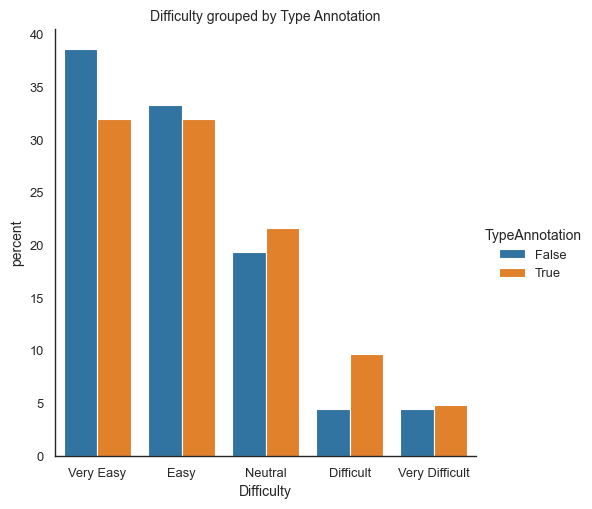

In [64]:
plt.figure(figsize=(10, 6))
sns.catplot(x='Difficulty',
            hue='TypeAnnotation',
            data=df1[df1['Meaningful'] == False],
            kind='bar',
            y='percent',
            )

plt.xticks(np.arange(5), ['Very Easy', 'Easy', 'Neutral', 'Difficult', 'Very Difficult'])
plt.title('Difficulty grouped by Type Annotation')
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotObfuscated.pdf', bbox_inches='tight')
plt.show()

Can we also find a statistical significance for this? using the chisquare test?

In [65]:
contingency_table = pd.crosstab(df_results_overall['TypeAnnotation'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(1.3060595751855846), pvalue=np.float64(0.8603465992057944), dof=4, expected_freq=array([[87.07359307, 75.33333333, 40.6017316 , 17.12121212,  5.87012987],
       [90.92640693, 78.66666667, 42.3982684 , 17.87878788,  6.12987013]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           84  80  41  15  6
True            94  74  42  20  6


In [66]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == True]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(4.615630614393463), pvalue=np.float64(0.32905598886999654), dof=4, expected_freq=array([[47.21076233, 38.17040359, 17.07623318,  9.04035874,  0.50224215],
       [46.78923767, 37.82959641, 16.92376682,  8.95964126,  0.49775785]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           40  42  19  10  1
True            54  34  15   8  0


In [67]:
cont_df = df_results_overall[df_results_overall['Meaningful'] == False]
contingency_table = pd.crosstab(cont_df['TypeAnnotation'], cont_df['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(3.2257814106872056), pvalue=np.float64(0.5207768984170069), dof=4, expected_freq=array([[40.06694561, 37.20502092, 23.37238494,  8.10878661,  5.24686192],
       [43.93305439, 40.79497908, 25.62761506,  8.89121339,  5.75313808]]))
Difficulty       1   2   3   4  5
TypeAnnotation                   
False           44  38  22   5  5
True            40  40  27  12  6


In [68]:
contingency_table = pd.crosstab(df_results_overall['Meaningful'], df_results_overall['Difficulty'])

print(stats.chi2_contingency(contingency_table))
print(contingency_table)

Chi2ContingencyResult(statistic=np.float64(11.119744134578912), pvalue=np.float64(0.02525071096919819), dof=4, expected_freq=array([[92.08225108, 79.66666667, 42.93722944, 18.10606061,  6.20779221],
       [85.91774892, 74.33333333, 40.06277056, 16.89393939,  5.79220779]]))
Difficulty   1   2   3   4   5
Meaningful                    
False       84  78  49  17  11
True        94  76  34  18   1


How about some significance for the Comprehension within the study?

In [69]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'],
                                df_personal_information['TAComprehensionGeneral'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(19.333333333333332), pvalue=np.float64(0.04736440030557677))
TAComprehensionGeneral  False  True 
TAComprehension                     
False                       2      3
True                        1     29


In [70]:
contingency_table = pd.crosstab(df_personal_information['TAComprehension'], df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(0.5833333333333334), pvalue=np.float64(0.6581483033095937))
Meaningful       False  True 
TAComprehension              
False                2      3
True                16     14


In [71]:
contingency_table = pd.crosstab(df_personal_information['TAComprehensionGeneral'],
                                df_personal_information['Meaningful'])

print(stats.fisher_exact(contingency_table))
print(contingency_table)

SignificanceResult(statistic=np.float64(2.0), pvalue=1.0)
Meaningful              False  True 
TAComprehensionGeneral              
False                       2      1
True                       16     16


Did the TA help with comprehension?

In [72]:
table_data: dict[str | list[str]] = {
    # 'Difficulty': ['mean'],
    'TAComprehension': [],
    # 'TAComprehensionGeneral': [],
}
print(df_personal_information.query('TAComprehension == False')['ID'])
df_personal_information['TAComprehension'].value_counts()

13    25574
33    60682
34    62039
37    74390
38    76211
Name: ID, dtype: object


TAComprehension
True     30
False     5
Name: count, dtype: int64

TA help with comprehension for Meaningful?

In [73]:
df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts()

Meaningful  TAComprehension
False       True               16
            False               2
True        True               14
            False               3
Name: count, dtype: int64

In [74]:
stats.chisquare(df_personal_information.groupby('Meaningful')['TAComprehension'].value_counts())

Power_divergenceResult(statistic=np.float64(18.142857142857146), pvalue=np.float64(0.00041099411091375976))

Do TA help in general?

In [75]:
print(df_personal_information.query('TAComprehensionGeneral == False')['ID'])

df_personal_information['TAComprehensionGeneral'].value_counts()

13    25574
18    33035
38    76211
Name: ID, dtype: object


TAComprehensionGeneral
True     32
False     3
Name: count, dtype: int64

In [76]:
df_personal_information.groupby('Meaningful')['TAComprehensionGeneral'].value_counts()

Meaningful  TAComprehensionGeneral
False       True                      16
            False                      2
True        True                      16
            False                      1
Name: count, dtype: int64

Create the plot for the difficulty of the snippets grouped by meaningful

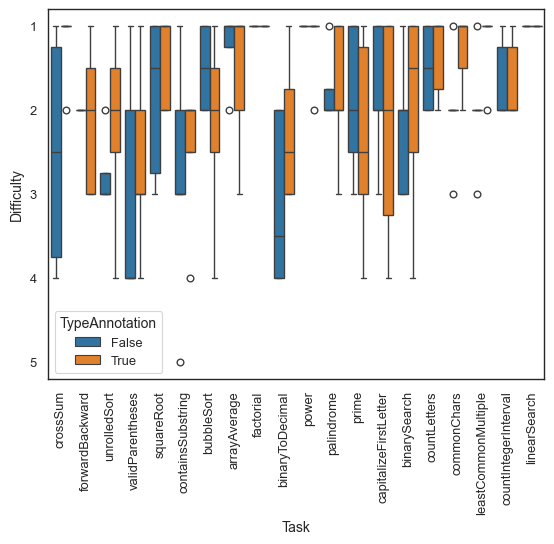

In [77]:
sns.boxplot(df_results_overall.query('Meaningful == True'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
#plt.savefig(f'{figure_path}/difficultyrq23_Meaningful.pdf', bbox_inches='tight')
plt.show()

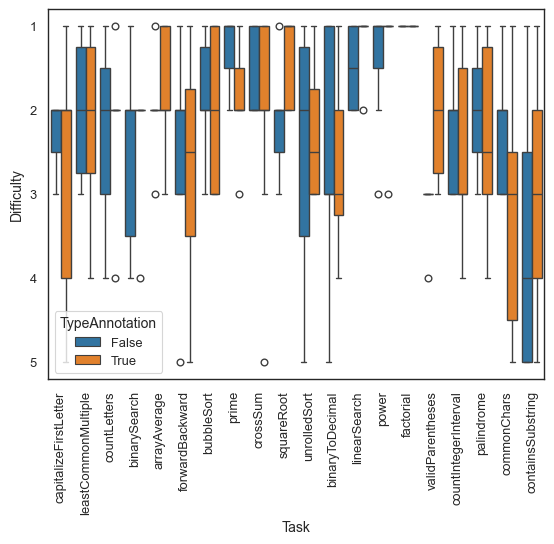

In [78]:
sns.boxplot(df_results_overall.query('Meaningful == False'), x='Task', y="Difficulty", hue="TypeAnnotation")
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 6, 1))
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/difficultyrq23_Obfuscated.pdf', bbox_inches='tight')
plt.show()

### Measures for RQ 2.1

This shall include all information for the bahavioral measures as seen above

In [79]:
table_data: dict[str, list[str] | str] = {
    'Time': ['mean', 'std'],
    # 'CorrectAnswer': ['sum', 'count'],
}

table: DataFrame = df_results_overall.groupby(['Task', 'TypeAnnotation', 'Meaningful']).agg(table_data)

# TA_L_mean = table.query("TypeAnnotation == True and Meaningful == False")["Time"]["mean"]
# NoTA_L_mean = table.query("TypeAnnotation == False and Meaningful == False")["Time"]["mean"]
# TA_M_mean = table.query('TypeAnnotation == True and Meaningful == True')['Time']['mean']
# NoTA_M_mean = table.query('TypeAnnotation == False and Meaningful == True')['Time']['mean']

TA_L = df_results_overall.query("TypeAnnotation == True and Meaningful == False")["Time"]
NoTA_L = df_results_overall.query("TypeAnnotation == False and Meaningful == False")["Time"]
TA_M = df_results_overall.query("TypeAnnotation == True and Meaningful == True")["Time"]
NoTA_M = df_results_overall.query("TypeAnnotation == False and Meaningful == True")["Time"]

print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="TypeAnnotation")}')
print(f'NORMALITY:\n{pg.normality(df_results_overall, dv="Time", group="Meaningful")}')

print(f'Levene:\n{stats.levene(TA_L, NoTA_M, TA_M, NoTA_L)}')

print(f'{df_results_overall.query("Time == 0")}')

# print(f'Obfuscated: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_L_mean, TA_L_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful NoTA:\n{stats.mannwhitneyu(NoTA_L_mean, NoTA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU NoTA -> Meaningful TA:\n{stats.mannwhitneyu(NoTA_L_mean, TA_M_mean)}')
# print(f'Obfuscated: MannWhitneyU TA -> Meaningful TA:\n{stats.mannwhitneyu(TA_L_mean, TA_M_mean)}')
# print(f'Meaningful: MannWhitneyU NoTA -> Obfuscated TA:\n{stats.mannwhitneyu(NoTA_M_mean, TA_L_mean)}')
# print(f'Meaningful: Wilcoxon NoTA -> TA:\n{stats.wilcoxon(NoTA_M_mean, TA_M_mean)}')
print(pg.sphericity(df_results_overall, dv='Time', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation'], subject='ID'))

print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['Meaningful'], subject='ID'))
print(pg.sphericity(df_results_overall, dv='CorrectAnswer', within=['TypeAnnotation'], subject='ID'))
# print(pg.sphericity(df_results_overall, dv='Time', within=['TypeAnnotation', 'Meaningful'], subject='ID',))
# (df_results_overall[['Time', 'TypeAnnotation', 'Meaningful']].corr())#.sum(1).sort_values(ascending=False)
# print(stats.bartlett())


# piv = df_results_overall.pivot(index='ID', columns=['Meaningful', 'TypeAnnotation'], values='Time')
# piv.head()
# print(pg.sphericity(piv))


NORMALITY:
                       W          pval  normal
TypeAnnotation                                
True            0.944056  2.711830e-08   False
False           0.919246  3.445882e-10   False
NORMALITY:
                   W          pval  normal
Meaningful                                
True        0.919727  4.808563e-10   False
False       0.945176  2.884603e-08   False
Levene:
LeveneResult(statistic=np.float64(0.3128638886215718), pvalue=np.float64(0.8160922039952664))
Empty DataFrame
Columns: [ID, Number, Task, Answer_Out, Time, TimeOut, SubjectID_x, CorrectAnswer, Meaningful, TypeAnnotation, Participant, Expert, Snippet, NumberOfFixations, FixationsPerSecond, Linearity, HasError, HitsBlock, HitsLine, HitsType, HitsReturnType, VerticalNext, VerticalLater, Regression, HorizontalLater, LineRegression, SaccadeLength, StoryOrder_Naive_Score, StoryOrder_Dynamic_Score, StoryOrder_Dynamic_Repetitions, ExecOrder_Naive_Score, ExecOrder_Dynamic_Score, ExecOrder_Dynamic_Repetitions, Di

In [80]:
# use statsmodel to analyze the time with variables annotation and meaningful
model = smf.mixedlm('Time ~ TypeAnnotation * Meaningful', data=df_results_overall,
                    groups=df_results_overall['Task']).fit()
print(model.summary())

                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           Time      
No. Observations:           497               Method:                       REML      
No. Groups:                 20                Scale:                        908.6746  
Min. group size:            18                Log-Likelihood:               -2412.8958
Max. group size:            29                Converged:                    Yes       
Mean group size:            24.9                                                      
--------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                  63.834    5.501 11.605 0.000  53.053 74.616
TypeAnnotation[T.True]                      3.813    3.825  0.997 0.

Check for contingency in CorrectAnswer

In [81]:
df_results_overall['CorrectAnswerNumeric'] = df_results_overall['CorrectAnswer'].apply(lambda x: 1 if x else 0)
model = smf.logit('CorrectAnswerNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall,
                  groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.396243
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     CorrectAnswerNumeric   No. Observations:                  497
Model:                            Logit   Df Residuals:                      493
Method:                             MLE   Df Model:                            3
Date:                  Tue, 21 Oct 2025   Pseudo R-squ.:                0.007283
Time:                          08:46:21   Log-Likelihood:                -196.93
converged:                         True   LL-Null:                       -198.38
Covariance Type:              nonrobust   LLR p-value:                    0.4090
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [82]:
model = smf.mixedlm('Time ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall,
                    groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Time      
No. Observations:             497                 Method:                         REML      
No. Groups:                   20                  Scale:                          908.6746  
Min. group size:              18                  Log-Likelihood:                 -2412.8958
Max. group size:              29                  Converged:                      Yes       
Mean group size:              24.9                                                          
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        63.834    5.501 11.605 0.000  53.053 74.616
C(Mea

#### RQ 2.2 Linearity

In [83]:
list_measure: list[str] = ['VerticalNext',
                           'VerticalLater', 'Regression', 'HorizontalLater', 'LineRegression', 'StoryOrder_Naive_Score',
                           'StoryOrder_Dynamic_Score', 'StoryOrder_Dynamic_Repetitions', 'SaccadeLength', 'Linearity'
                           ]

df_results_overall = df_results_overall[df_results_overall['LineRegression'].notna()].reset_index()
df_results_overall = df_results_overall[df_results_overall['SaccadeLength'].notna()].reset_index()

In [84]:
for measure in list_measure:
    print(f'\nMeasure: {measure}')
    if measure not in []:
        model = smf.mixedlm(f'{measure} ~ C(TypeAnnotation) * C(Meaningful)', data=df_results_overall,
                            groups=df_results_overall['Task']).fit()
        print(model.summary())
    else:
        model = smf.mixedlm(f'{measure} ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall,
                            groups=df_results_overall['Task']).fit()
    print(model.wald_test_terms(scalar=True))


Measure: VerticalNext
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           VerticalNext
No. Observations:             497               Method:                       REML        
No. Groups:                   20                Scale:                        0.0017      
Min. group size:              18                Log-Likelihood:               850.1003    
Max. group size:              29                Converged:                    Yes         
Mean group size:              24.9                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.129    0.005 26.957 0.000  0.119  0.138
C(T

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: C

                           Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           SaccadeLength
No. Observations:             497               Method:                       REML         
No. Groups:                   20                Scale:                        229.4753     
Min. group size:              18                Log-Likelihood:               -2057.3675   
Max. group size:              29                Converged:                    Yes          
Mean group size:              24.9                                                         
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                       33.059    1.596 20.717 0.000  29.931 36.187
C(TypeAnnotatio

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

#### RQ 2.3

Check for the difficulty

In [85]:
# df_results_overall['DifficultyNumeric'] = df_results_overall['Difficulty'].apply(lambda x: 1 if x == 'Very Difficult' else  0)
model = smf.logit('DifficultyNumeric ~ C(Meaningful) * C(TypeAnnotation)', data=df_results_overall,
                  groups=df_results_overall['Task']).fit()
print(model.summary())
print(model.wald_test_terms(scalar=True))

Optimization terminated successfully.
         Current function value: 0.656595
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      DifficultyNumeric   No. Observations:                  462
Model:                          Logit   Df Residuals:                      458
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                -0.08968
Time:                        08:46:22   Log-Likelihood:                -303.35
converged:                       True   LL-Null:                       -278.38
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                         

/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)
/Users/Youssef/.venvs/venv/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


TAComprehension influenced by Meaningful?

64.18712273641852
36.69692781774947
10, 497


<Axes: ylabel='Time'>

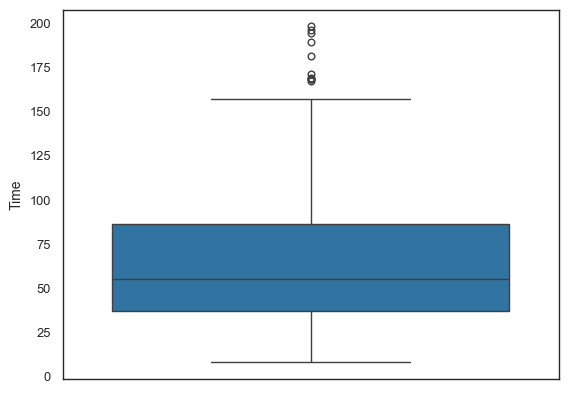

In [86]:
Q3 = df_results_overall.Time.quantile(0.75)
Q1 = df_results_overall.Time.quantile(0.25)
print(df_results_overall.Time.mean())
print(df_results_overall.Time.std())

IQR = Q3 - Q1
threshold = 1.5

outliers = df_results_overall[
    (df_results_overall['Time'] < Q1 - threshold * IQR) | (df_results_overall['Time'] > Q3 + threshold * IQR)]
print(f'{len(outliers.Time)}, {len(df_results_overall.Time)}')
sns.boxplot(df_results_overall, y='Time')

#### Miscellaneous

How did the people find themselves in comparison to others?

  Classmates    percent
0          3  45.714286
1          4  34.285714
2          2  14.285714
3          5   5.714286
4          1   0.000000


<Figure size 1000x600 with 0 Axes>

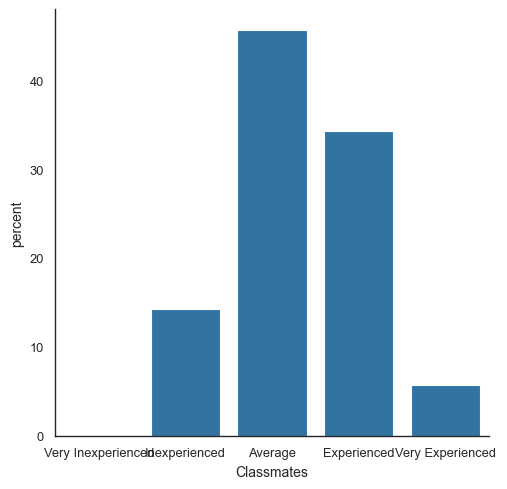

In [87]:
df1 = df_personal_information.Classmates.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Classmates',
            # hue='TypeAnnotation', 
            data=df1,
            kind='bar',
            y='percent',
            )

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

For OverallExperience

  OverallExperience    percent
0                 3  45.714286
1                 4  42.857143
2                 2  11.428571
3                 1   0.000000
4                 5   0.000000


<Figure size 1000x600 with 0 Axes>

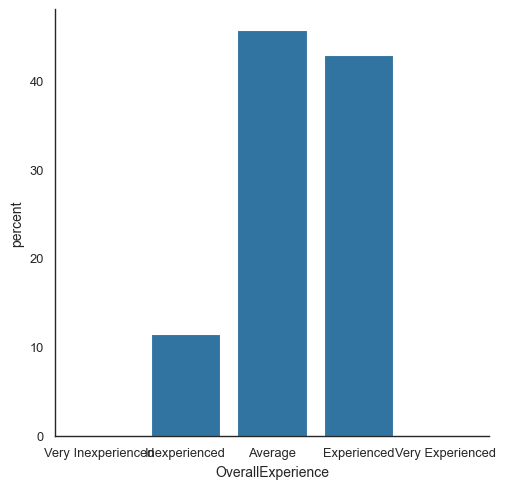

In [88]:
df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='OverallExperience',
            # hue='TypeAnnotation', 
            data=df1,
            kind='bar',
            y='percent',
            )

plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

Years Programming

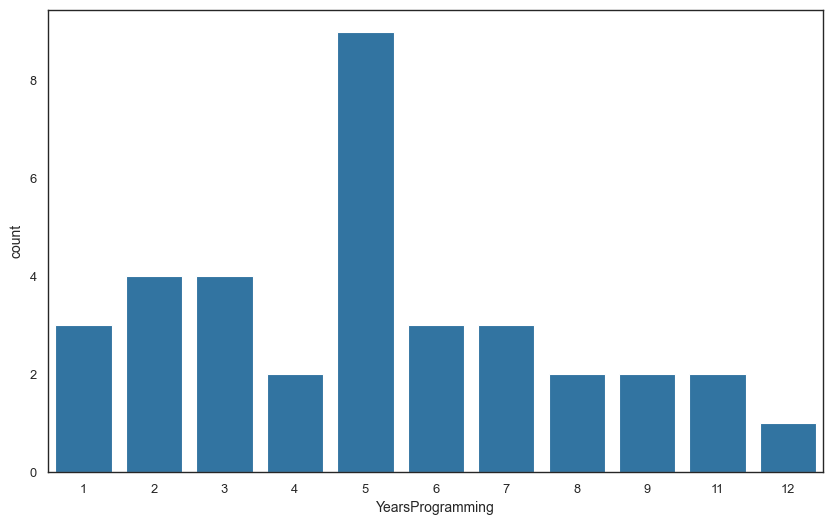

In [89]:
# df1 = df_personal_information.OverallExperience.value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent').reset_index()

# print(df1)

plt.figure(figsize=(10, 6))
sns.countplot(x='YearsProgramming',
              # hue='TypeAnnotation',
              data=df_personal_information,
              # kind='bar',
              )

# plt.xticks(np.arange(5), ['Very Inexperienced', 'Inexperienced', 'Average', 'Experienced', 'Very Experienced'])
# plt.title('Difficulty grouped by Meaningful')
# plt.savefig(f'{figure_path}/rq23difficultyLikertCatPlotMeaningful.pdf', bbox_inches='tight')
plt.show()

In [90]:
df_results_overall.Linearity.describe()

count    497.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: Linearity, dtype: float64

All Snippets with their mean and SD with correctness

In [91]:
df = df_results_overall.groupby(['Task', 'TypeAnnotation']).agg({'Time': ['mean', 'std']})
df

Time           
                                            mean        std
Task                  TypeAnnotation                       
arrayAverage          False            55.200000  27.587437
                      True             51.470588  18.385176
binarySearch          False            78.428571  35.094848
                      True            101.500000  35.189171
binaryToDecimal       False            78.000000  22.572107
                      True             67.357143  30.648396
bubbleSort            False            76.090909  37.827119
                      True             72.357143  26.119863
capitalizeFirstLetter False            79.700000  34.884094
                      True             96.058824  31.487042
commonChars           False            44.642857  20.507436
                      True             52.583333  25.242311
containsSubstring     False            97.666667  53.637391
                      True            100.857143  39.309144
countIntegerInterval  False            70.500000  25.058114
                      True             82.500000  18.903602
countLetters          False            35.875000  23.491260
                      True             68.615385  37.057474
crossSum              False            27.916667   9.481641
                      True             42.352941  16.120411
factorial             False            18.666667  10.184956
                      True             27.000000  13.589211
forwardBackward       False            68.416667  22.459897
                      True             70.583333  21.304965
leastCommonMultiple   False            70.583333  24.216667
                      True             38.583333  15.270044
linearSearch          False            30.300000  13.400249
                      True             27.750000  15.645629
palindrome            False            75.500000  44.336377
                      True             62.230769  27.292105
power                 False            34.500000  12.369317
                      True             41.333333  12.499697
prime                 False            52.571429  19.762880
                      True             73.333333  47.079972
squareRoot            False            69.769231  23.962310
                      True             75.363636  48.191851
unrolledSort          False            74.916667  58.596398
                      True             71.454545  39.975902
validParentheses      False           105.916667  28.247151
                      True             92.833333  40.512250

## Currently unnecessary and unused data

   TypeAnnotation  Meaningful  CorrectAnswer    percent
0           False       False           True  89.430894
1           False       False          False  10.569106
2           False        True           True  87.394958
3           False        True          False  12.605042
4            True       False           True  82.352941
5            True       False          False  17.647059
6            True        True           True  86.554622
7            True        True          False  13.445378


<Figure size 1000x600 with 0 Axes>

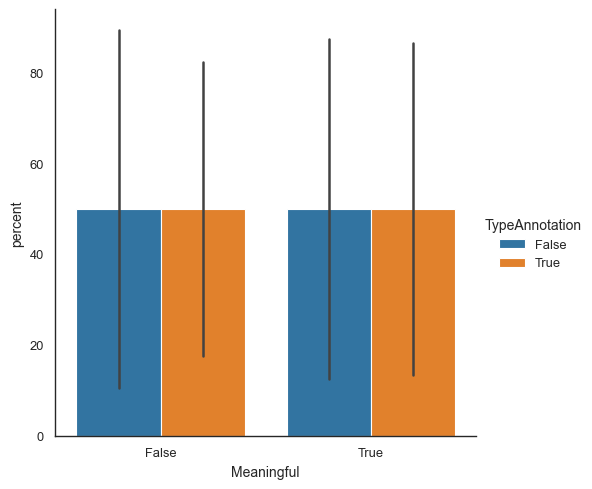

In [92]:
df1 = df_results_overall.groupby(['TypeAnnotation', 'Meaningful'])['CorrectAnswer'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
print(df1)

plt.figure(figsize=(10, 6))
sns.catplot(x='Meaningful',
            hue='TypeAnnotation',
            data=df1,
            kind='bar',
            y='percent',
            )
plt.show()

#### Table for Type Annotations and Meaningful

In [93]:
table_data: dict[str, list[str] | str] = {
    'Time': ['mean', 'std'],
    'CorrectAnswer': ['sum', 'count'],
}

df_results_overall.groupby(['Task', 'Meaningful', 'TypeAnnotation']).agg(table_data)

Time             \
                                                  mean        std   
Task             Meaningful TypeAnnotation                          
arrayAverage     False      False            66.000000  31.553130   
                            True             57.250000  13.760710   
                 True       False            39.000000   6.377042   
                            True             46.333333  21.148286   
binarySearch     False      False            91.285714  45.231679   
...                                                ...        ...   
unrolledSort     True       True             80.714286  42.046460   
validParentheses False      False            95.000000  17.349352   
                            True             76.000000  40.049969   
                 True       False           113.714286  33.043982   
                            True            116.400000  30.286961   

                                           CorrectAnswer        
                                                     sum count  
Task             Meaningful TypeAnnotation                      
arrayAverage     False      False                      6     6  
                            True                       8     8  
                 True       False                      4     4  
                            True                       9     9  
binarySearch     False      False                      6     7  
...                                                  ...   ...  
unrolledSort     True       True                       4     7  
validParentheses False      False                      5     5  
                            True                       7     7  
                 True       False                      7     7  
                            True                       4     5  

[80 rows x 4 columns]

### Task Plots

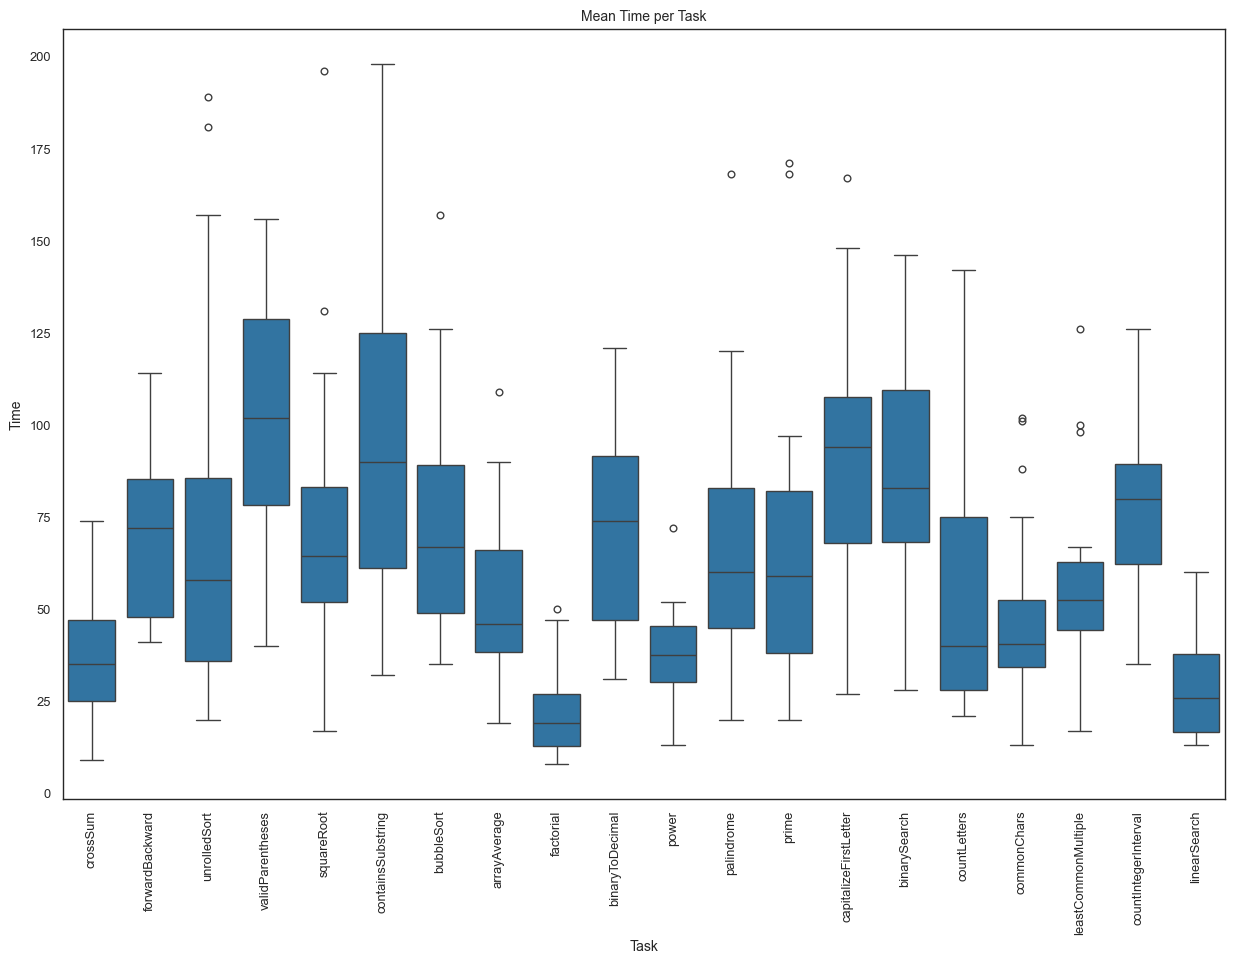

In [94]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot for the mean length of each task
plt.figure(figsize=(15, 10))
sns.boxplot(x='Task', y='Time', data=df_results_overall)
plt.title('Mean Time per Task')
plt.xticks(rotation=90)
plt.show()

The mean time per task by Type Annotation

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3662079686.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3662079686.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(


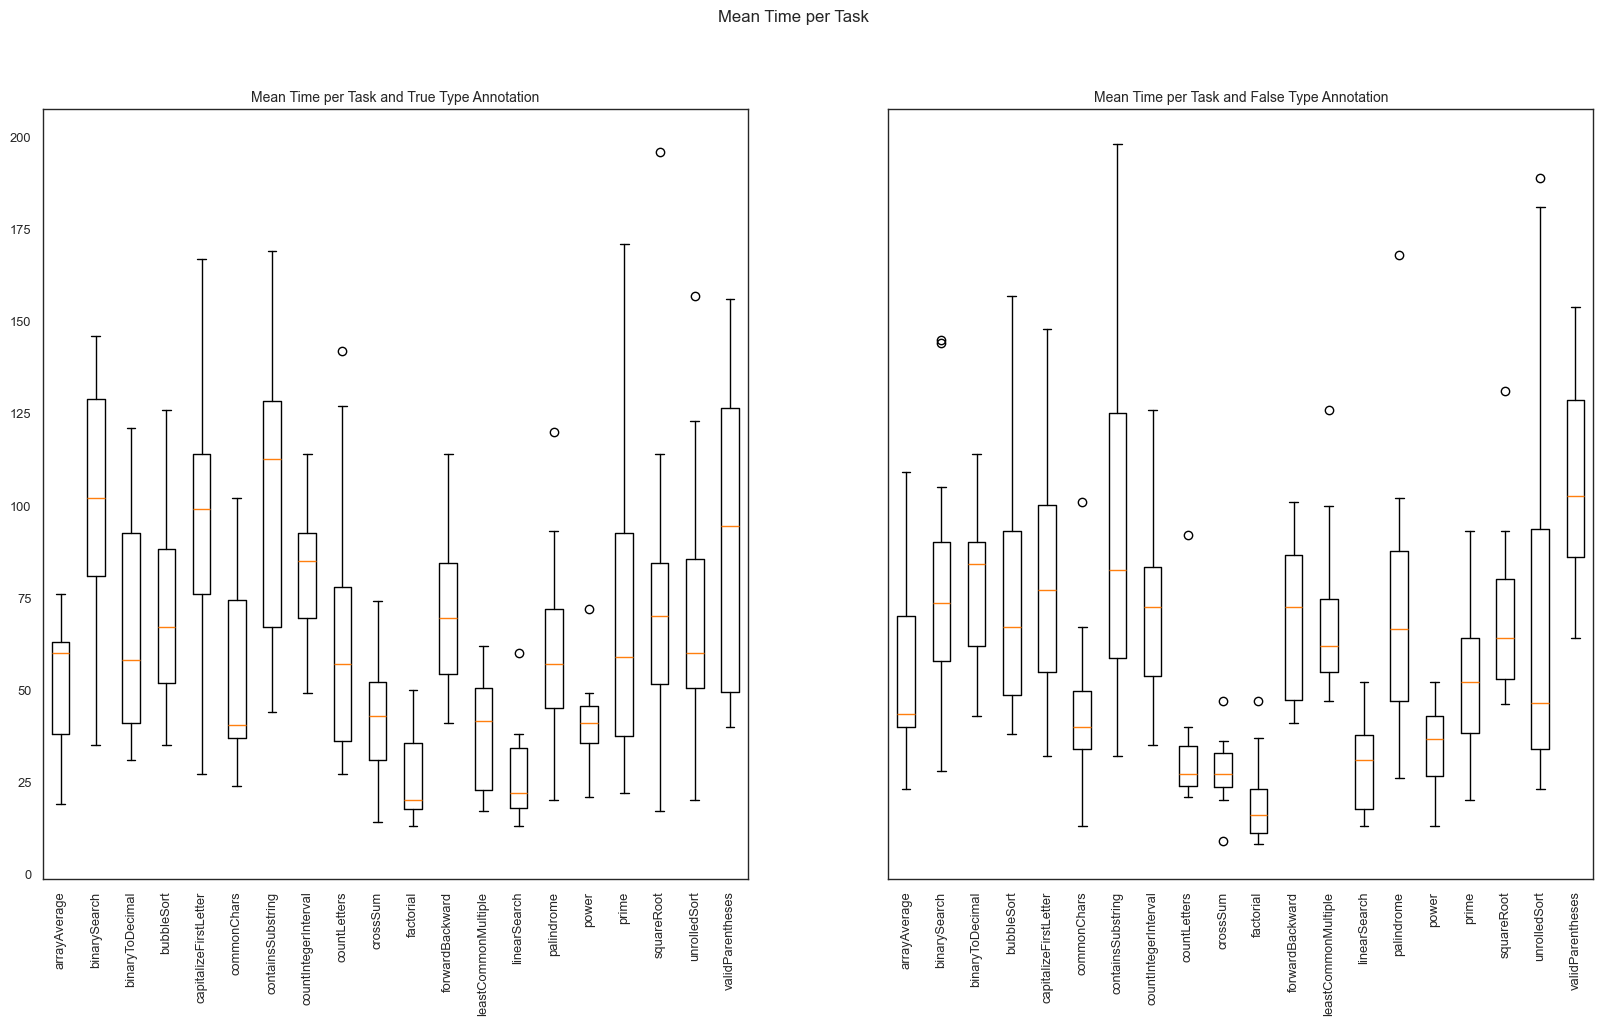

In [95]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True')['Time'] for task in all_tasks],
    labels=all_tasks, )
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and True Type Annotation')

axs[1].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False')['Time'] for task in all_tasks],
    labels=all_tasks, )
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and False Type Annotation')

plt.show()

The mean time per task by Identifier Name

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2029980224.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks],
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2029980224.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks],


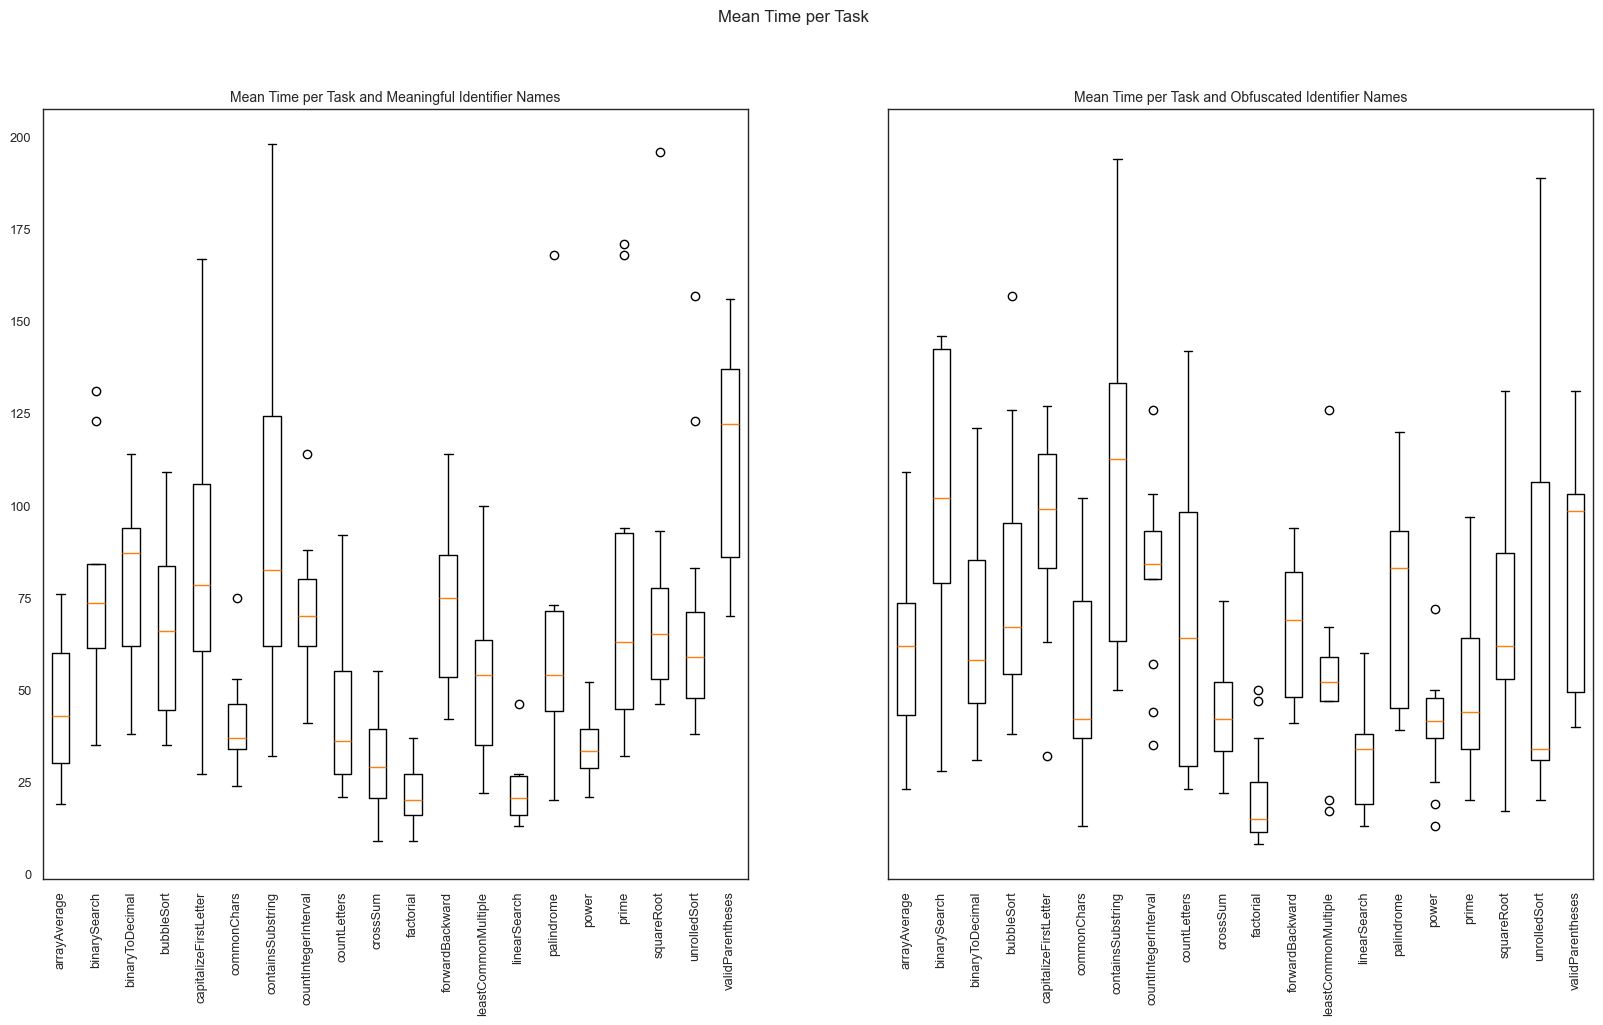

In [96]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == True')['Time'] for task in all_tasks],
               labels=all_tasks, )
axs[0].set_xticklabels(all_tasks, rotation=90)
axs[0].set_title('Mean Time per Task and Meaningful Identifier Names')

axs[1].boxplot(x=[df_results_overall.query(f'Task == @task and `Meaningful` == False')['Time'] for task in all_tasks],
               labels=all_tasks, )
axs[1].set_xticklabels(all_tasks, rotation=90)
axs[1].set_title('Mean Time per Task and Obfuscated Identifier Names')

plt.show()

The mean time per task and for the combinations of Type Annoations and Identifier Names

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1820354587.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1820354587.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1820354587.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1820354587.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since 

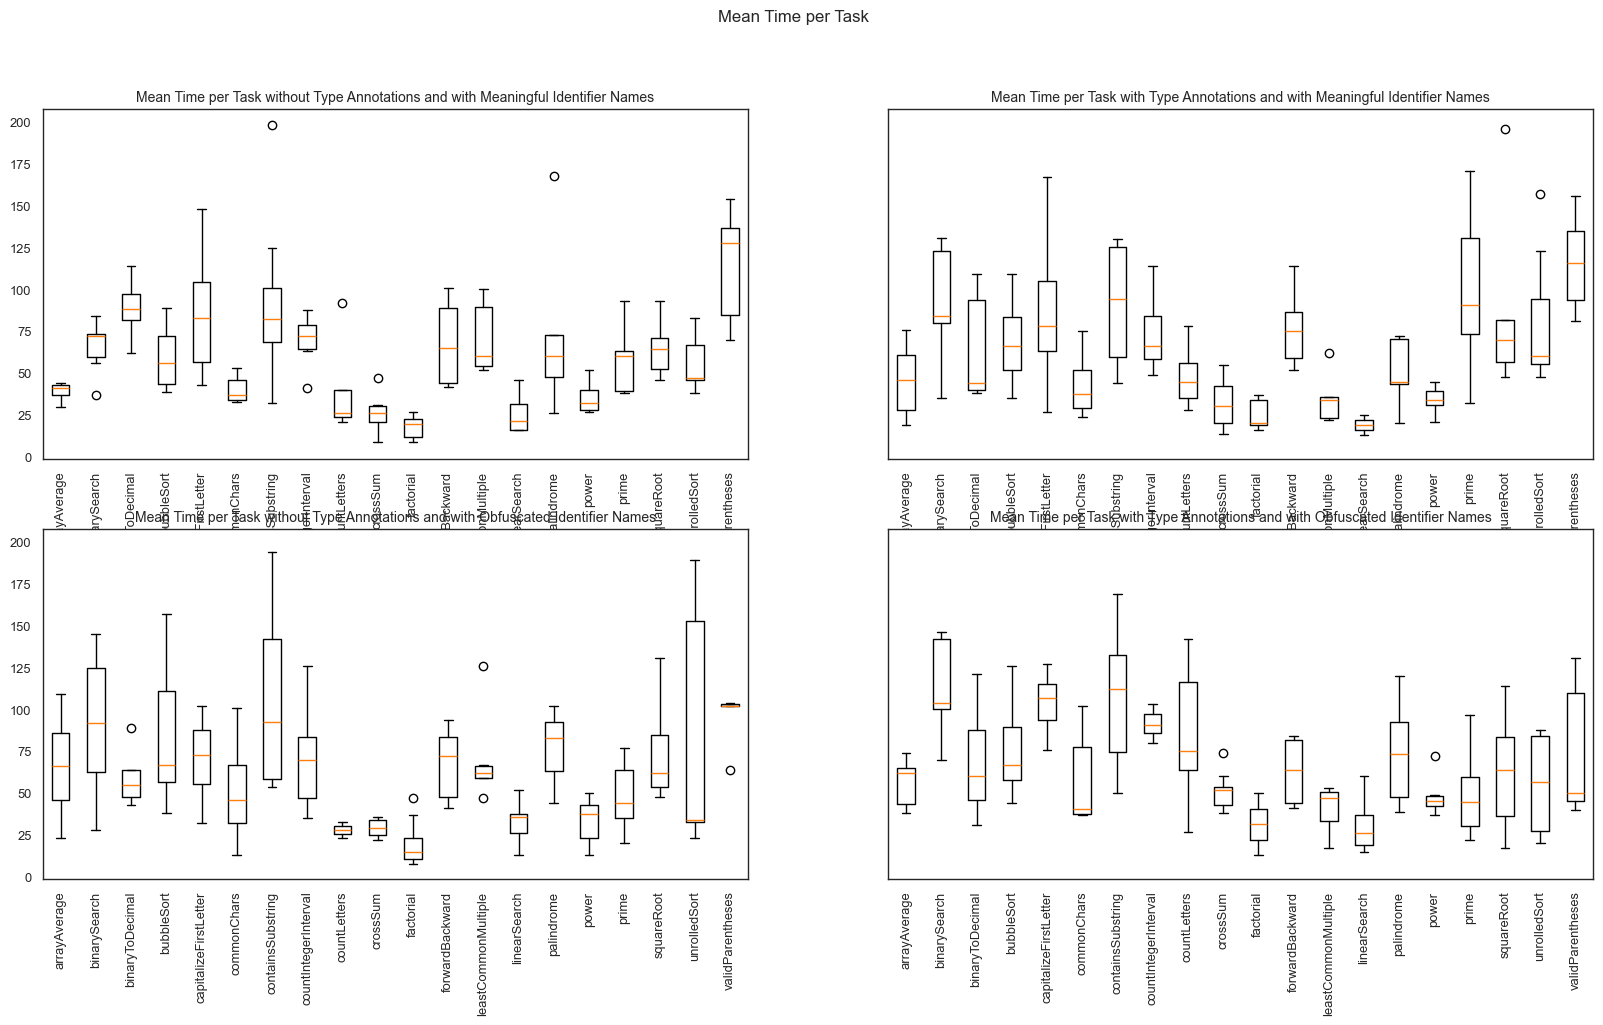

In [97]:
all_tasks: list[str] = sorted(df_results_overall['Task'].unique())

# create a plot that shows the mean time for each task
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharey=True)
fig.suptitle('Mean Time per Task')

axs[0, 0].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == True')['Time'] for
       task in all_tasks], labels=all_tasks, notch=False)
axs[0, 0].set_xticklabels(all_tasks, rotation=90)
axs[0, 0].set_title('Mean Time per Task without Type Annotations and with Meaningful Identifier Names')

axs[0, 1].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for task
       in all_tasks], labels=all_tasks, )
axs[0, 1].set_xticklabels(all_tasks, rotation=90)
axs[0, 1].set_title('Mean Time per Task with Type Annotations and with Meaningful Identifier Names')

axs[1, 0].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == False and `Meaningful` == False')['Time'] for
       task in all_tasks], labels=all_tasks, )
axs[1, 0].set_xticklabels(all_tasks, rotation=90)
axs[1, 0].set_title('Mean Time per Task without Type Annotations and with Obfuscated Identifier Names')

axs[1, 1].boxplot(
    x=[df_results_overall.query(f'Task == @task and `TypeAnnotation` == True and `Meaningful` == False')['Time'] for
       task in all_tasks], labels=all_tasks, )
axs[1, 1].set_xticklabels(all_tasks, rotation=90)
axs[1, 1].set_title('Mean Time per Task with Type Annotations and with Obfuscated Identifier Names')

plt.show()

A plot to describe how long each task took overall and how this is distributed among the participants.

A plot that shows how long each participant took grouped by task.

Combine the Type Annotation plots in the top row into one bigger plot with comparison.

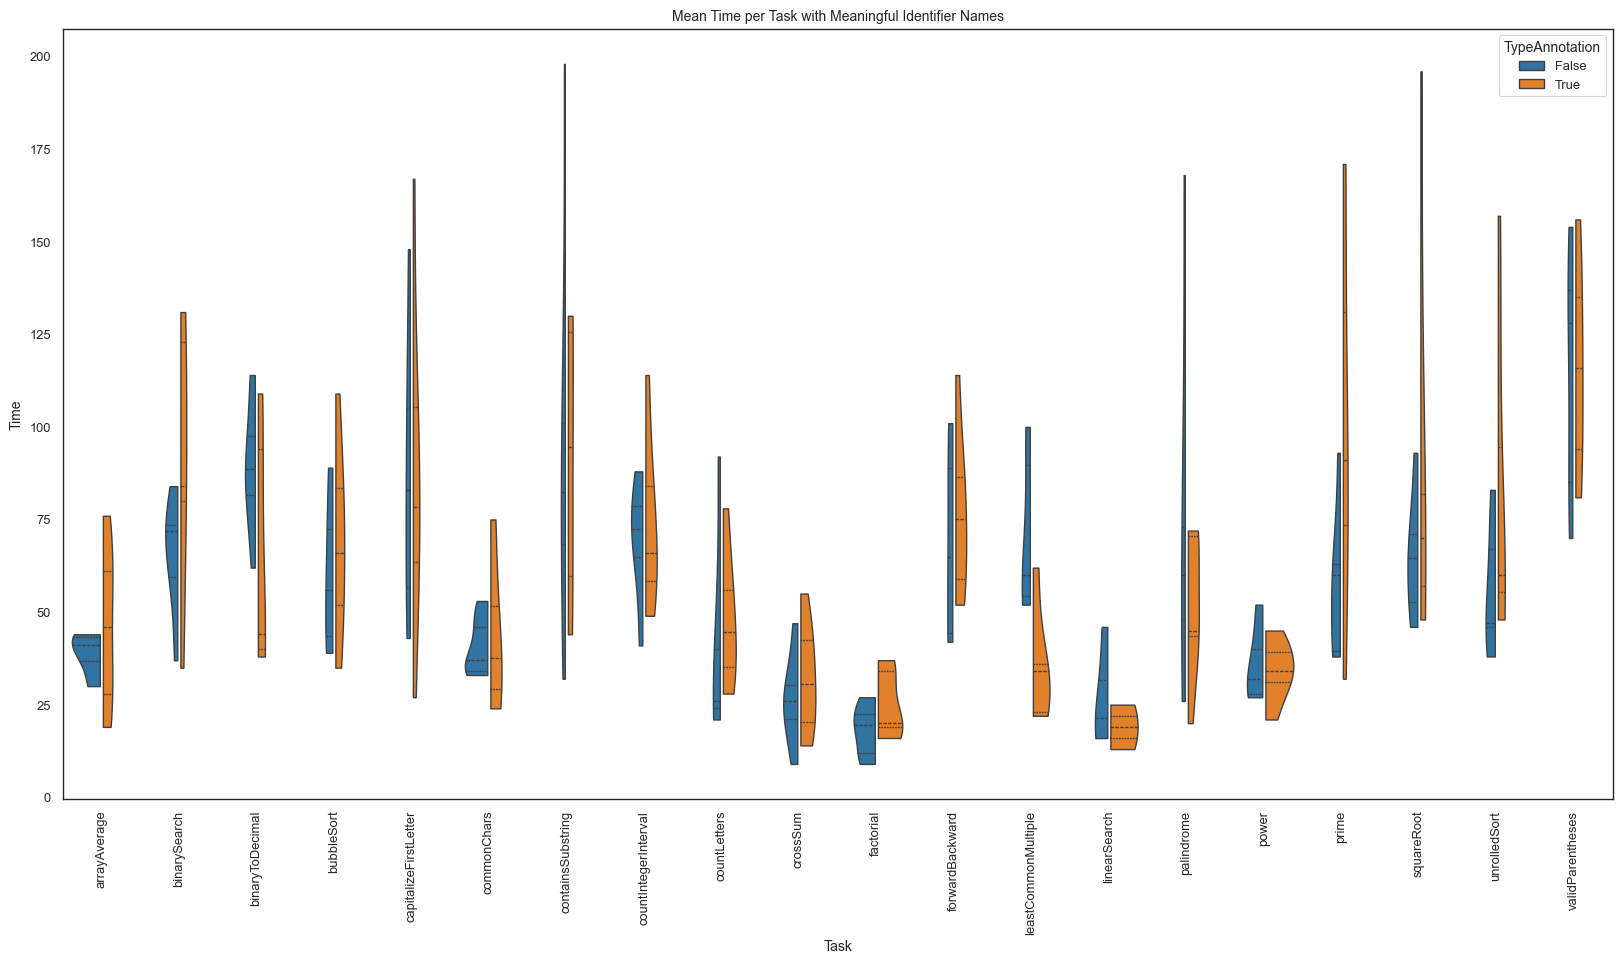

In [98]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Time', hue='TypeAnnotation', split=True,
               gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Meaningful Identifier Names')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_meaningful.pdf', bbox_inches='tight')

plt.show()

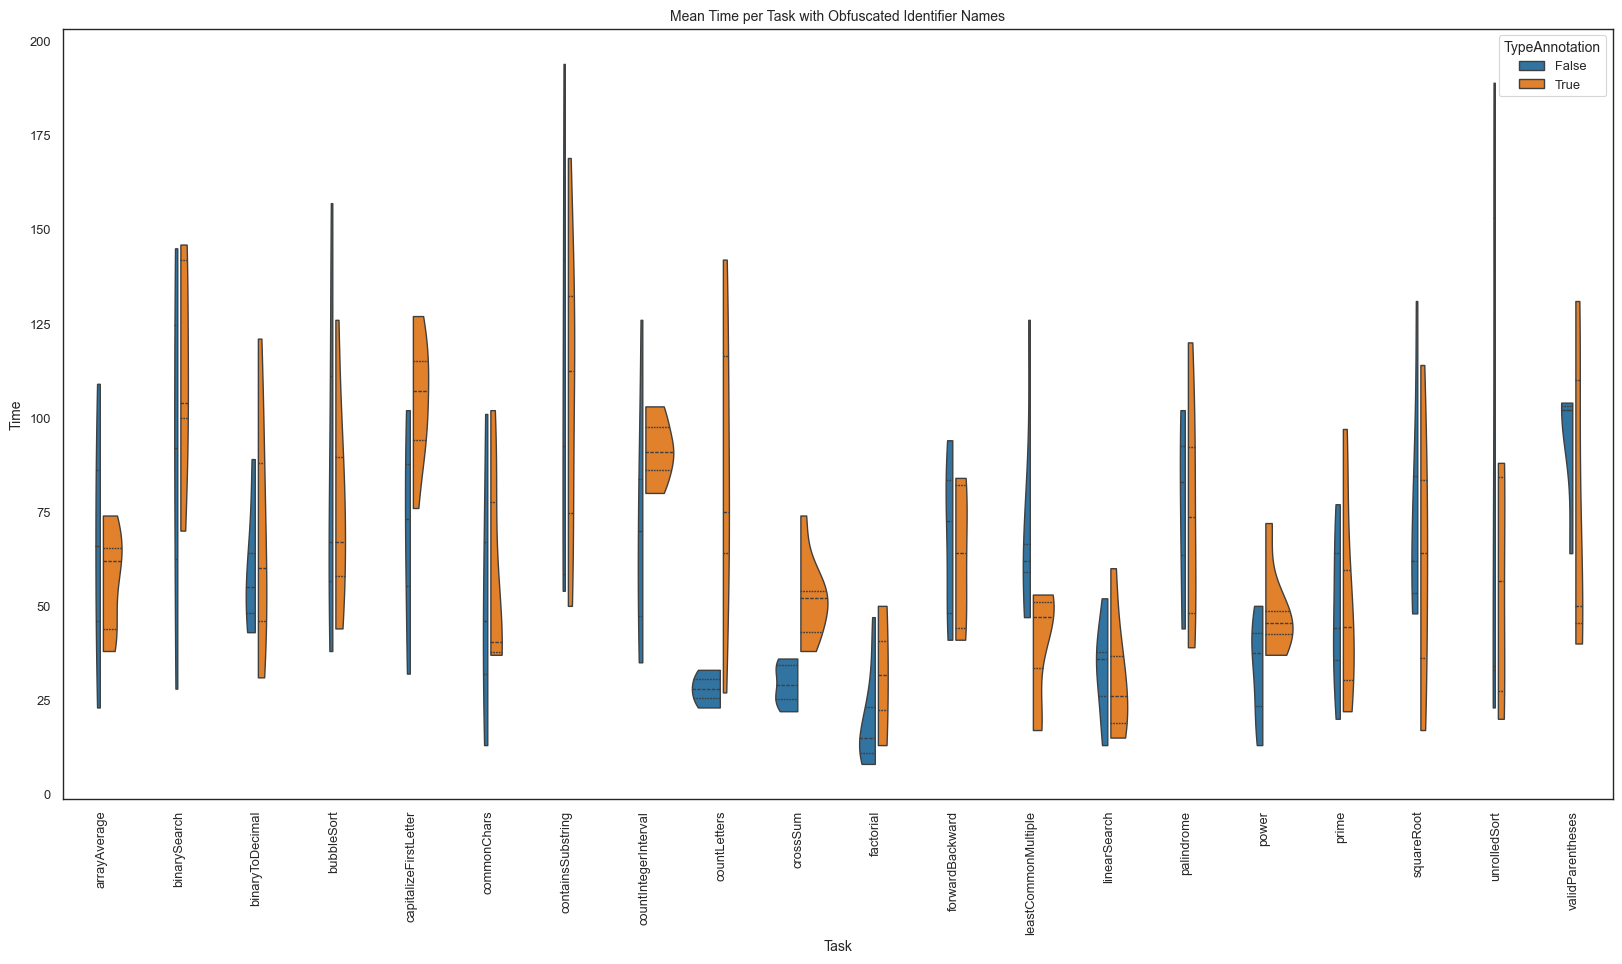

In [99]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Time', hue='TypeAnnotation', split=True,
               gap=.1, inner="quart", cut=0, order=all_tasks)

plt.xticks(all_tasks, rotation=90)
plt.title('Mean Time per Task with Obfuscated Identifier Names')

# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/timePerTaskrq21_obfuscated.pdf', bbox_inches='tight')
plt.show()

What were the Means and the Standard Deviation for meaningful and type annotation?

In [100]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'Time': ['mean', 'std']}))
print(df_results_overall.groupby(['Meaningful']).agg({'Time': ['mean', 'std']}))


                                Time           
                                mean        std
Meaningful TypeAnnotation                      
False      False           60.634146  39.383209
           True            69.448529  33.960722
True       False           61.336134  34.988201
           True            64.697479  38.206742
                 Time           
                 mean        std
Meaningful                      
False       65.262548  36.828965
True        63.016807  36.594248


As for the correctness:

In [101]:
print(df_results_overall.groupby(['Meaningful', 'TypeAnnotation', ]).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['Meaningful']).agg({'CorrectAnswer': ['sum', 'count']}))
print(df_results_overall.groupby(['TypeAnnotation']).agg({'CorrectAnswer': ['sum', 'count']}))

                          CorrectAnswer      
                                    sum count
Meaningful TypeAnnotation                    
False      False                    110   123
           True                     112   136
True       False                    104   119
           True                     103   119
           CorrectAnswer      
                     sum count
Meaningful                    
False                222   259
True                 207   238
               CorrectAnswer      
                         sum count
TypeAnnotation                    
False                    214   242
True                     215   255


Correlation heatmap and p-values for the time

P-Values:
        M-TA     L-N    L-TA     M-N
L-N   0.0003     0.0  0.0045     0.0
L-TA  0.0045  0.0045     0.0  0.0046
M-N   0.0001     0.0  0.0046     0.0
M-TA     0.0  0.0003  0.0045  0.0001


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2246210131.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


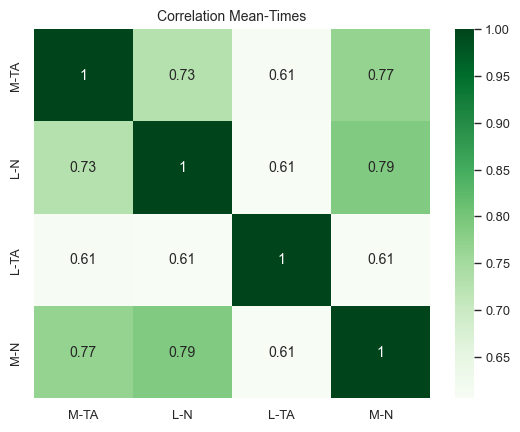

In [102]:
df_correlation_meantimes_snippets: DataFrame = DataFrame()

df_correlation_meantimes_snippets['M-TA'] = \
    df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg({'Time': 'mean'})[
        'Time']
df_correlation_meantimes_snippets['L-N'] = \
    df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg({'Time': 'mean'})[
        'Time']
df_correlation_meantimes_snippets['L-TA'] = \
    df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg({'Time': 'mean'})[
        'Time']
df_correlation_meantimes_snippets['M-N'] = \
    df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg({'Time': 'mean'})[
        'Time']

matrix = df_correlation_meantimes_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_meantimes_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Mean-Times')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_meantimesrq21.pdf', bbox_inches='tight')
plt.show()

Correlation and p-values for the correctness

P-Values:
        M-TA     L-N    L-TA     M-N
L-N   0.9808     0.0  0.0971  0.5625
L-TA  0.2132  0.0971     0.0  0.5001
M-N   0.2682  0.5625  0.5001     0.0
M-TA     0.0  0.9808  0.2132  0.2682


/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/2246210131.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(stats.pearsonr(tmp[r], tmp[c])[1], 4)


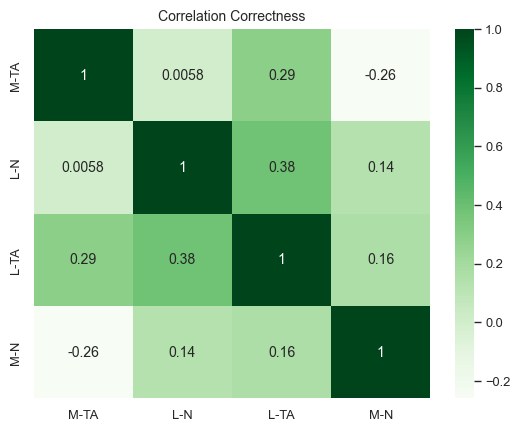

In [103]:
df_correlation_correctness_snippets: DataFrame = DataFrame()

df_correlation_correctness_snippets['M-TA'] = \
    df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg(
        {'CorrectAnswer': 'sum'})[
        'CorrectAnswer'] / \
    df_results_overall.query('TypeAnnotation == True and Meaningful == True').groupby('Task').agg(
        {'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-N'] = \
    df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg(
        {'CorrectAnswer': 'sum'})['CorrectAnswer'] / \
    df_results_overall.query('TypeAnnotation == False and Meaningful == False').groupby('Task').agg(
        {'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['L-TA'] = \
    df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg(
        {'CorrectAnswer': 'sum'})['CorrectAnswer'] / \
    df_results_overall.query('TypeAnnotation == True and Meaningful == False').groupby('Task').agg(
        {'CorrectAnswer': 'count'})['CorrectAnswer']
df_correlation_correctness_snippets['M-N'] = \
    df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg(
        {'CorrectAnswer': 'sum'})['CorrectAnswer'] / \
    df_results_overall.query('TypeAnnotation == False and Meaningful == True').groupby('Task').agg(
        {'CorrectAnswer': 'count'})['CorrectAnswer']

matrix = df_correlation_correctness_snippets.corr()
print(f'P-Values:\n{calculate_pvalues(df_correlation_correctness_snippets)}')

sns.heatmap(matrix, cmap="Greens", annot=True)
plt.title(f'Correlation Correctness')
# TODO: uncomment the following line to save the figure
# plt.savefig(f'{figure_path}/correlation_correctnessrq21.pdf', bbox_inches='tight')
plt.show()

Show the mean time with and without type annotations for each participant.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3732326360.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3732326360.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3732326360.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_L = axs[1].boxplot(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3732326360.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been rena

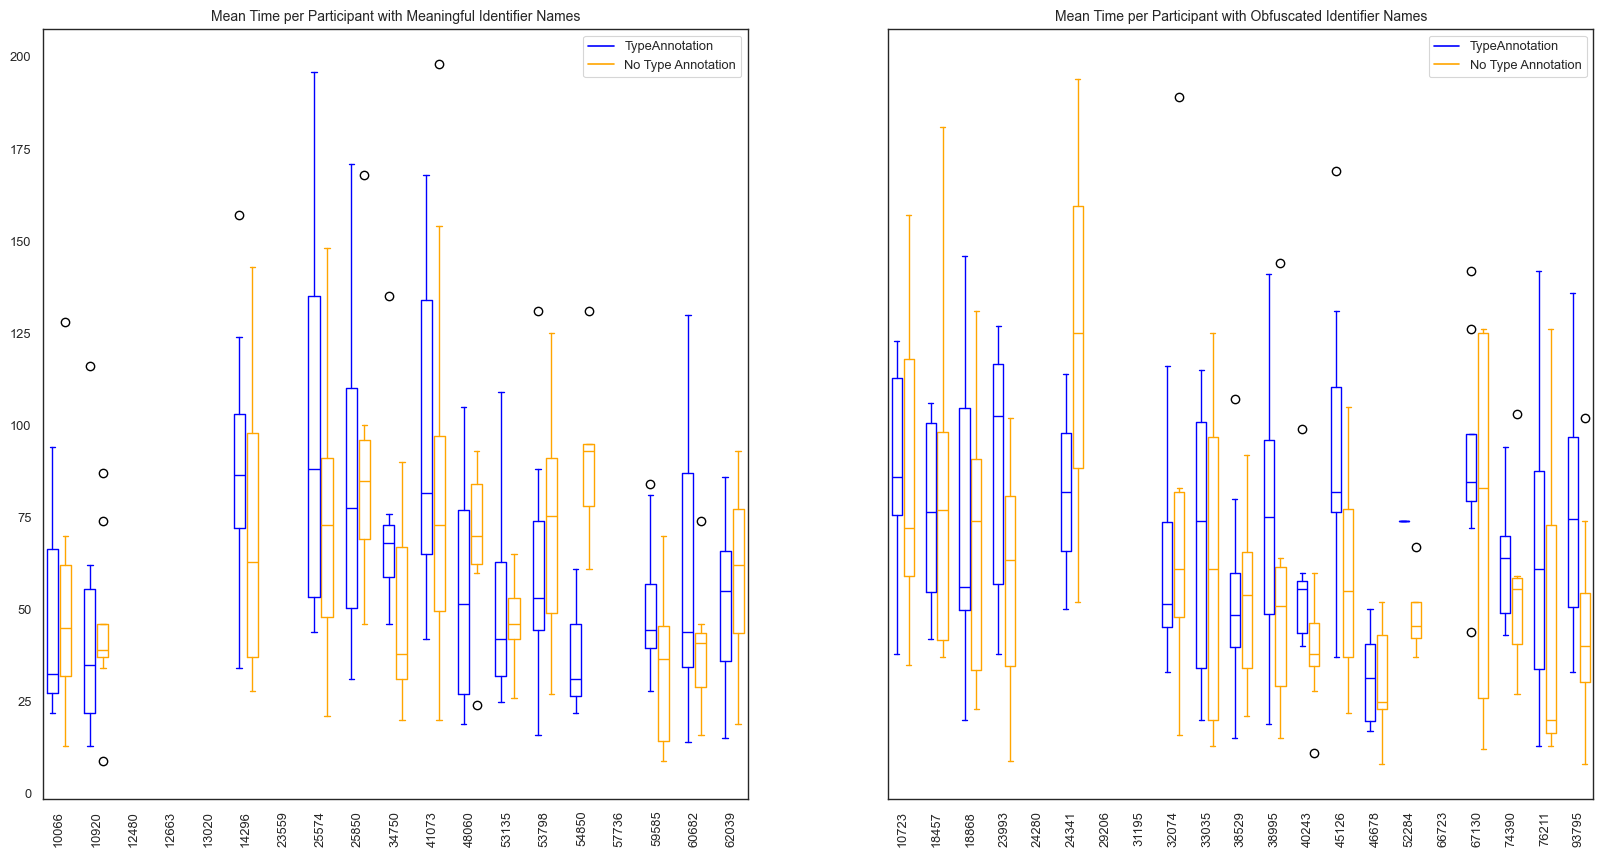

In [104]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot(
    [df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Time']
     for participant in meaningful_participants], labels=meaningful_participants,
    positions=np.arange(len(meaningful_participants)) * 2.0 + 0.35, widths=0.6)
plot_TA_M = axs[0].boxplot(
    [df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Time'] for
     participant in meaningful_participants], labels=meaningful_participants,
    positions=np.arange(len(meaningful_participants)) * 2.0 - 0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Time per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
define_box_properties(plot_TA_M, 'blue', 'TypeAnnotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot(
    [df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Time']
     for participant in obfuscated_participants], labels=obfuscated_participants,
    positions=np.arange(len(obfuscated_participants)) * 2.0 + 0.35, widths=0.6)
plot_TA_L = axs[1].boxplot(
    [df_results_overall.query(f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Time']
     for participant in obfuscated_participants], labels=obfuscated_participants,
    positions=np.arange(len(obfuscated_participants)) * 2.0 - 0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Time per Participant with Obfuscated Identifier Names')
axs[1].set_xticks(np.arange(0, len(obfuscated_participants) * 2, 2), obfuscated_participants, rotation=90)
define_box_properties(plot_TA_L, 'blue', 'TypeAnnotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


How long people took overall.

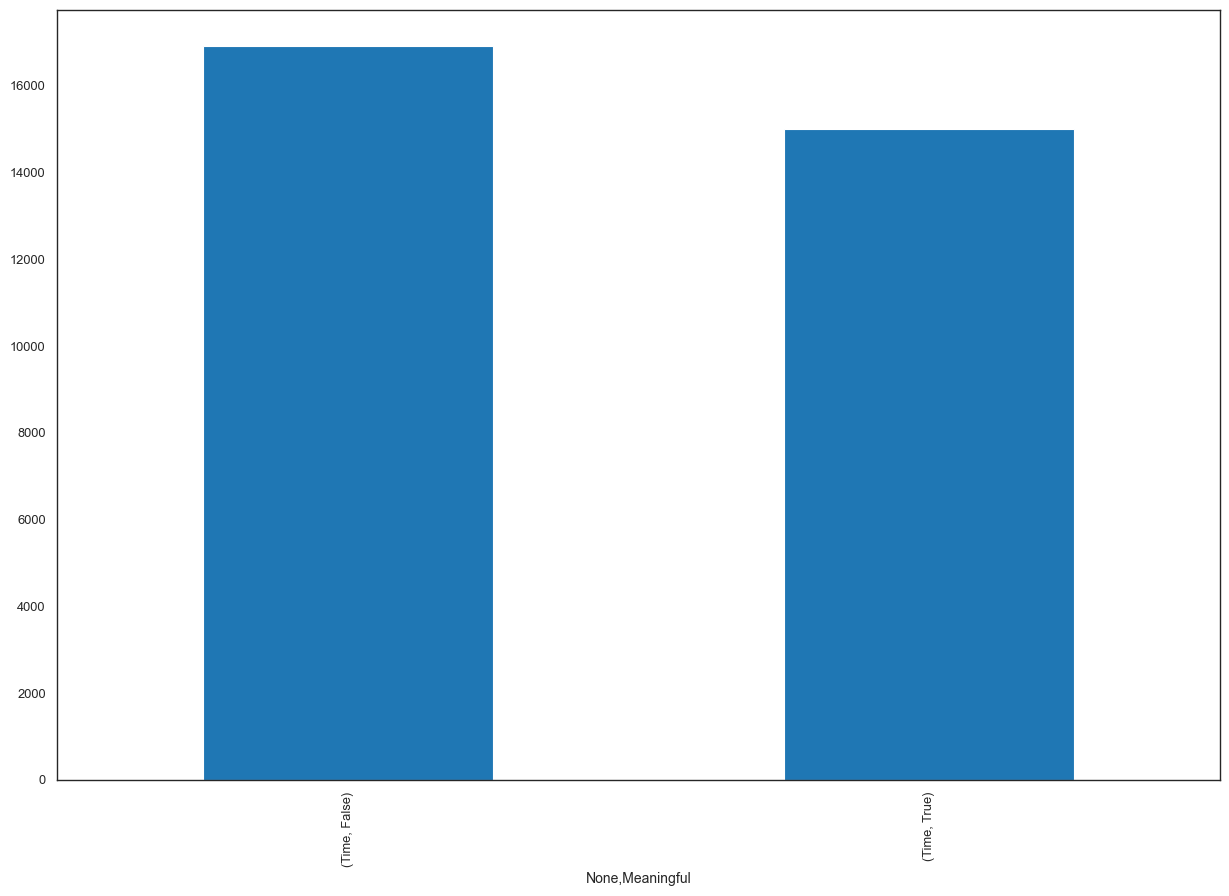

In [105]:
df_results_overall.groupby(['Meaningful', ]).agg({'Time': 'sum'}).unstack().T.plot(kind='bar', stacked=True,
                                                                                   figsize=(15, 10))
plt.show()

Do `meaningful` snippets make participants faster on average?

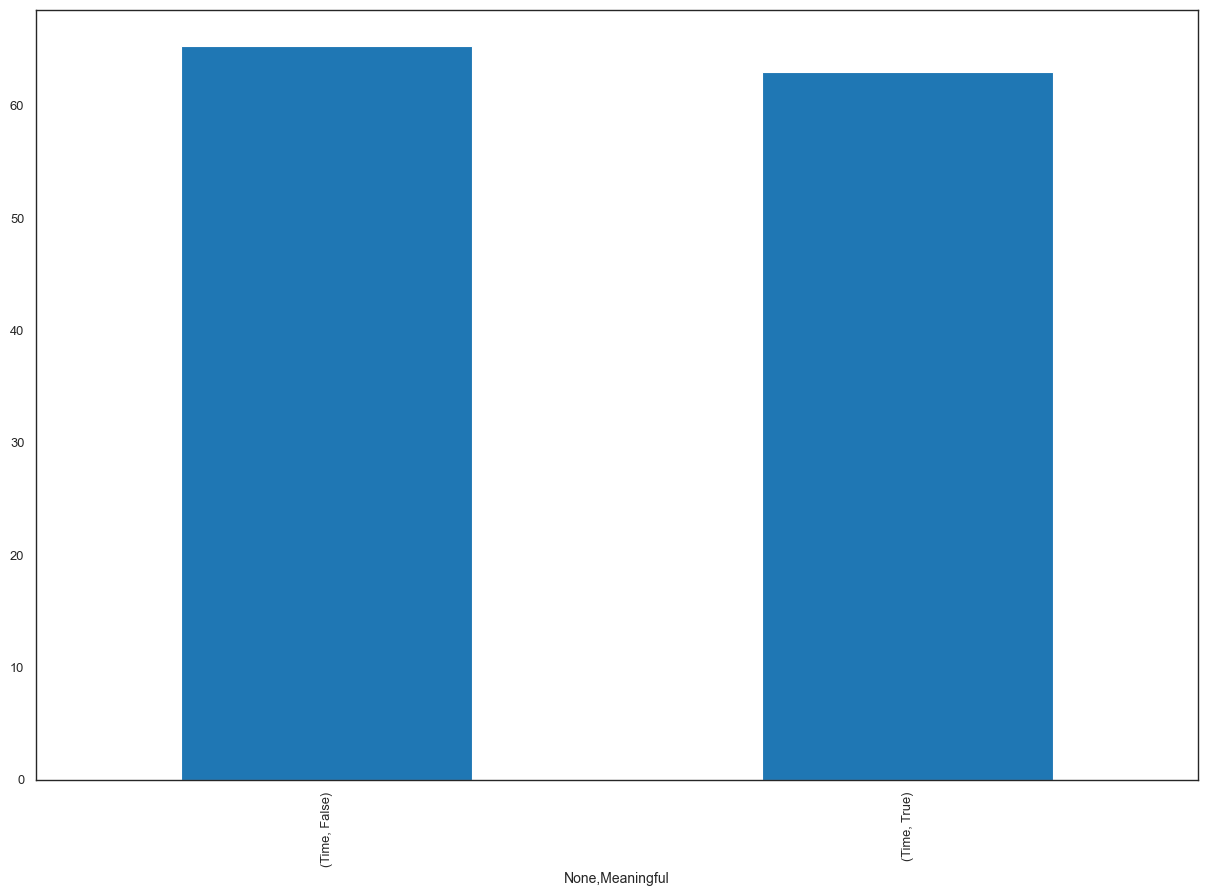

In [106]:
# compute if meaningful snippets were faster on average than obfuscated snippets
df_results_overall.groupby(['Meaningful']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=False,
                                                                                  figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster on average?

- [ ] TODO: Apparently, this is not the case. Why could this be? More to read? Where do people look during this time? What are they focusing on? Are they more correct?

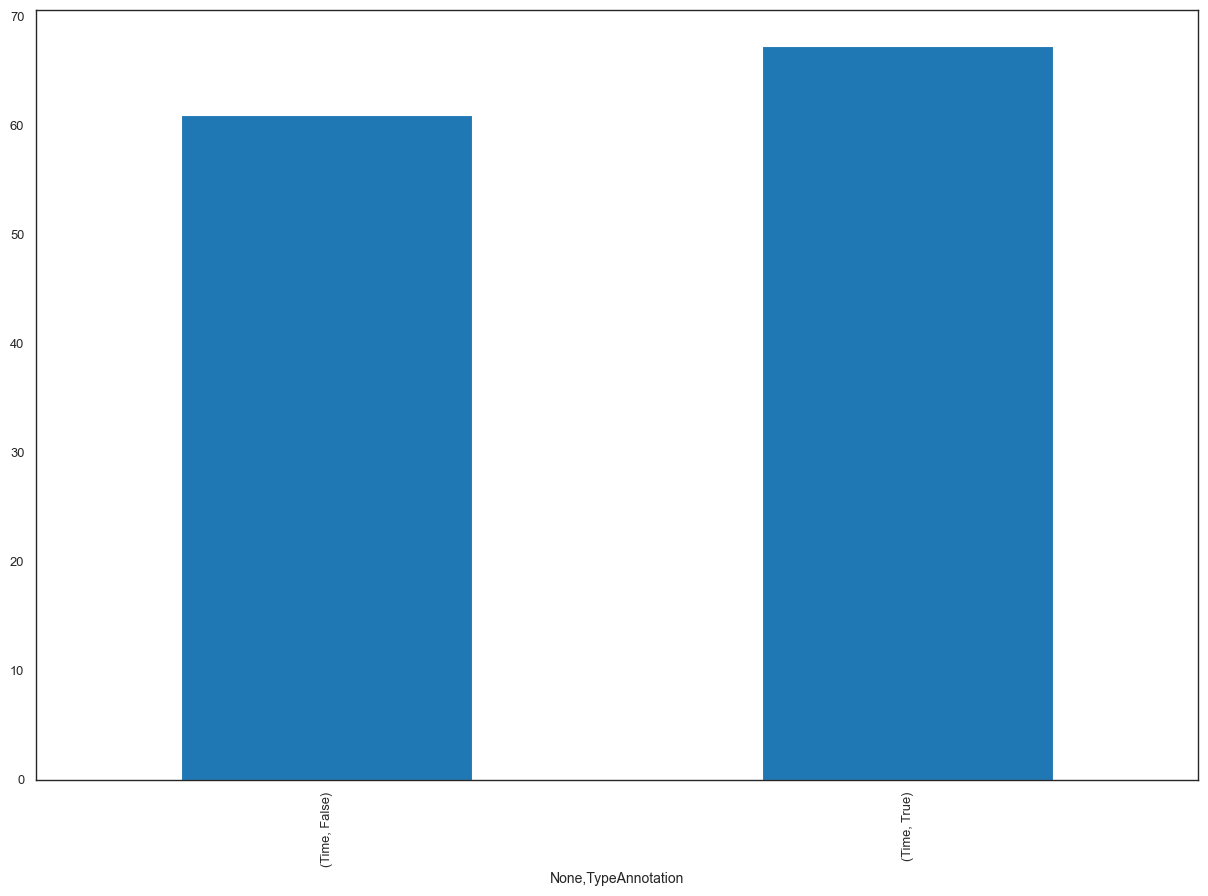

In [107]:
# compute if type annotated snippets were faster on average than non type annotated snippets
df_results_overall.groupby(['TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar', stacked=True,
                                                                                      figsize=(15, 10))
plt.show()

Do `Type Annotations` make people faster when we differentiate between `Meaningful` snippets?

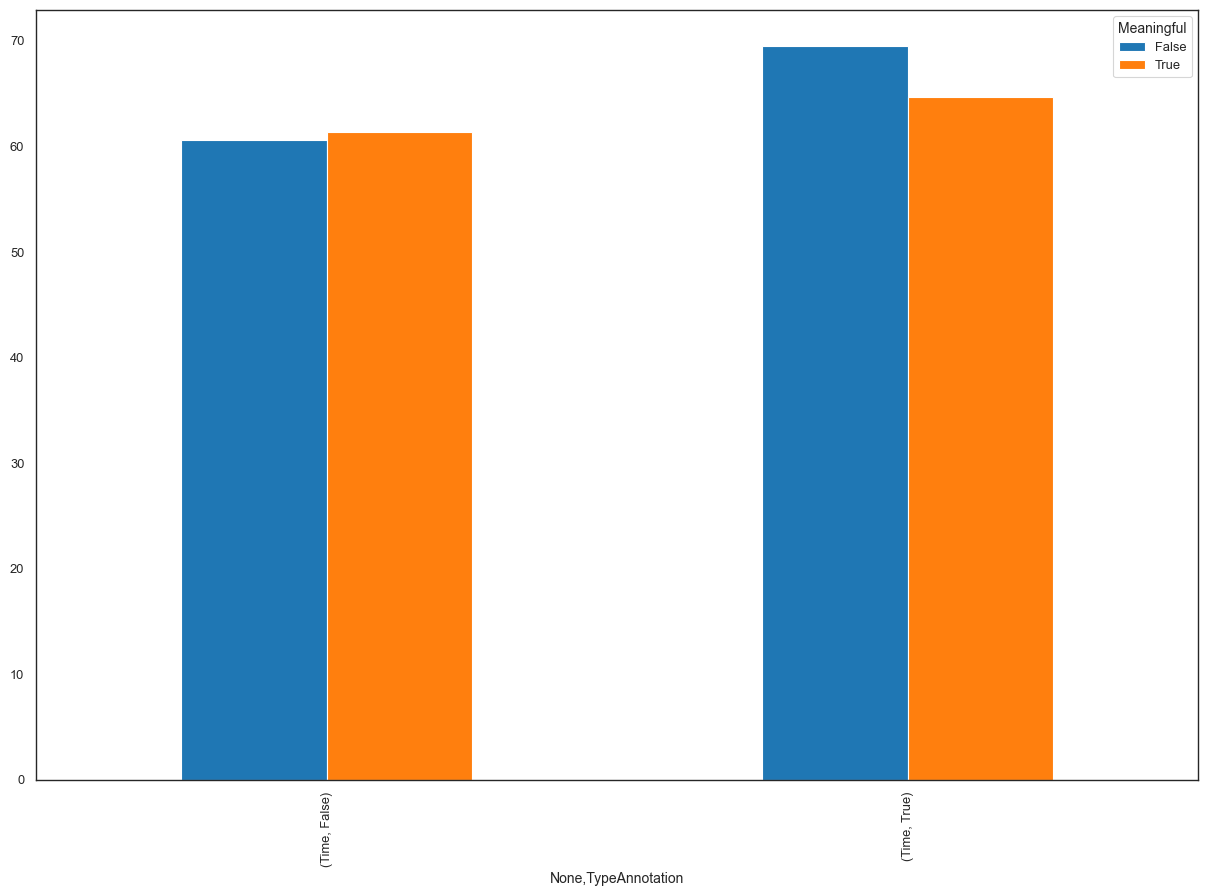

In [108]:
df_results_overall.groupby(['Meaningful', 'TypeAnnotation']).agg({'Time': 'mean'}).unstack().T.plot(kind='bar',
                                                                                                    figsize=(15, 10))
plt.show()

Are snippets with `Type Annotations` more correct?

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/321302939.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange',
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/321302939.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green',
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/321302939.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a

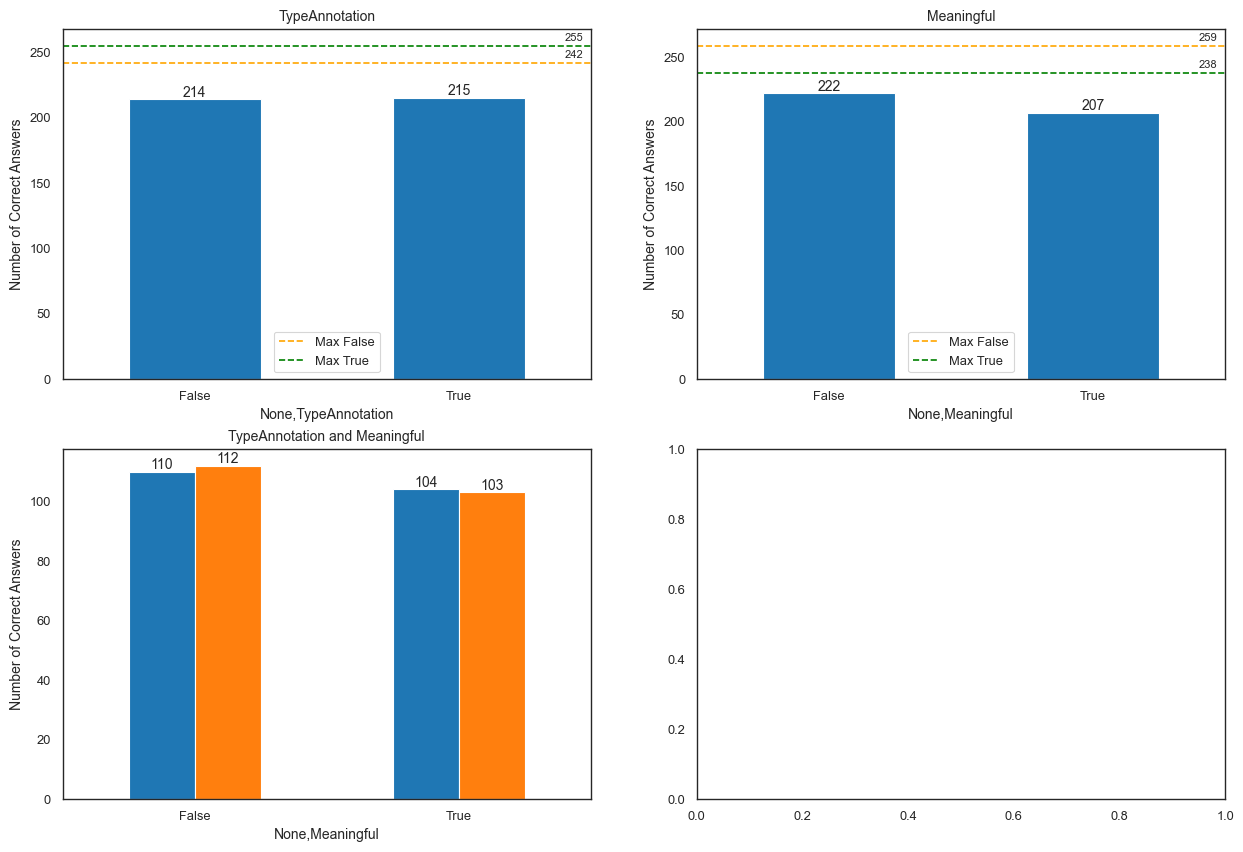

In [109]:
snippets_grouping: list[str | list[str]] = ['TypeAnnotation', 'Meaningful', ['TypeAnnotation', 'Meaningful'], ]

# create a plot consisting of len(snippets_grouping) subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, x in enumerate(snippets_grouping):
    ax = df_results_overall.groupby(x).agg({'CorrectAnswer': np.count_nonzero}).unstack().T.plot(kind='bar',
                                                                                                 ax=axs[i // 2, i % 2],
                                                                                                 title=(lambda
                                                                                                            x: f'{x[0]} and {x[1]}' if len(
                                                                                                     x) == 2 else x)(x),
                                                                                                 ylabel='Number of Correct Answers',
                                                                                                 legend=False)

    ax.set_xticklabels(['False', 'True'], rotation=0)

    if len(x) != 2:
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[0], color='orange',
                   linestyle='--', label='Max False')  # False
        ax.axhline(y=df_results_overall.groupby(x).agg({'CorrectAnswer': 'count'}).unstack()[1], color='green',
                   linestyle='--', label='Max True')  # True
        ax.legend(loc='lower center')

    for line in ax.lines:
        ax.annotate(str(int(line.get_ydata()[0])), xy=(line.get_xdata()[0], line.get_ydata()[0]), xytext=(280, 2),
                    textcoords='offset points', ha='right', va='bottom', fontsize=8)

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')

plt.show()

Are snippets that are `Meaningful` more correct?

In [110]:
df_results_overall.groupby(['TypeAnnotation', 'Meaningful']).agg({'CorrectAnswer': 'count'}).unstack()

CorrectAnswer      
Meaningful             False True 
TypeAnnotation                    
False                    123   119
True                     136   119

A better representation of this:

In [111]:
correct_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].sum()
correct_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].sum()
correct_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].sum()
correct_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].sum()

total_TA_M: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == True')['CorrectAnswer'].count()
total_TA_L: int = df_results_overall.query('`TypeAnnotation` == True and Meaningful == False')['CorrectAnswer'].count()
total_L_M: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == True')['CorrectAnswer'].count()
total_L_L: int = df_results_overall.query('`TypeAnnotation` == False and Meaningful == False')['CorrectAnswer'].count()

print(f'Type Annotation and Meaningful: {correct_TA_M}/{total_TA_M} = {correct_TA_M / total_TA_M}')
print(f'Type Annotation and Obfuscated: {correct_TA_L}/{total_TA_L} = {correct_TA_L / total_TA_L}')
print(f'No Type Annotation and Meaningful: {correct_L_M}/{total_L_M} = {correct_L_M / total_L_M}')
print(f'No Type Annotation and Obfuscated: {correct_L_L}/{total_L_L} = {correct_L_L / total_L_L}')

print(
    f'\nType Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')
print(
    f'No Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
print(
    f'Meaningful: {correct_TA_M + correct_L_M}/{total_TA_M + total_L_M} = {(correct_TA_M + correct_L_M) / (total_TA_M + total_L_M)}')
print(
    f'Obfuscated: {correct_TA_L + correct_L_L}/{total_TA_L + total_L_L} = {(correct_TA_L + correct_L_L) / (total_TA_L + total_L_L)}')


Type Annotation and Meaningful: 103/119 = 0.865546218487395
Type Annotation and Obfuscated: 112/136 = 0.8235294117647058
No Type Annotation and Meaningful: 104/119 = 0.8739495798319328
No Type Annotation and Obfuscated: 110/123 = 0.8943089430894309

Type Annotation: 215/255 = 0.8431372549019608
No Type Annotation: 214/242 = 0.8842975206611571
Meaningful: 207/238 = 0.8697478991596639
Obfuscated: 222/259 = 0.8571428571428571


Correct Answers per Snippet

In [112]:
snippet_correctness_df: DataFrame = DataFrame(columns=['Task', 'Correctness', 'Meaningful', 'TypeAnnotation'])

counter: int = 0

for task in all_tasks:
    correct_TA_M: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')[
            'CorrectAnswer'].sum()
    correct_TA_L: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')[
            'CorrectAnswer'].sum()
    correct_L_M: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')[
            'CorrectAnswer'].sum()
    correct_L_L: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')[
            'CorrectAnswer'].sum()

    total_TA_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == True')[
        'CorrectAnswer'].count()
    total_TA_L: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == True and Meaningful == False')[
            'CorrectAnswer'].count()
    total_L_M: int = df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == True')[
        'CorrectAnswer'].count()
    total_L_L: int = \
        df_results_overall.query(f'Task == "{task}" and `TypeAnnotation` == False and Meaningful == False')[
            'CorrectAnswer'].count()

    print(f'\nTask: {task}')

    print(
        f'\nNo Type Annotation: {correct_L_M + correct_L_L}/{total_L_M + total_L_L} = {(correct_L_M + correct_L_L) / (total_L_M + total_L_L)}')
    print(
        f'Type Annotation: {correct_TA_M + correct_TA_L}/{total_TA_M + total_TA_L} = {(correct_TA_M + correct_TA_L) / (total_TA_M + total_TA_L)}')

    snippet_correctness_df.loc[counter] = [task, correct_TA_M / total_TA_M, True, True]
    snippet_correctness_df.loc[counter + 1] = [task, correct_TA_L / total_TA_L, False, True]
    snippet_correctness_df.loc[counter + 2] = [task, correct_L_M / total_L_M, True, False]
    snippet_correctness_df.loc[counter + 3] = [task, correct_L_L / total_L_L, False, False]

    counter += 4


Task: arrayAverage

No Type Annotation: 10/10 = 1.0
Type Annotation: 17/17 = 1.0

Task: binarySearch

No Type Annotation: 13/14 = 0.9285714285714286
Type Annotation: 9/10 = 0.9

Task: binaryToDecimal

No Type Annotation: 10/13 = 0.7692307692307693
Type Annotation: 12/14 = 0.8571428571428571

Task: bubbleSort

No Type Annotation: 11/11 = 1.0
Type Annotation: 11/14 = 0.7857142857142857

Task: capitalizeFirstLetter

No Type Annotation: 10/10 = 1.0
Type Annotation: 17/17 = 1.0

Task: commonChars

No Type Annotation: 8/14 = 0.5714285714285714
Type Annotation: 8/12 = 0.6666666666666666

Task: containsSubstring

No Type Annotation: 9/12 = 0.75
Type Annotation: 10/14 = 0.7142857142857143

Task: countIntegerInterval

No Type Annotation: 11/12 = 0.9166666666666666
Type Annotation: 7/14 = 0.5

Task: countLetters

No Type Annotation: 6/8 = 0.75
Type Annotation: 12/13 = 0.9230769230769231

Task: crossSum

No Type Annotation: 8/12 = 0.6666666666666666
Type Annotation: 15/17 = 0.8823529411764706

Ta

Statistic for the participants:
- Number of Snippets
- Number of Correct / Incorrect Snippets
- Meaningful / Obfuscated Snippets
- Mean Time for Type Annotation / No Type Annotation
- Overall Time Taken in Minutes

We start with the participants in the obfuscated group.

In [113]:
print(f'Obfuscated Participants')
for participant in obfuscated_participants:
    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(
        f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(
        f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

print(f'\n\nMeaningful Participants')

for participant in meaningful_participants:
    print(f'\nParticipant {participant}')
    number_of_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].count()
    correct_snippets: int = df_results_overall.query(f'ID == "{participant}"')['CorrectAnswer'].sum()
    print(
        f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')

    mean_time: float = df_results_overall.query(f'ID == "{participant}"')['Time'].mean()
    print(f'Participant {participant} has a mean time of {mean_time} seconds')

    mean_time_TA: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')['Time'].mean()
    mean_time_L: float = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')['Time'].mean()
    print(
        f'Participant {participant} has a mean time of {mean_time_TA} seconds with Type Annotations and {mean_time_L} seconds without Type Annotations, thus the change is {mean_time_L - mean_time_TA} seconds')

    overall_time: float = df_results_overall.query(f'ID == @participant')['Time'].sum()
    print(f'Participant {participant} took {overall_time // 60} minutes and {overall_time % 60} seconds in total')

Obfuscated Participants

Participant 10723
Participant 10723 has 14/14 correct snippets: 1.0
Participant 10723 has a mean time of 87.78571428571429 seconds
Participant 10723 has a mean time of 87.83333333333333 seconds with Type Annotations and 87.75 seconds without Type Annotations, thus the change is -0.0833333333333286 seconds
Participant 10723 took 20 minutes and 29 seconds in total

Participant 18457
Participant 18457 has 18/18 correct snippets: 1.0
Participant 18457 has a mean time of 77.11111111111111 seconds
Participant 18457 has a mean time of 76.16666666666667 seconds with Type Annotations and 77.58333333333333 seconds without Type Annotations, thus the change is 1.4166666666666572 seconds
Participant 18457 took 23 minutes and 8 seconds in total

Participant 18868
Participant 18868 has 17/20 correct snippets: 0.85
Participant 18868 has a mean time of 71.1 seconds
Participant 18868 has a mean time of 74.7 seconds with Type Annotations and 67.5 seconds without Type Annotations,

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {cor

Participant 12663 has 0/0 correct snippets: nan
Participant 12663 has a mean time of nan seconds
Participant 12663 has a mean time of nan seconds with Type Annotations and nan seconds without Type Annotations, thus the change is nan seconds
Participant 12663 took 0 minutes and 0 seconds in total

Participant 13020
Participant 13020 has 0/0 correct snippets: nan
Participant 13020 has a mean time of nan seconds
Participant 13020 has a mean time of nan seconds with Type Annotations and nan seconds without Type Annotations, thus the change is nan seconds
Participant 13020 took 0 minutes and 0 seconds in total

Participant 14296
Participant 14296 has 13/15 correct snippets: 0.8666666666666667
Participant 14296 has a mean time of 84.93333333333334 seconds
Participant 14296 has a mean time of 90.5 seconds with Type Annotations and 73.8 seconds without Type Annotations, thus the change is -16.700000000000003 seconds
Participant 14296 took 21 minutes and 14 seconds in total

Participant 23559
P

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:27: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:27: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1752166567.py:27: RuntimeWarning: invalid value encountered in scalar divide
  f'Participant {participant} has {correct_snippets}/{number_of_snippets} correct snippets: {correct_snippets / number_of_snippets}')


Check for the number of correct snippets as a ratio for participants.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1527659958.py:16: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1527659958.py:17: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1527659958.py:16: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1527659958.py:17: RuntimeWarning: invalid value encountered in scalar divide
  correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]
/var/folders/_k/xv0m9bhx30

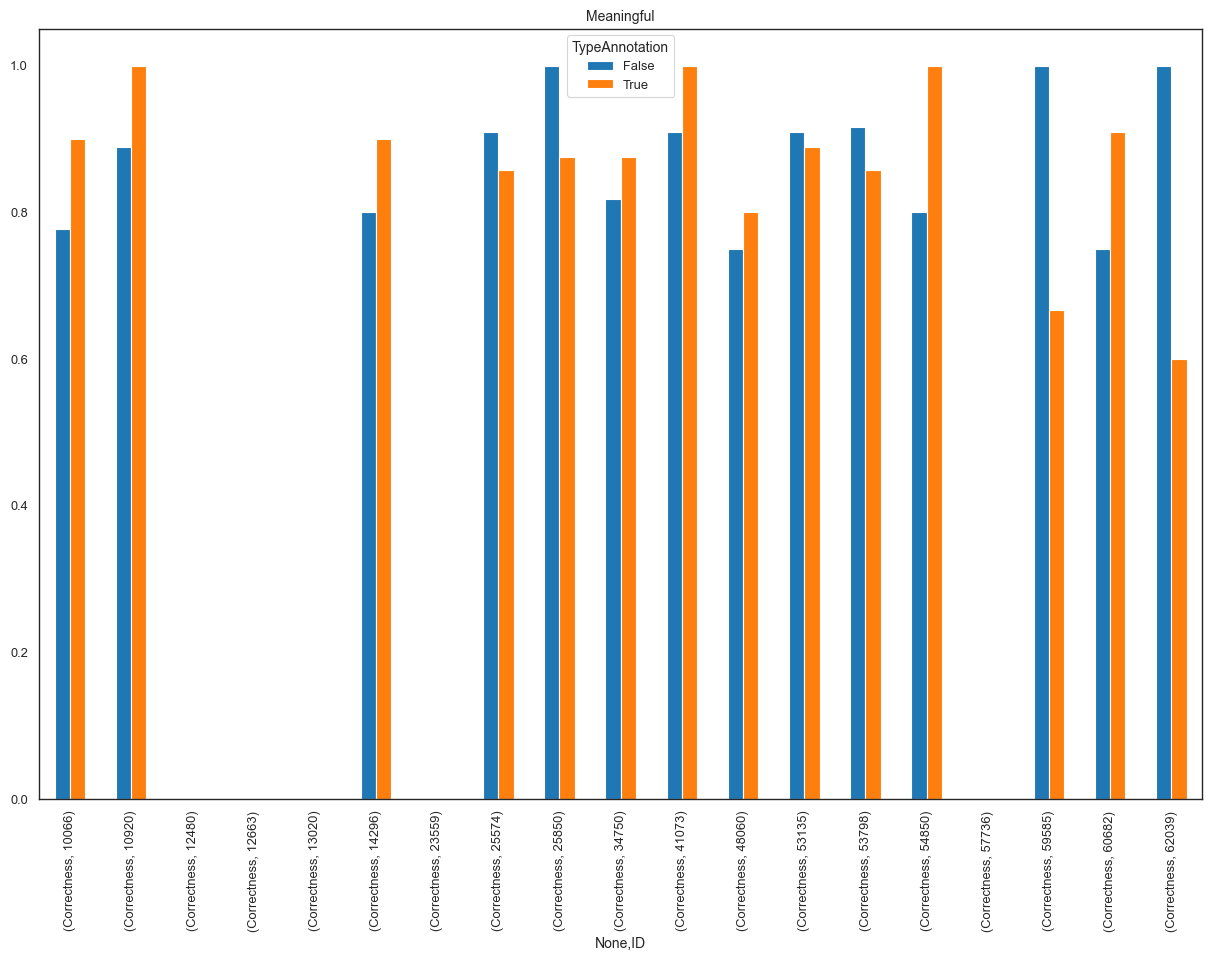

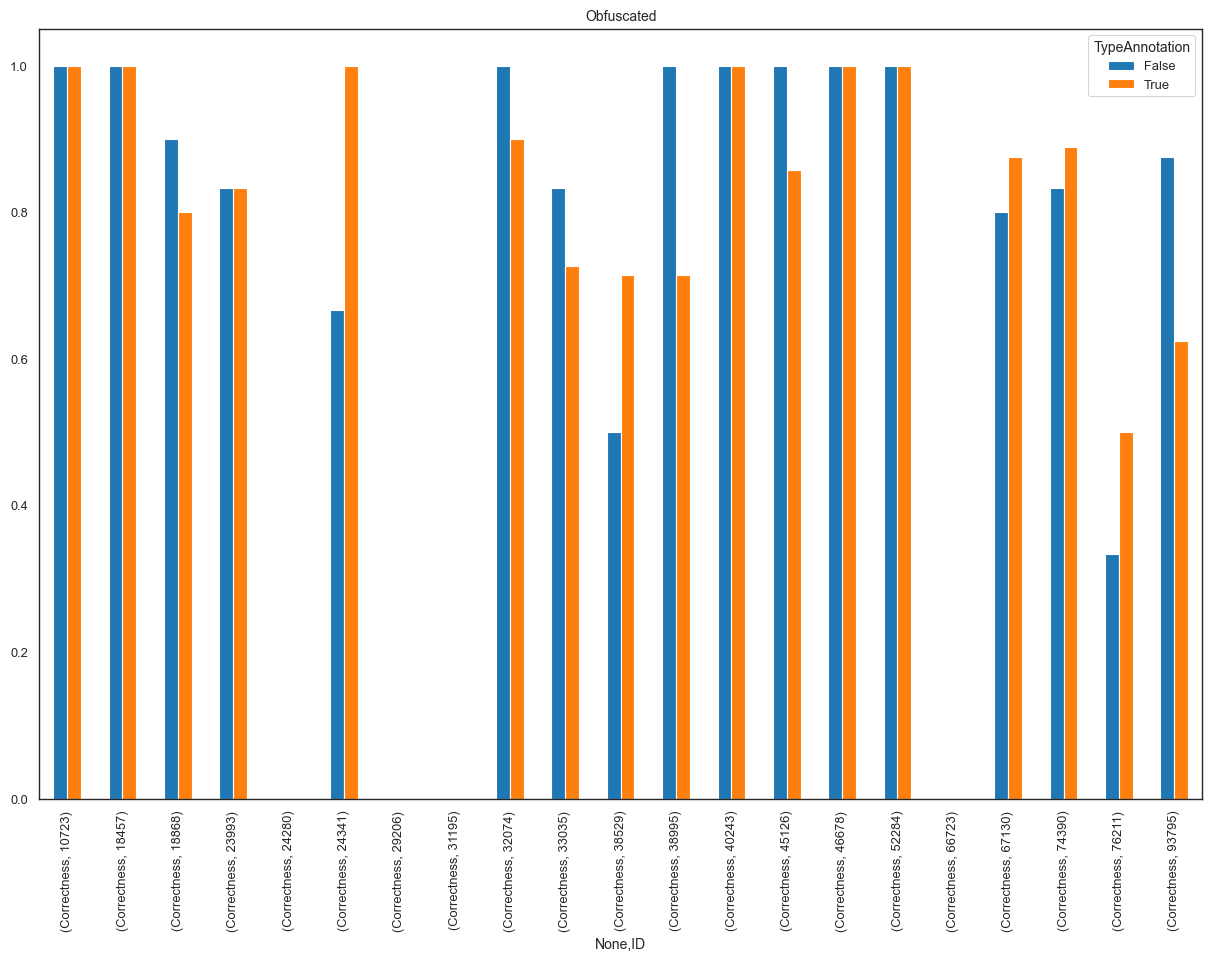

In [114]:
correctness_df_by_participant_meaningful: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])
correctness_df_by_participant_obfuscated: DataFrame = DataFrame(columns=['ID', 'Correctness', 'TypeAnnotation'])

counter: int = 0
for participant in meaningful_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')[
        'CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')[
        'CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')[
        'CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')[
        'CorrectAnswer'].count()

    correctness_df_by_participant_meaningful.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_meaningful.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

counter = 0
for participant in obfuscated_participants:
    correct_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')[
        'CorrectAnswer'].sum()
    correct_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')[
        'CorrectAnswer'].sum()

    total_TA: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == True')[
        'CorrectAnswer'].count()
    total_L: int = df_results_overall.query(f'ID == "{participant}" and `TypeAnnotation` == False')[
        'CorrectAnswer'].count()

    correctness_df_by_participant_obfuscated.loc[counter] = [participant, correct_TA / total_TA, True]
    correctness_df_by_participant_obfuscated.loc[counter + 1] = [participant, correct_L / total_L, False]

    counter += 2

correctness_df_by_participant_meaningful.groupby(['TypeAnnotation', 'ID']).agg(
    {'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Meaningful")

correctness_df_by_participant_obfuscated.groupby(['TypeAnnotation', 'ID']).agg(
    {'Correctness': 'mean'}).unstack().T.plot(kind='bar', figsize=(15, 10), title="Obfuscated")
plt.show()

Check for the time and correct answers per code snippet.

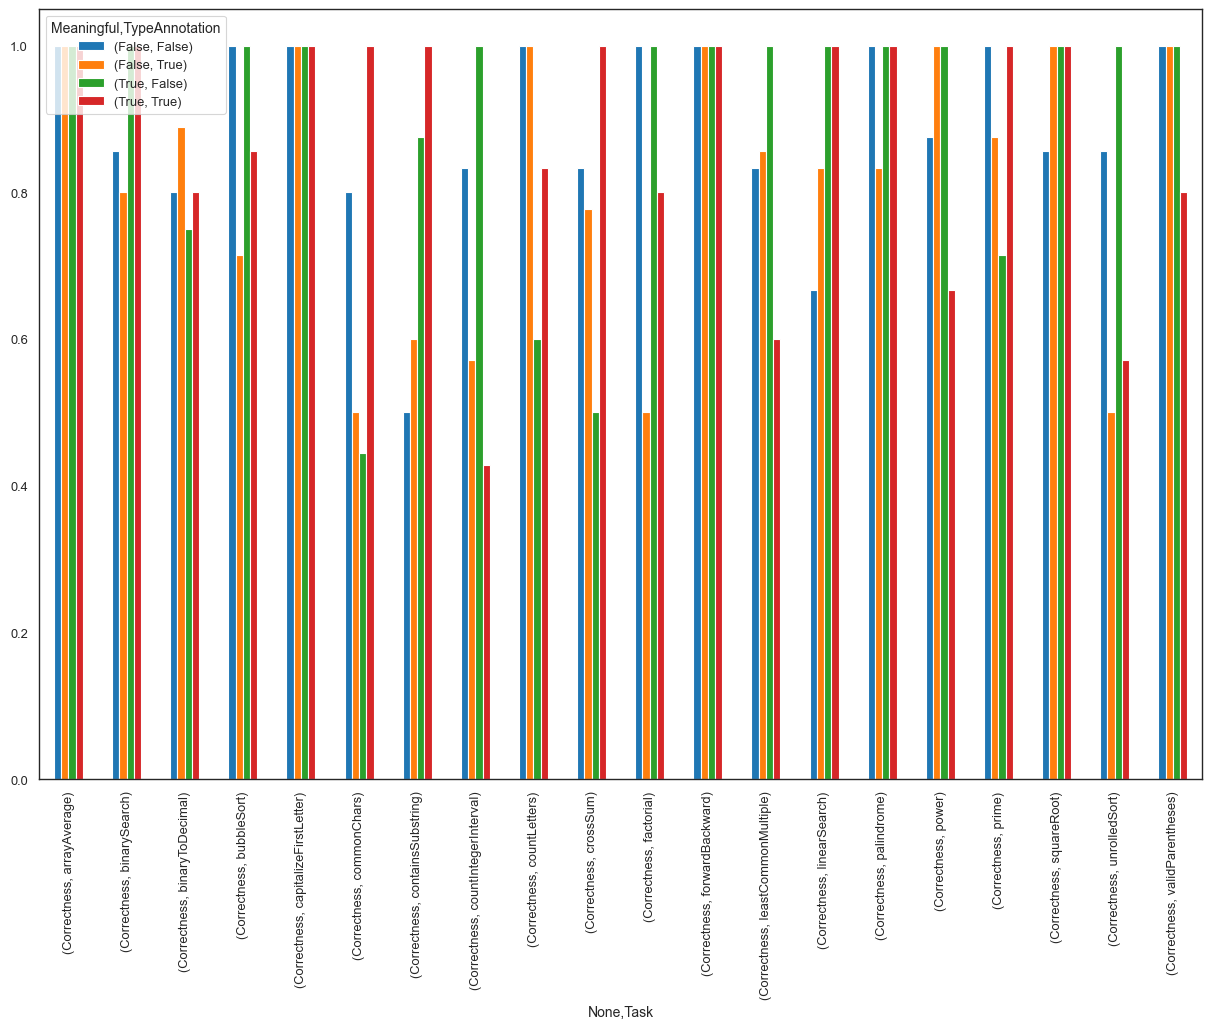

In [115]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation', 'Task']).agg({'Correctness': 'mean'}).unstack().T.plot(
    kind='bar', figsize=(15, 10))

plt.show()

### Difficulty Rating

First let's check how the difficulty is for each task. I think this would be best as a table?

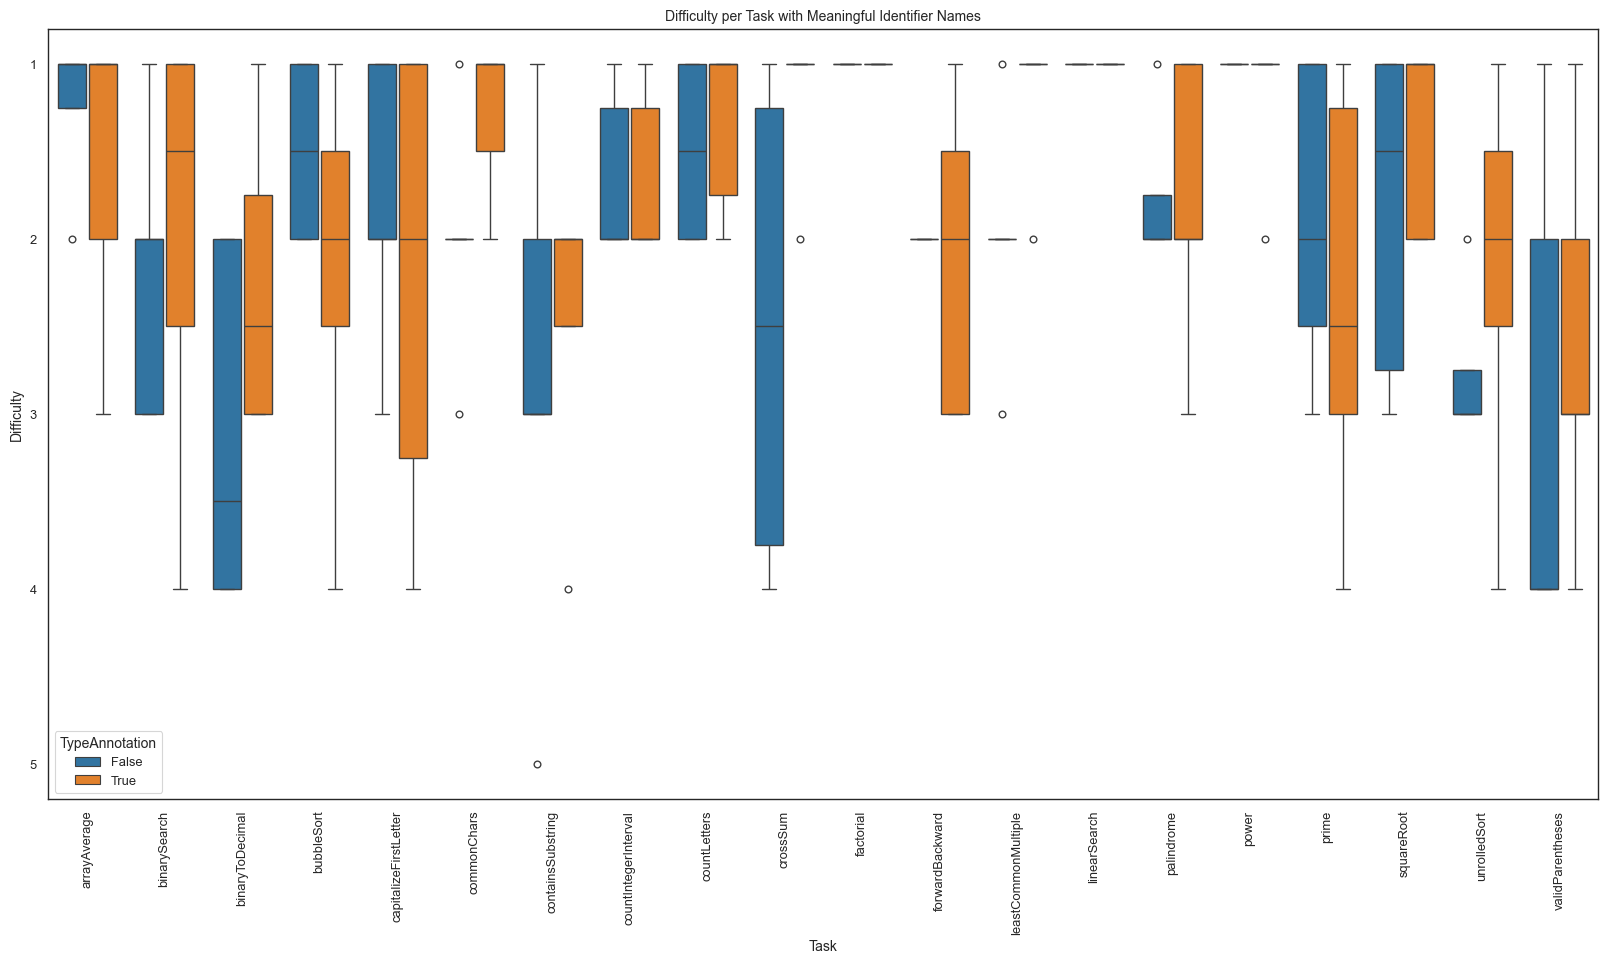

In [116]:
plt.figure(figsize=(20, 10))
sns.boxplot(df_results_overall.query(f'`Meaningful` == True'), x='Task', y='Difficulty', hue='TypeAnnotation',
            gap=.1,
            # inner="quart", 
            # cut=0, 
            order=all_tasks,
            # split=True,
            )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with Meaningful Identifier Names')

plt.show()

And now with obfuscated identifier names.

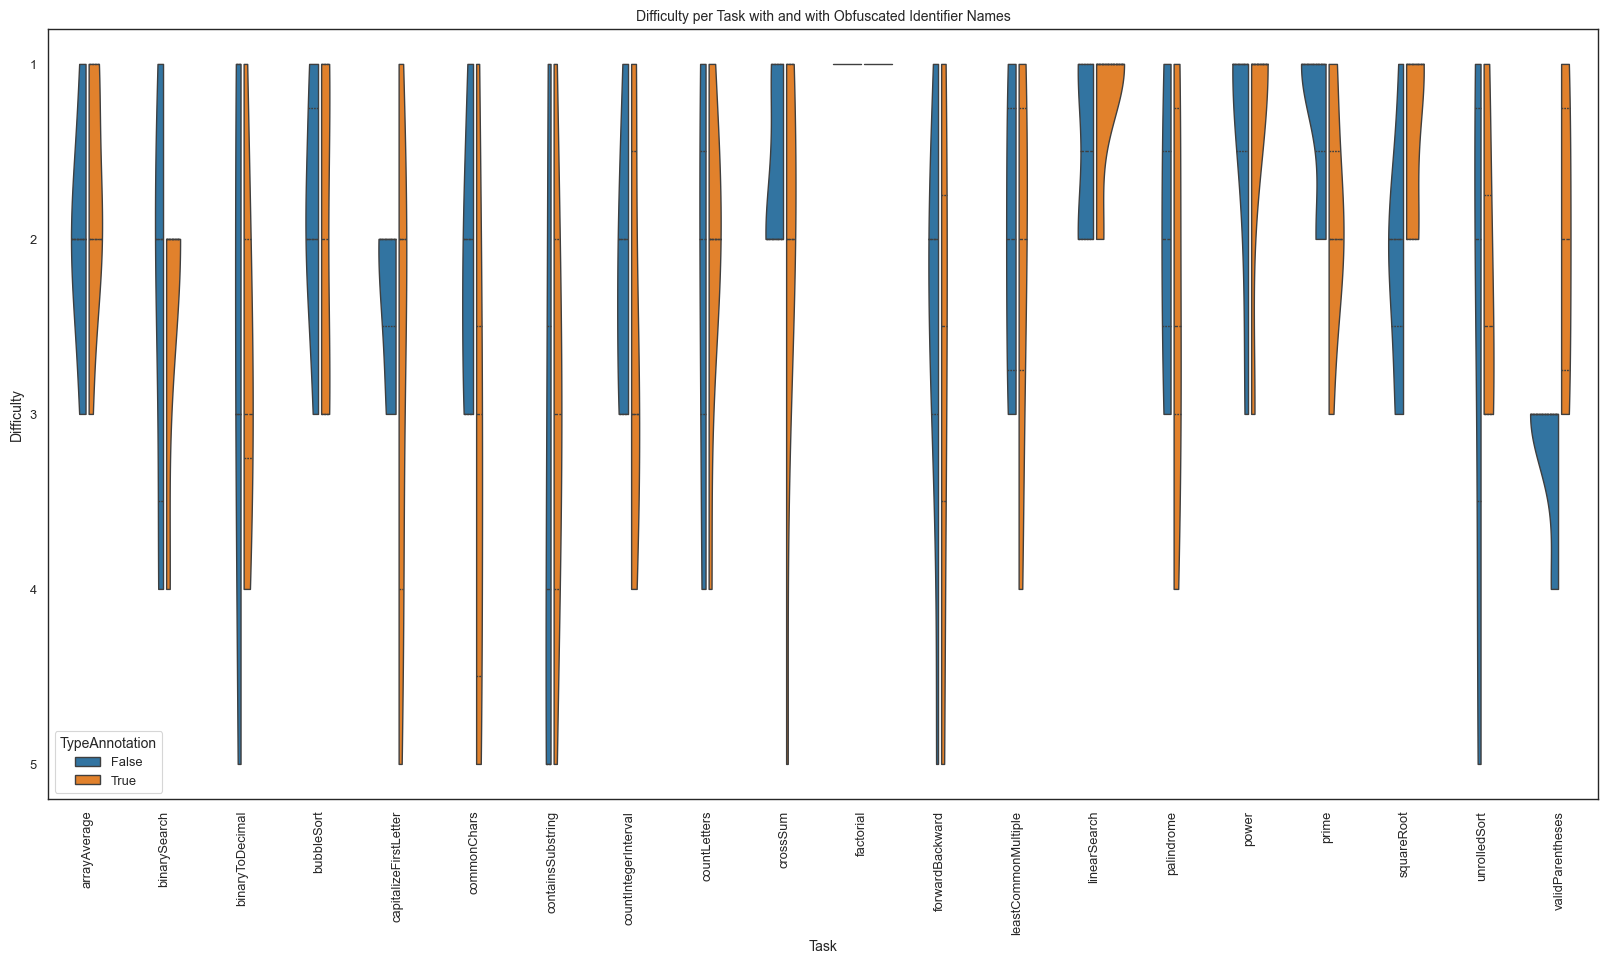

In [117]:
plt.figure(figsize=(20, 10))
sns.violinplot(df_results_overall.query(f'`Meaningful` == False'), x='Task', y='Difficulty',
               hue='TypeAnnotation',
               gap=.1,
               inner="quart",
               cut=0,
               order=all_tasks,
               split=True,
               )

plt.xticks(all_tasks, rotation=90)
plt.yticks(np.arange(1, 6, 1))
plt.title('Difficulty per Task with and with Obfuscated Identifier Names')

plt.show()

The difficulty that each participant felt.

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3949734619.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_M = axs[0].boxplot([df_results_overall.query(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3949734619.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_TA_M = axs[0].boxplot([df_results_overall.query(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3949734619.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plot_L_L = axs[1].boxplot([df_results_overall.query(
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/3949734619.py:25: M

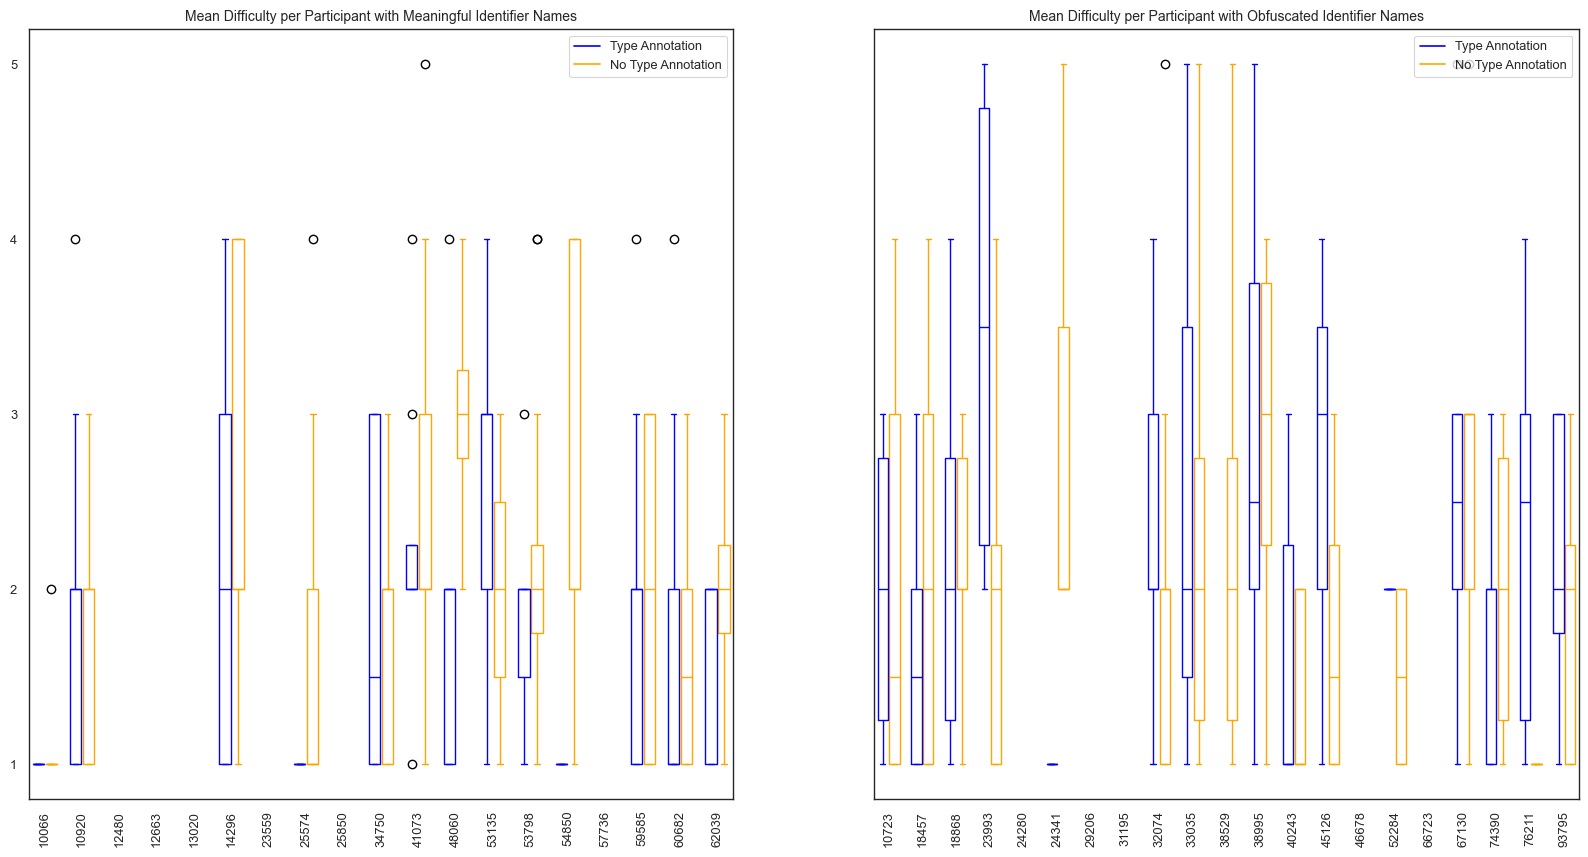

In [118]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), sharey=True)

# first plot
plot_L_M = axs[0].boxplot([df_results_overall.query(
    f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == True')['Difficulty'] for participant in
                           meaningful_participants], labels=meaningful_participants,
                          positions=np.arange(len(meaningful_participants)) * 2.0 + 0.35, widths=0.6)
plot_TA_M = axs[0].boxplot([df_results_overall.query(
    f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == True')['Difficulty'] for participant in
                            meaningful_participants], labels=meaningful_participants,
                           positions=np.arange(len(meaningful_participants)) * 2.0 - 0.35, widths=0.6)

# first plot settings
axs[0].set_title('Mean Difficulty per Participant with Meaningful Identifier Names')
axs[0].set_xticks(np.arange(0, len(meaningful_participants) * 2, 2), meaningful_participants, rotation=90)
axs[0].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_M, 'blue', 'Type Annotation', axs[0])
define_box_properties(plot_L_M, 'orange', 'No Type Annotation', axs[0])

# second plot
plot_L_L = axs[1].boxplot([df_results_overall.query(
    f'`ID` == @participant and `TypeAnnotation` == False and `Meaningful` == False')['Difficulty'] for participant in
                           obfuscated_participants], labels=obfuscated_participants,
                          positions=np.arange(len(obfuscated_participants)) * 2.0 + 0.35, widths=0.6)
plot_TA_L = axs[1].boxplot([df_results_overall.query(
    f'`ID` == @participant and `TypeAnnotation` == True and `Meaningful` == False')['Difficulty'] for participant in
                            obfuscated_participants], labels=obfuscated_participants,
                           positions=np.arange(len(obfuscated_participants)) * 2.0 - 0.35, widths=0.6)

# second plot settings
axs[1].set_title('Mean Difficulty per Participant with Obfuscated Identifier Names')
axs[1].set_xticks(np.arange(0, len(obfuscated_participants) * 2, 2), obfuscated_participants, rotation=90)
axs[1].set_yticks(np.arange(1, 6, 1))
define_box_properties(plot_TA_L, 'blue', 'Type Annotation', axs[1])
define_box_properties(plot_L_L, 'orange', 'No Type Annotation', axs[1])

plt.show()


Correct Answer by Difficulty

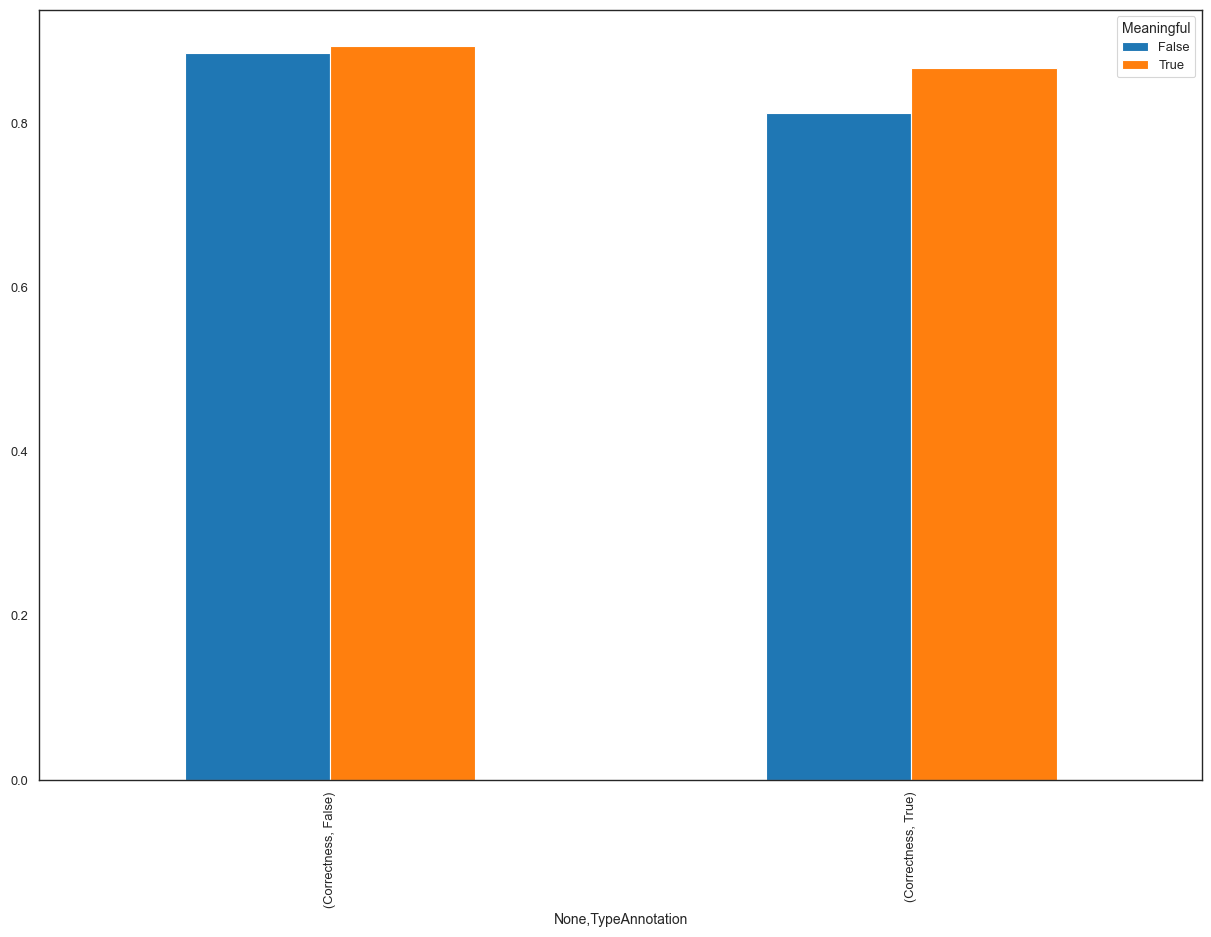

In [119]:
snippet_correctness_df.groupby(['Meaningful', 'TypeAnnotation']).agg({'Correctness': 'mean'}).unstack().T.plot(
    kind='bar', figsize=(15, 10))

plt.show()

Difficulty count by snippet

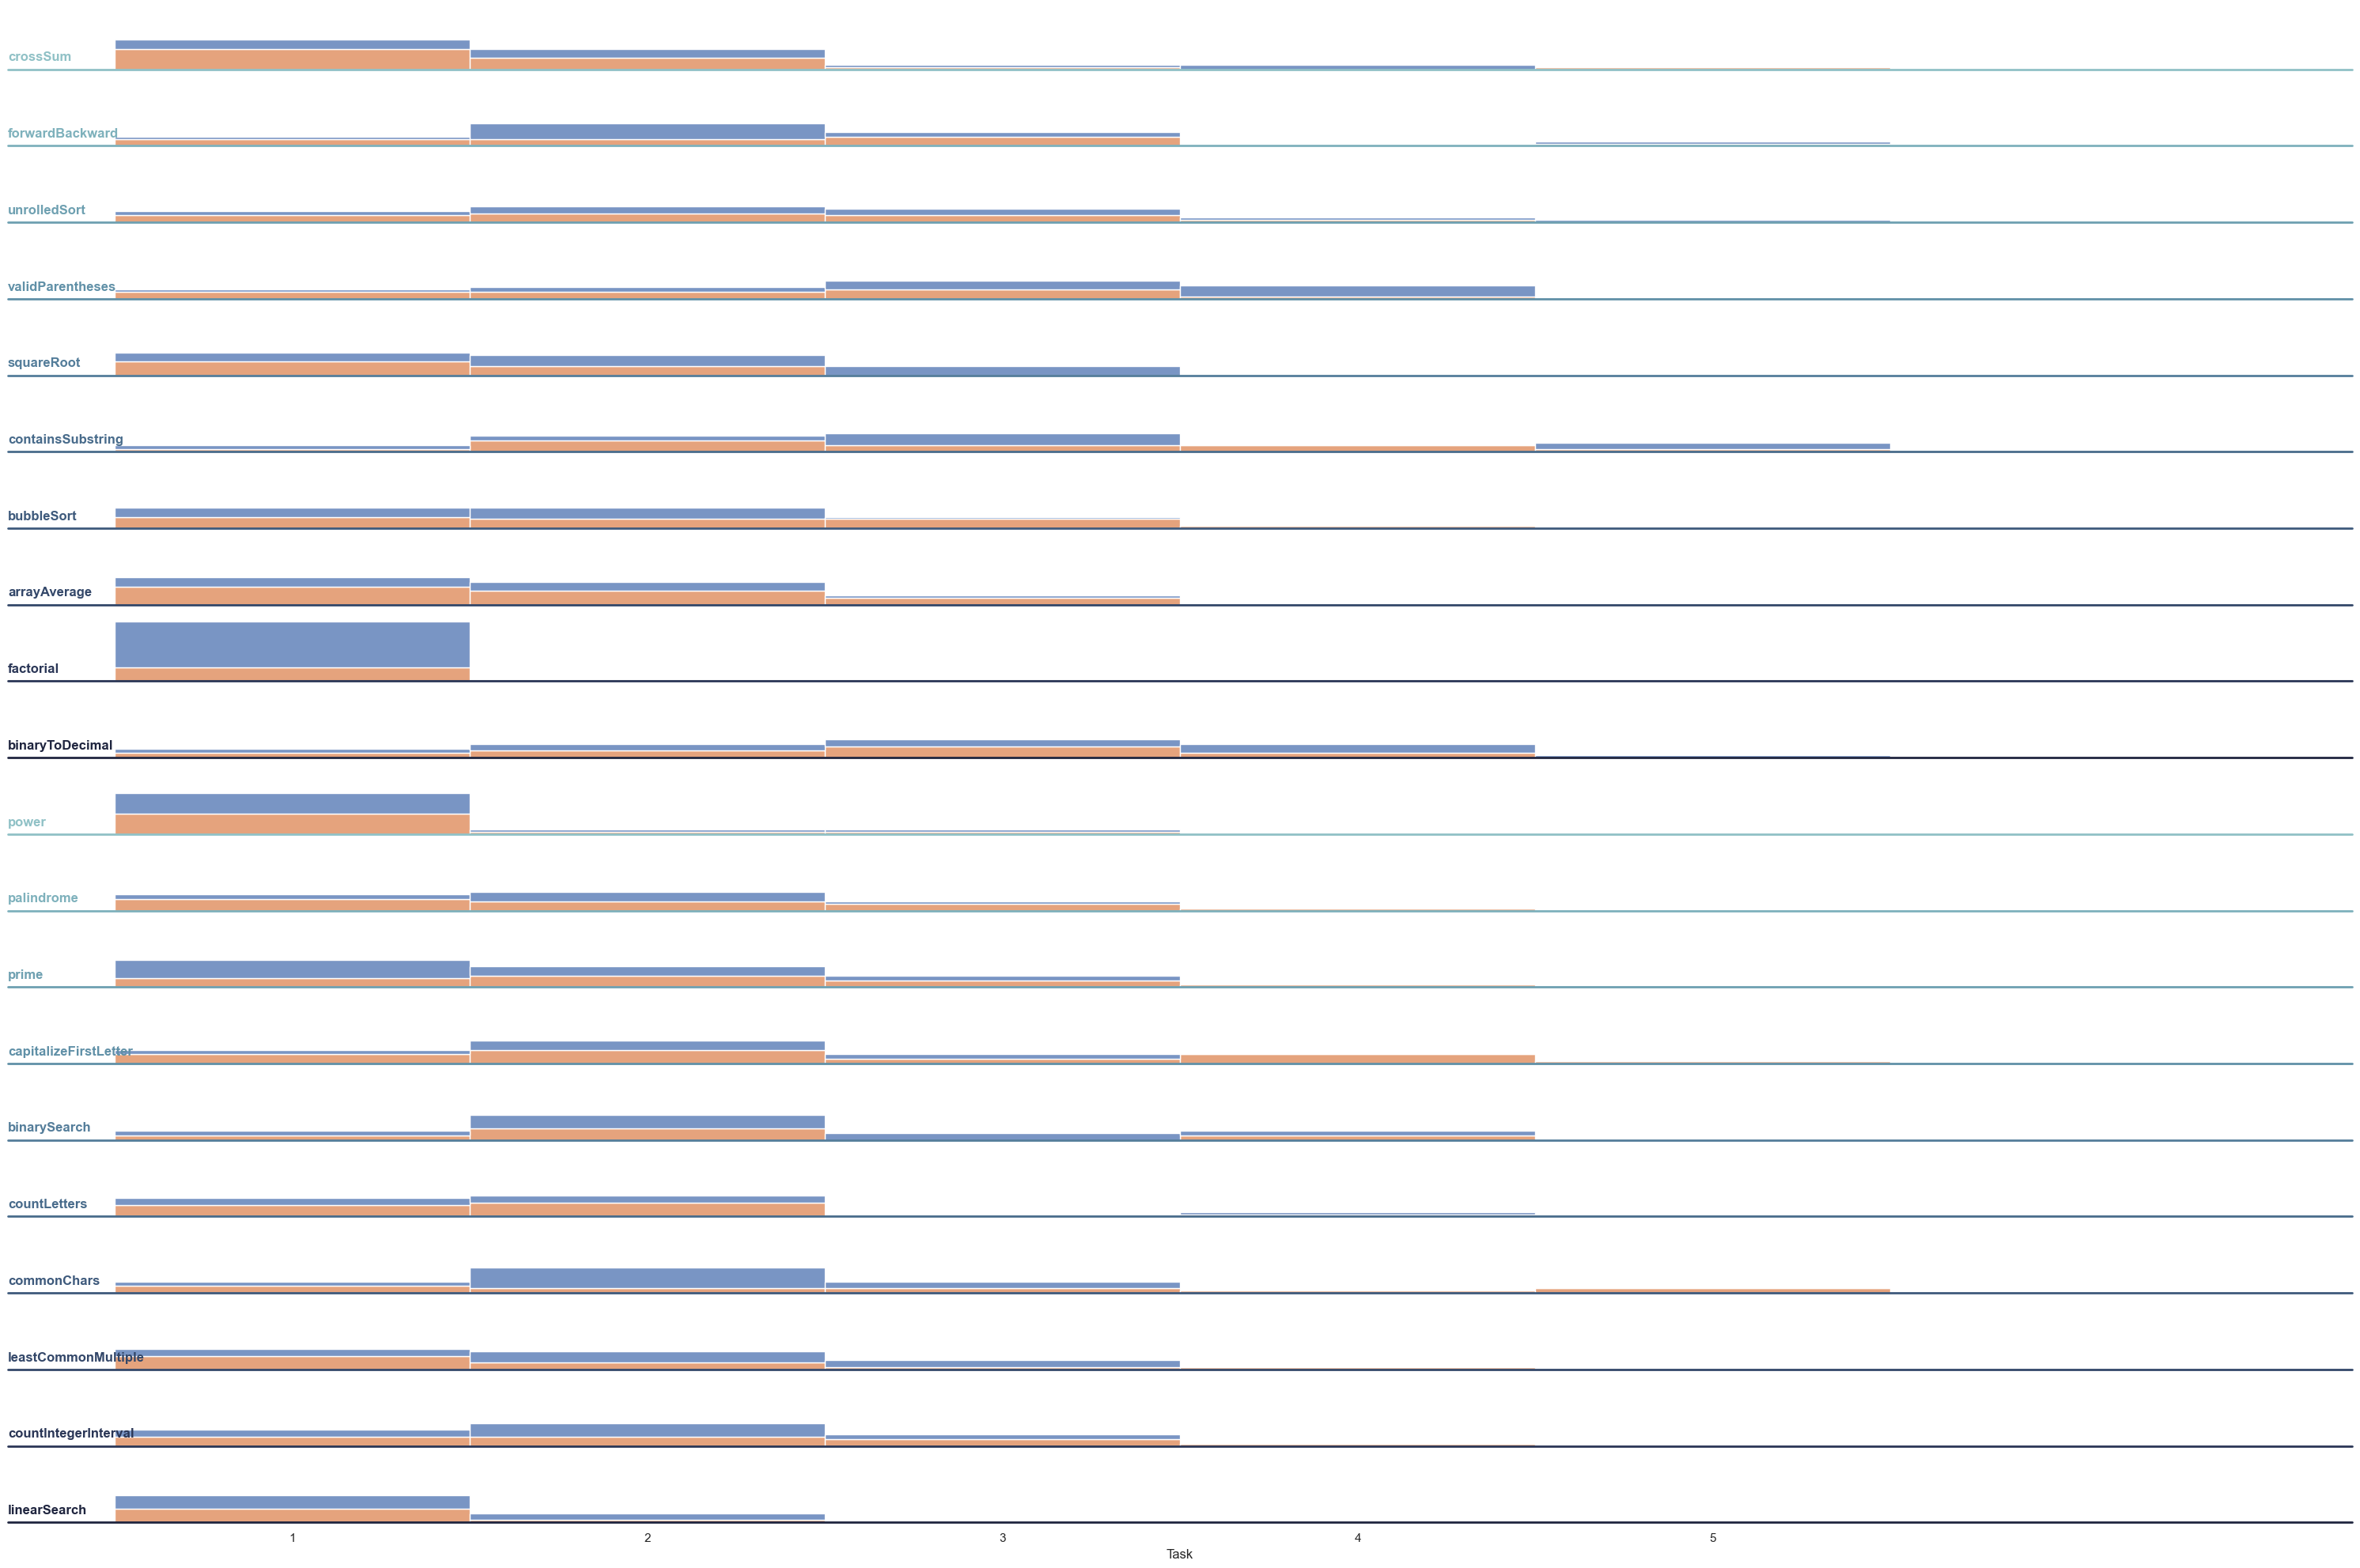

In [120]:
sns.set_theme(style="white")
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_results_overall, row="Task",
                  #   col="Type Annotation",
                  hue="Task",
                  height=1,
                  aspect=30,
                  palette=pal,
                  )
g.map_dataframe(sns.histplot, x="Difficulty", hue="TypeAnnotation", binwidth=1, binrange=(1, 6), multiple="stack")
# g.map_dataframe(sns.kdeplot, x="Difficulty", clip=(1, 5), fill=True)
# g.map_dataframe(sns.kdeplot, x="Difficulty", hue='Type Annotation', clip_on=(1, 5), color="black", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)


g.map(label, "Task")
g.figure.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xticks=np.arange(1, 6, 1))
g.despine(bottom=True, left=True)

g.figure.tight_layout()


## Display META Data

In [121]:
# if the line 'Total' does not exist, create it
if not 'Total' in df_meta_data.index:
    df_meta_data.loc['Total'] = df_meta_data[
        [col for col in meta_data_columns if col not in unnecessary_columns_meta_data]].sum()
    # add the number of times a participant did not finish all snippets to the 'Total' line
    df_meta_data.loc['Total', 'NumberOfMissingSnippets'] = \
        df_meta_data.groupby('ID')['NumberOfMissingSnippets'].any().value_counts()[True]
    # df_meta_data.loc['Total']['NumberOfMissingSnippets'] = df_meta_data['NumberOfMissingSnippets'].any()
    df_meta_data = df_meta_data.fillna('')

# set the background color of the dataframe value to red if the value is False
df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')

/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1258859933.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta_data = df_meta_data.fillna('')
/var/folders/_k/xv0m9bhx30g3vf97bj668zn40000gn/T/ipykernel_9089/1258859933.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_meta_data.style.applymap(lambda x: 'background-color: darkred' if x == False else '')


,ID,GazeData,GazeDataFilled,InterviewData,OverallTime,Meaningful,Finished,NumberOfMissingSnippets,PersonalInformation,ResultsOverall
0,10066,True,,,,1,True,0,True,True
1,10723,True,,,,0,True,0,True,True
2,10920,True,,,,1,True,0,True,True
3,12480,True,,,,1,True,0,True,True
4,12663,True,,,,1,False,4,True,True
5,13020,True,,,,1,False,8,True,True
6,14296,True,,,,1,False,1,True,True
7,18457,True,,,,0,True,0,True,True
8,18868,True,,,,0,True,0,True,True
9,23559,False,,,,1,False,3,True,True


### Overview

The corrected p-values for the mixed linear regression models.

In [122]:

# Example p-values
p_values = np.array([0.43, 0.033, 0.056, 0.031, 0.33, 0.1, 0.55, 0.97])

# Perform Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Output the results
print("Original p-values:", p_values)
print("Corrected p-values:", pvals_corrected)
print("Rejected hypotheses:", rejected)

Original p-values: [0.43  0.033 0.056 0.031 0.33  0.1   0.55  0.97 ]
Corrected p-values: [0.57333333 0.132      0.14933333 0.132      0.528      0.2
 0.62857143 0.97      ]
Rejected hypotheses: [False False False False False False False False]


In [123]:

# Example p-values
p_values = np.array([0.43, 0.033, 0.056, 0.031, 0.33, 0.1, 0.55, 0.97])

# Perform Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

# Output the results
print("Original p-values:", p_values)
print("Corrected p-values:", pvals_corrected)
print("Rejected hypotheses:", rejected)

Original p-values: [0.43  0.033 0.056 0.031 0.33  0.1   0.55  0.97 ]
Corrected p-values: [0.57333333 0.132      0.14933333 0.132      0.528      0.2
 0.62857143 0.97      ]
Rejected hypotheses: [False False False False False False False False]
